In [2]:
import numpy as np
import math
from pylab import *
import matplotlib.pyplot as plt


# class for roomba simulation
class RoombaSimulation():
    """
    The parameters are: proportion of obstacles (q_o), prob of a random cell getting occupied (p_o),
    prob of a random cell getting unoccupied (p_u), prob of a random cell getting dirty (p_d),
    prob of the roomba cleaning (p_c), size of the floor (size).
    """
    def __init__(self, q_o, p_u, p_o, p_d, p_c, size):
        self.q_o = q_o
        self.p_u = p_u
        self.p_o = p_o
        self.p_d = p_d
        self.p_c = p_c
        self.size = size
        # total time it takes
        self.T = 0
        # number of time steps
        self.step = 0
        # the floor
        self.config = np.zeros([size, size])
        # position of roomba
        self.pos = None
        # direction of roomba
        self.current_dir = None
    
    # initialize initial state
    def initialize(self):
        # put obstacles in random cells
        original_sum = 0
        while original_sum > (-int(self.size**2*self.q_o)):
            # get random coordinates
            x = np.random.choice(range(0, self.size-1), 1)[0]
            y = np.random.choice(range(0, self.size-1), 1)[0]
            # if it's empty, put obstacles
            if self.config[x, y] == 0:
                self.config[x, y] = -1
                original_sum -= 1
                
        # get all the empty cells
        empty = np.where(self.config == 0)
        # get a random position to start with
        point = np.random.choice(range(len(empty[0])-1), 1)[0]
        self.pos = np.array([empty[0][point], empty[1][point]])
        # get a random direction to start with
        self.current_dir = np.array([[1, 0], [-1, 0], [0, -1], [0, 1]])[np.random.choice(range(4),1)[0]]
    
    # change the floor state without roomba's action
    def cell_change(self):
        # get a random cell
        x = np.random.choice(range(self.size),1)[0]
        y = np.random.choice(range(self.size),1)[0]
        # if roomba is not in this cell
        if not (np.array([x, y]).all() == self.pos.all()):
            # if there's obstacle
            if self.config[x, y] == -1:
                # might remove obstacle
                if np.random.random() < self.p_u:
                    self.config[x, y] == 0
            # if there's no obstacle
            else:
                # if cleaned, might become dirty
                if self.config[x, y] != 0 and np.random.random() < self.p_d:
                    self.config[x, y] = 0
                # otherwise, put obstacle
                elif np.random.random() < self.p_o:
                    self.config[x, y] = -1
    
    # update roomba's direction
    def update_dir(self):
        # get current coordinates
        x_cor = list(self.pos)[0]
        y_cor = list(self.pos)[1]
#         print(x_cor, y_cor)
        # get possible directions to go
        # top left corner
        if [x_cor, y_cor] == [0, 0]:
            dir_list = np.array([[1, 0], [0, 1]])
        # top wall
        if x_cor == 0 and 0 < y_cor < self.size-1:
            dir_list = np.array([[0, 1], [0, -1], [1, 0]])
        # top right corner
        if [x_cor, y_cor] == [0, self.size-1]:
            dir_list = np.array([[0, -1], [1, 0]])
        # right wall
        if y_cor == self.size-1 and 0 < x_cor < self.size-1:
            dir_list = np.array([[1, 0], [-1, 0], [0, -1]])
        # bottom right corner
        if [x_cor, y_cor] == [self.size-1, self.size-1]:
            dir_list = np.array([[-1, 0], [0, -1]])
        # bottom wall
        if x_cor == self.size-1 and 0 < y_cor < self.size-1:
            dir_list = np.array([[0, -1], [0, 1], [-1, 0]])
        # bottom left corner
        if [x_cor, y_cor] == [self.size-1, 0]:
            dir_list = np.array([[0, 1], [-1, 0]])
        # left wall
        if 0 < x_cor < self.size-1 and y_cor == 0:
            dir_list = np.array([[1, 0], [-1, 0], [0, 1]])
        # on the inside, not on boundaries or corners
        if 0 < x_cor < self.size-1 and 0 < y_cor < self.size-1:
            dir_list = np.array([[1, 0], [-1, 0], [0, -1], [0, 1]])
#         print(dir_list)
        
        # get possible directions and new positions, considering obstacles and cleanliness
        possible_dir = []
        possible_pos_state = []
        # get directions with no obstacles
        for each in dir_list:
            new = list(self.pos + each)
            if self.config[new[0], new[1]] != -1:
                possible_dir.append(each)
                
#         print(possible_dir)
        if len(possible_dir) == 0:
            self.current_dir = np.array([0, 0])
        # if it's not stuck        
        if len(possible_dir) > 0:
            # get potential new positions with no obstacles
            for i in range(len(possible_dir)):
                possible_pos = list(self.pos + possible_dir[i])
                possible_pos_state.append(self.config[possible_pos[0], possible_pos[1]])
            # get the dirtiest one
            dirt = possible_pos_state.index(min(possible_pos_state))
            
            # if there's only one potential direction, take it
            if len(possible_dir) == 1:
                self.current_dir = possible_dir[0]
            # otherwise, prefer the dirtiest one
            else:
                if np.random.random() < 0.7:
                    self.current_dir = possible_dir[dirt]
                # if the dirtiest one is not chosen, choose among others equally
                else:
                    del possible_dir[dirt]
                    self.current_dir = possible_dir[(np.random.choice(range(len(possible_dir))), 1)[0]]        
        
    # update position    
    def update_pos(self):
        self.pos += self.current_dir
    
    # take action - clean or not
    def clean(self):
        if np.random.random() < self.p_c:
            self.config[(self.pos)[0], (self.pos)[1]] += 1
            # if clean, add 5 seconds
            self.T += 5
    
    # roomba 1's strategy
    def roomba_1(self):
        # clean or not
#         print(self.pos)
        self.clean()
        # update direction
        self.update_dir()
        # update position
        self.update_pos()
        # add 3 seconds
        self.T += 3
    
    # roomba 2's strategy
    def roomba_2(self):
#         print(self.pos)
        # clean or not
        self.clean()
        # maintain current direction and update position accordingly if next position is dirty and empty
        next_pos = list(self.pos + self.current_dir)
        if -1 not in next_pos and self.size not in next_pos: # check if it's still in the floor
            if self.config[next_pos[0], next_pos[1]] == 0: # check if it's dirty
                self.update_pos()
        # otherwise, update direction and position
        if -1 in next_pos or self.size in next_pos or self.config[next_pos[0], next_pos[1]] != 0:
            self.update_dir()
            self.update_pos()
        # add 3 seconds    
        self.T += 3
    
    # roomba 3's strategy
    def roomba_3(self):
        # only clean if the cell has been cleaned less than 3 times
#         print(self.pos)
        if self.config[self.pos[0], self.pos[1]] < 3:
            self.clean()
        # update direction
        self.update_dir()
        # update position
        self.update_pos()
        # add 3 seconds
        self.T += 3
        

In [143]:
# simulation for roomba 1
# lists of number of steps, time, averaged cleanliness, cleanliness distribution and uncleaned amount
steps_list1 = []
time_list1 = []
ave_cleaned_list1 = []
cleanliness_1 = []
uncleaned_1 = []

np.random.seed(123)
# for 200 simulations
for i in range(200):
    # initialize
    roomba_1 = RoombaSimulation(0.05, 0.05, 0.05, 0.05, 0.8, 10)
    roomba_1.initialize()
    steps = 0
    # clean until the floor is 98% clean OR for 1000 time steps
    while len(np.where(roomba_1.config == 0)[0]) > 0.02*(roomba_1.size**2) and steps < 1000:
        roomba_1.cell_change()
        roomba_1.roomba_1()
        steps += 1
    
    # add quantities to the lists
    ave_cleaned = np.sum(roomba_1.config) / (roomba_1.size**2)
    steps_list1.append(steps)
    time_list1.append(roomba_1.T)
    ave_cleaned_list1.append(ave_cleaned)
    for k in roomba_1.config:
        for j in k:
            cleanliness_1.append(j)    
    uncleaned_1.append(len(np.where(roomba_1.config == 0)[0]))


In [144]:
# simulation for roomba 2, same as above
steps_list2 = []
time_list2 = []
ave_cleaned_list2 = []
cleanliness_2 = []
uncleaned_2 = []

np.random.seed(123)
for i in range(200):
    roomba_2 = RoombaSimulation(0.05, 0.05, 0.05, 0.05, 0.8, 10)
    roomba_2.initialize()
    steps = 0
    while len(np.where(roomba_2.config == 0)[0]) > 0.02*(roomba_2.size**2) and steps < 1000:
        roomba_2.cell_change()
        roomba_2.roomba_2()
        steps += 1
    ave_cleaned = np.sum(roomba_2.config) / (roomba_2.size**2)
    steps_list2.append(steps)
    time_list2.append(roomba_2.T)
    ave_cleaned_list2.append(ave_cleaned)
    
    for k in roomba_2.config:
        for j in k:
            cleanliness_2.append(j)
    
    uncleaned_2.append(len(np.where(roomba_2.config == 0)[0]))



In [145]:
# simulation for roomba 3, same as above
steps_list3 = []
time_list3 = []
ave_cleaned_list3 = []
cleanliness_3 = []
uncleaned_3 = []

np.random.seed(123)
for i in range(200):
    roomba_3 = RoombaSimulation(0.05, 0.05, 0.05, 0.05, 0.8, 10)
    roomba_3.initialize()
    steps = 0
    while len(np.where(roomba_3.config == 0)[0]) > 0.02*(roomba_3.size**2) and steps < 1000:
        roomba_3.cell_change()
        roomba_3.roomba_3()
        steps += 1
    ave_cleaned = np.sum(roomba_3.config) / (roomba_3.size**2)
    steps_list3.append(steps)
    time_list3.append(roomba_3.T)
    ave_cleaned_list3.append(ave_cleaned)

    for k in roomba_3.config:
        for j in k:
            cleanliness_3.append(j)
    
    uncleaned_3.append(len(np.where(roomba_3.config == 0)[0]))

uncleaned on average: 0.02


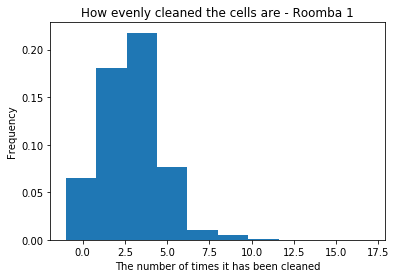

In [146]:
# uncleaned amount
print("uncleaned on average: " + str(sum(uncleaned_1)/(roomba_1.size**2)/200))
# histogram of cleanliness distribution
plt.hist(cleanliness_1, density=True)
plt.title("How evenly cleaned the cells are - Roomba 1")
plt.xlabel("The number of times it has been cleaned")
plt.ylabel("Frequency")
plt.show()

uncleaned on average: 0.02005


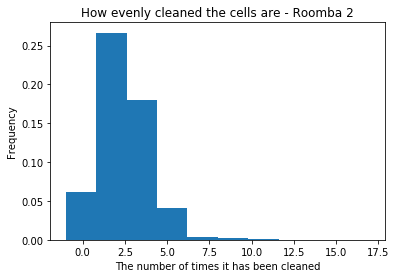

In [148]:
print("uncleaned on average: " + str(sum(uncleaned_2)/(roomba_2.size**2)/200))
plt.hist(cleanliness_2, density=True)
plt.title("How evenly cleaned the cells are - Roomba 2")
plt.xlabel("The number of times it has been cleaned")
plt.ylabel("Frequency")
plt.show()

uncleaned on average: 0.07200000000000001


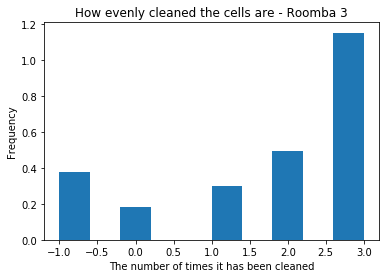

In [149]:
print("uncleaned on average: " + str(sum(uncleaned_3)/(roomba_3.size**2)/200))
plt.hist(cleanliness_3, density=True)
plt.title("How evenly cleaned the cells are - Roomba 3")
plt.xlabel("The number of times it has been cleaned")
plt.ylabel("Frequency")
plt.show()

Text(0, 0.5, 'Frequency')

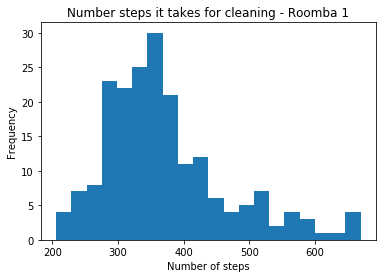

In [153]:
# histogram of number of steps
plt.hist(steps_list1, bins=20)
plt.title("Number steps it takes for cleaning - Roomba 1")
plt.xlabel("Number of steps")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

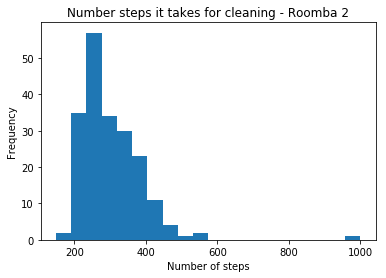

In [154]:
plt.hist(steps_list2, bins=20)
plt.title("Number steps it takes for cleaning - Roomba 2")
plt.xlabel("Number of steps")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

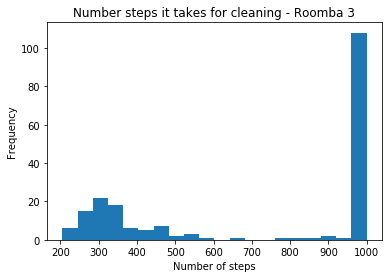

In [155]:
plt.hist(steps_list3, bins=20)
plt.title("Number steps it takes for cleaning - Roomba 3")
plt.xlabel("Number of steps")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

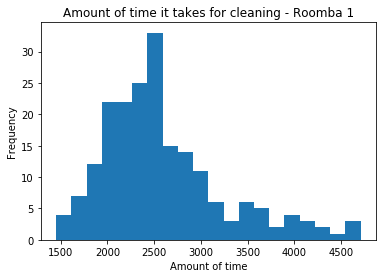

In [156]:
# histogram of amount of time
plt.hist(time_list1, bins = 20)
plt.title("Amount of time it takes for cleaning - Roomba 1")
plt.xlabel("Amount of time")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

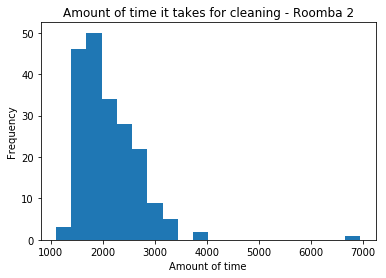

In [157]:
plt.hist(time_list2, bins = 20)
plt.title("Amount of time it takes for cleaning - Roomba 2")
plt.xlabel("Amount of time")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

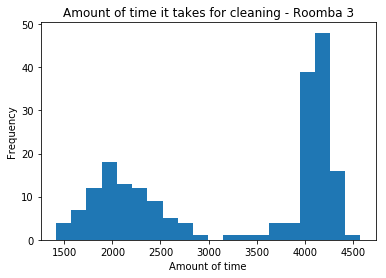

In [158]:
plt.hist(time_list3, bins = 20)
plt.title("Amount of time it takes for cleaning - Roomba 3")
plt.xlabel("Amount of time")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

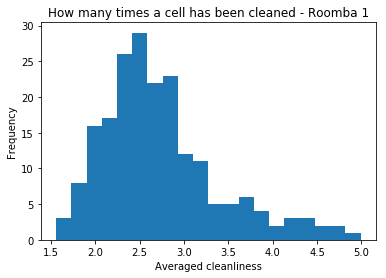

In [159]:
# histogram of averaged cleanliness over the cells
plt.hist(ave_cleaned_list1, bins=20)
plt.title("How many times a cell has been cleaned - Roomba 1")
plt.xlabel("Averaged cleanliness")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

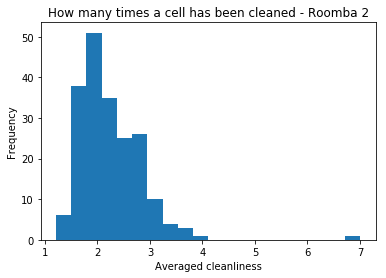

In [160]:
plt.hist(ave_cleaned_list2, bins=20)
plt.title("How many times a cell has been cleaned - Roomba 2")
plt.xlabel("Averaged cleanliness")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

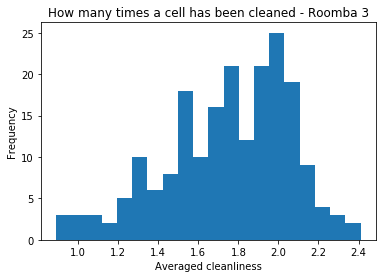

In [161]:
plt.hist(ave_cleaned_list3, bins=20)
plt.title("How many times a cell has been cleaned - Roomba 3")
plt.xlabel("Averaged cleanliness")
plt.ylabel("Frequency")

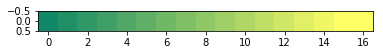

In [162]:
# Visualization of how the roombas work

"""
Cell state scales:
0: has obstacles
1: empty and dirty
2: cleaned once
3: cleaned twice
...
"""
plt.cla()
plt.imshow(np.array([[i for i in range(17)]]), vmin = -1, vmax = 15, cmap = cm.summer)
plt.show()

Step: 0
Updated position: [0 0]
Updated direction: [1 0]


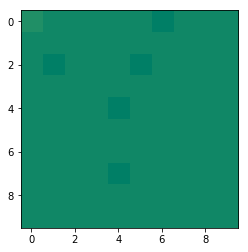

Step: 1
Updated position: [1 0]
Updated direction: [1 0]


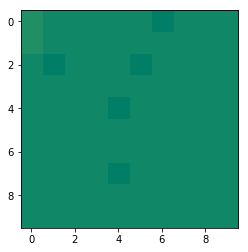

Step: 2
Updated position: [2 0]
Updated direction: [1 0]


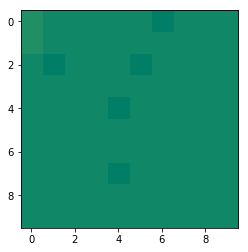

Step: 3
Updated position: [3 0]
Updated direction: [1 0]


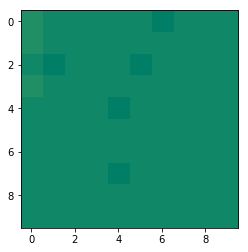

Step: 4
Updated position: [4 0]
Updated direction: [1 0]


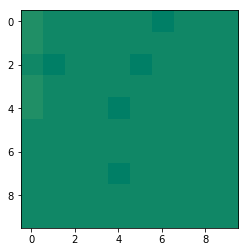

Step: 5
Updated position: [5 0]
Updated direction: [-1  0]


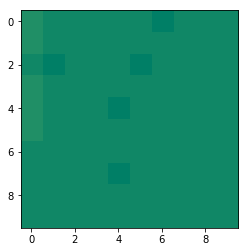

Step: 6
Updated position: [4 0]
Updated direction: [-1  0]


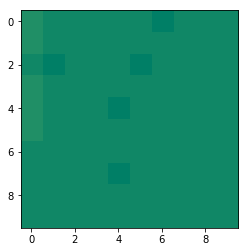

Step: 7
Updated position: [3 0]
Updated direction: [-1  0]


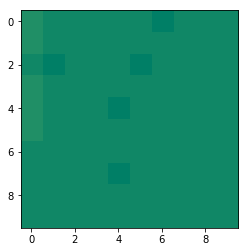

Step: 8
Updated position: [2 0]
Updated direction: [1 0]


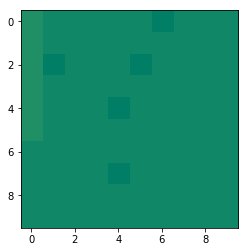

Step: 9
Updated position: [3 0]
Updated direction: [0 1]


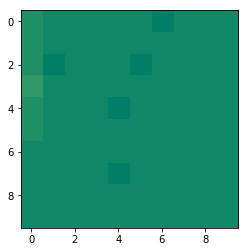

Step: 10
Updated position: [3 1]
Updated direction: [ 0 -1]


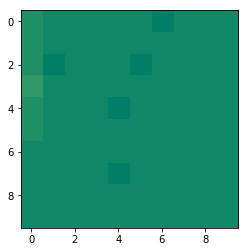

Step: 11
Updated position: [3 0]
Updated direction: [1 0]


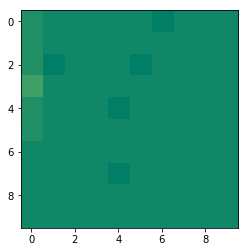

Step: 12
Updated position: [4 0]
Updated direction: [1 0]


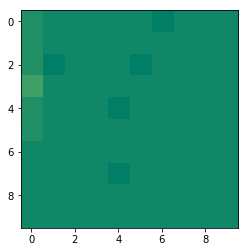

Step: 13
Updated position: [5 0]
Updated direction: [1 0]


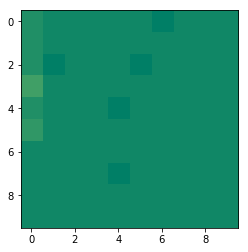

Step: 14
Updated position: [6 0]
Updated direction: [1 0]


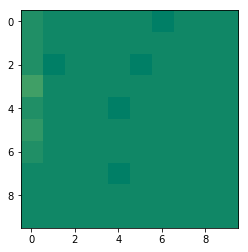

Step: 15
Updated position: [7 0]
Updated direction: [1 0]


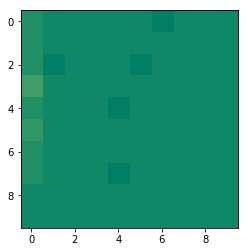

Step: 16
Updated position: [8 0]
Updated direction: [0 1]


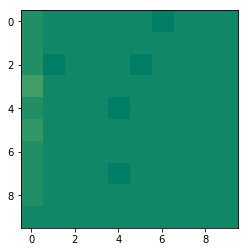

Step: 17
Updated position: [8 1]
Updated direction: [0 1]


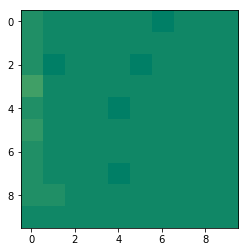

Step: 18
Updated position: [8 2]
Updated direction: [ 0 -1]


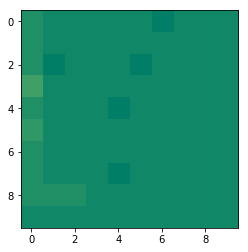

Step: 19
Updated position: [8 1]
Updated direction: [1 0]


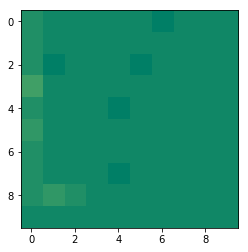

Step: 20
Updated position: [9 1]
Updated direction: [0 1]


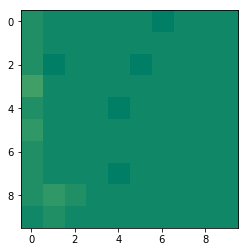

Step: 21
Updated position: [9 2]
Updated direction: [0 1]


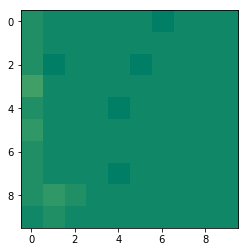

Step: 22
Updated position: [9 3]
Updated direction: [ 0 -1]


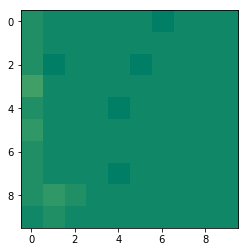

Step: 23
Updated position: [9 2]
Updated direction: [0 1]


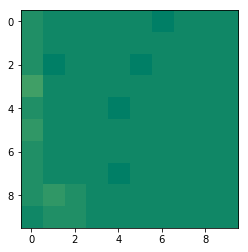

Step: 24
Updated position: [9 3]
Updated direction: [0 1]


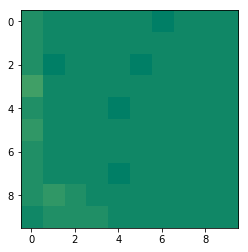

Step: 25
Updated position: [9 4]
Updated direction: [0 1]


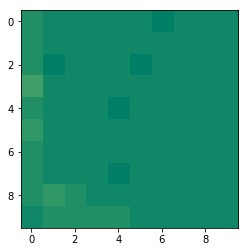

Step: 26
Updated position: [9 5]
Updated direction: [0 1]


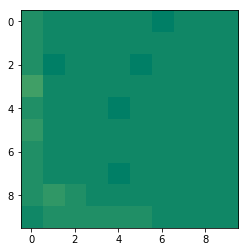

Step: 27
Updated position: [9 6]
Updated direction: [0 1]


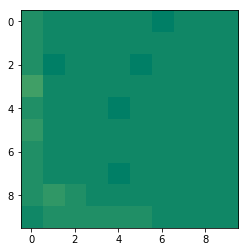

Step: 28
Updated position: [9 7]
Updated direction: [ 0 -1]


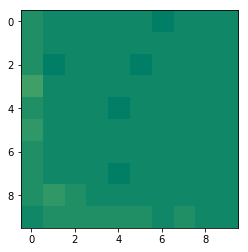

Step: 29
Updated position: [9 6]
Updated direction: [ 0 -1]


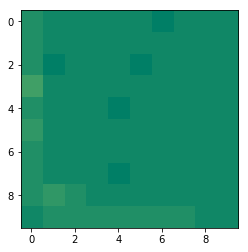

Step: 30
Updated position: [9 5]
Updated direction: [-1  0]


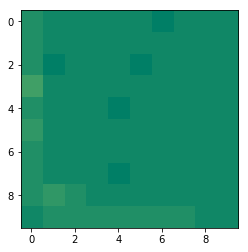

Step: 31
Updated position: [8 5]
Updated direction: [-1  0]


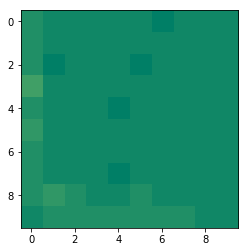

Step: 32
Updated position: [7 5]
Updated direction: [-1  0]


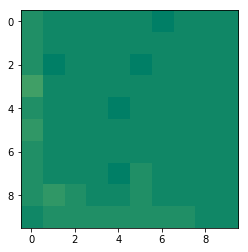

Step: 33
Updated position: [6 5]
Updated direction: [0 1]


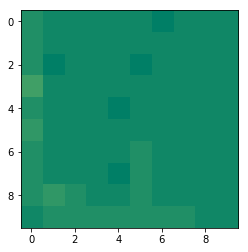

Step: 34
Updated position: [6 6]
Updated direction: [0 1]


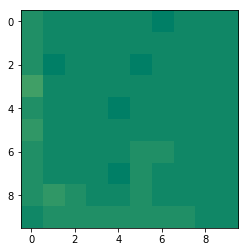

Step: 35
Updated position: [6 7]
Updated direction: [ 0 -1]


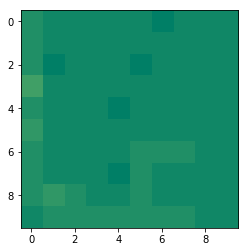

Step: 36
Updated position: [6 6]
Updated direction: [0 1]


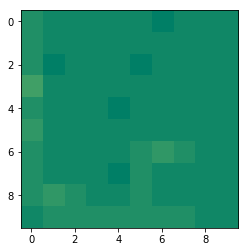

Step: 37
Updated position: [6 7]
Updated direction: [1 0]


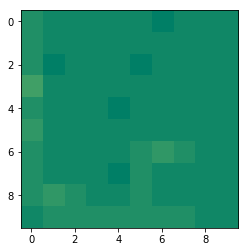

Step: 38
Updated position: [7 7]
Updated direction: [1 0]


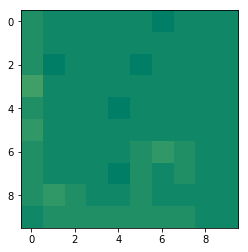

Step: 39
Updated position: [8 7]
Updated direction: [1 0]


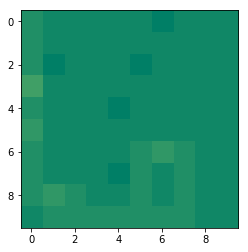

Step: 40
Updated position: [9 7]
Updated direction: [-1  0]


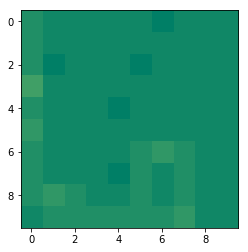

Step: 41
Updated position: [8 7]
Updated direction: [ 0 -1]


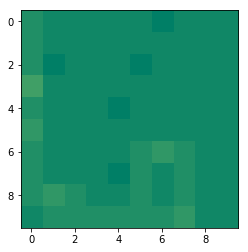

Step: 42
Updated position: [8 6]
Updated direction: [0 1]


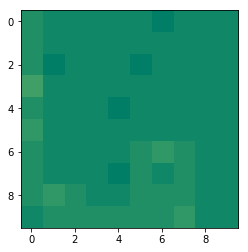

Step: 43
Updated position: [8 7]
Updated direction: [0 1]


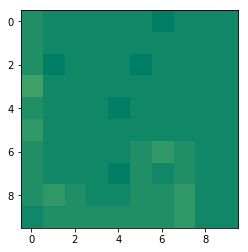

Step: 44
Updated position: [8 8]
Updated direction: [1 0]


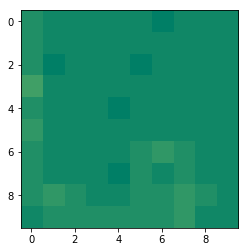

Step: 45
Updated position: [9 8]
Updated direction: [ 0 -1]


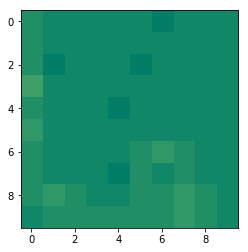

Step: 46
Updated position: [9 7]
Updated direction: [ 0 -1]


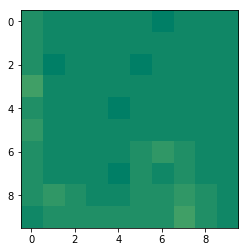

Step: 47
Updated position: [9 6]
Updated direction: [ 0 -1]


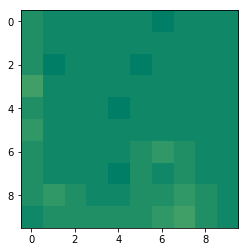

Step: 48
Updated position: [9 5]
Updated direction: [-1  0]


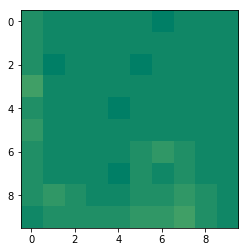

Step: 49
Updated position: [8 5]
Updated direction: [ 0 -1]


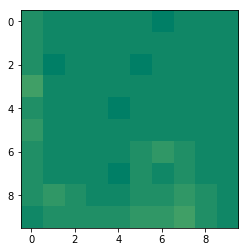

Step: 50
Updated position: [8 4]
Updated direction: [1 0]


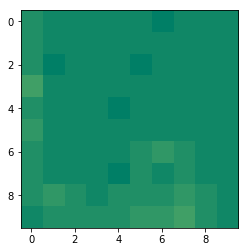

Step: 51
Updated position: [9 4]
Updated direction: [ 0 -1]


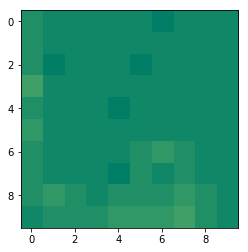

Step: 52
Updated position: [9 3]
Updated direction: [-1  0]


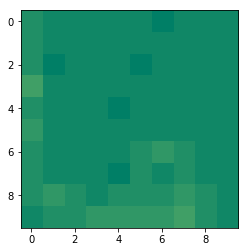

Step: 53
Updated position: [8 3]
Updated direction: [-1  0]


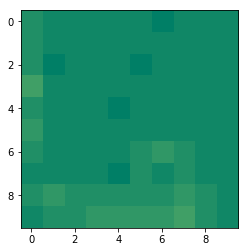

Step: 54
Updated position: [7 3]
Updated direction: [-1  0]


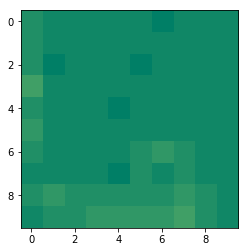

Step: 55
Updated position: [6 3]
Updated direction: [1 0]


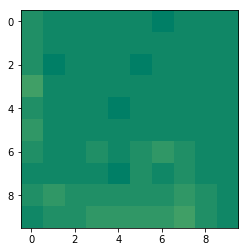

Step: 56
Updated position: [7 3]
Updated direction: [ 0 -1]


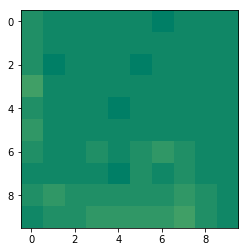

Step: 57
Updated position: [7 2]
Updated direction: [0 1]


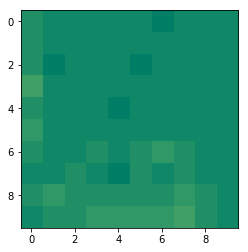

Step: 58
Updated position: [7 3]
Updated direction: [1 0]


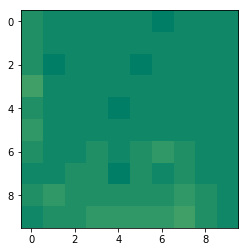

Step: 59
Updated position: [8 3]
Updated direction: [-1  0]


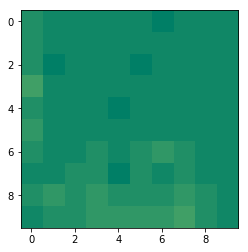

Step: 60
Updated position: [7 3]
Updated direction: [ 0 -1]


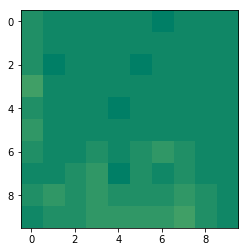

Step: 61
Updated position: [7 2]
Updated direction: [-1  0]


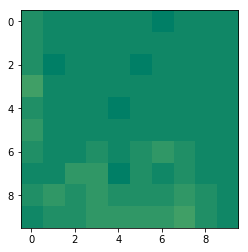

Step: 62
Updated position: [6 2]
Updated direction: [1 0]


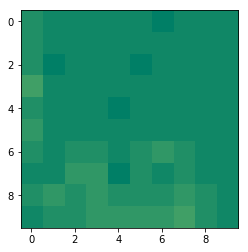

Step: 63
Updated position: [7 2]
Updated direction: [ 0 -1]


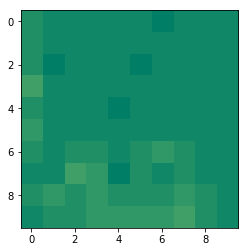

Step: 64
Updated position: [7 1]
Updated direction: [-1  0]


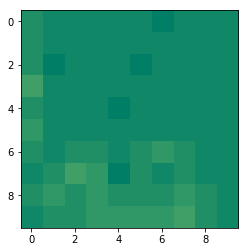

Step: 65
Updated position: [6 1]
Updated direction: [-1  0]


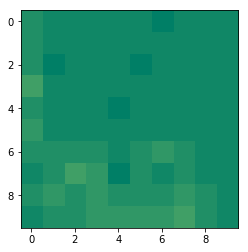

Step: 66
Updated position: [5 1]
Updated direction: [-1  0]


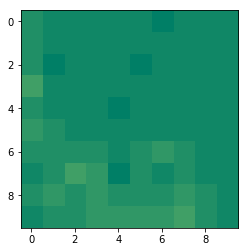

Step: 67
Updated position: [4 1]
Updated direction: [-1  0]


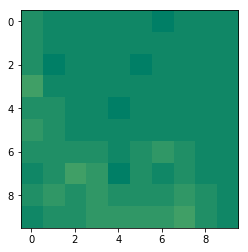

Step: 68
Updated position: [3 1]
Updated direction: [0 1]


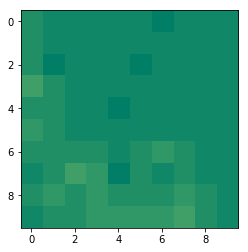

Step: 69
Updated position: [3 2]
Updated direction: [1 0]


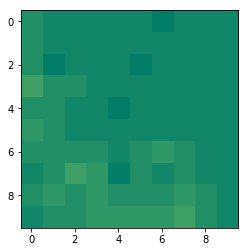

Step: 70
Updated position: [4 2]
Updated direction: [1 0]


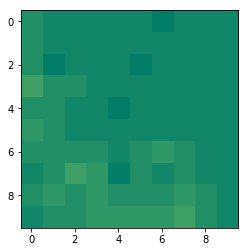

Step: 71
Updated position: [5 2]
Updated direction: [-1  0]


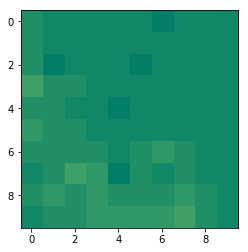

Step: 72
Updated position: [4 2]
Updated direction: [0 1]


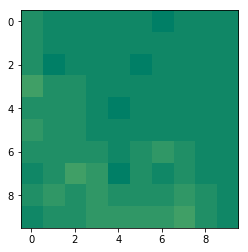

Step: 73
Updated position: [4 3]
Updated direction: [1 0]


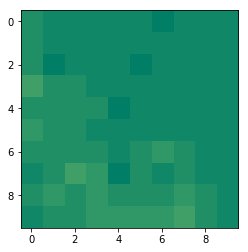

Step: 74
Updated position: [5 3]
Updated direction: [0 1]


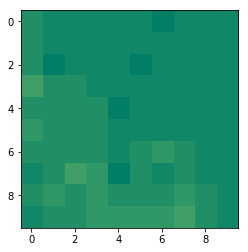

Step: 75
Updated position: [5 4]
Updated direction: [ 0 -1]


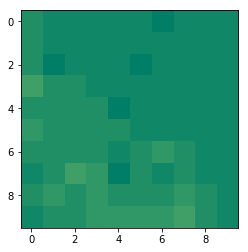

Step: 76
Updated position: [5 3]
Updated direction: [0 1]


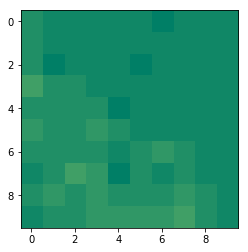

Step: 77
Updated position: [5 4]
Updated direction: [0 1]


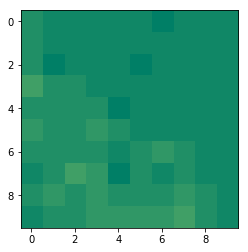

Step: 78
Updated position: [5 5]
Updated direction: [-1  0]


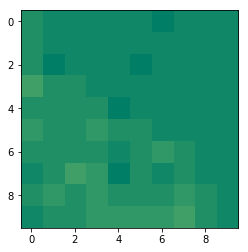

Step: 79
Updated position: [4 5]
Updated direction: [-1  0]


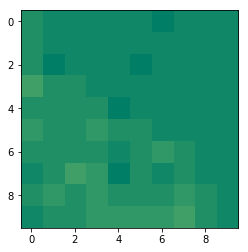

Step: 80
Updated position: [3 5]
Updated direction: [1 0]


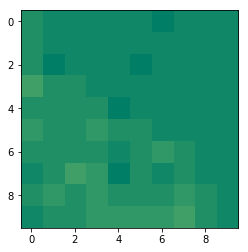

Step: 81
Updated position: [4 5]
Updated direction: [-1  0]


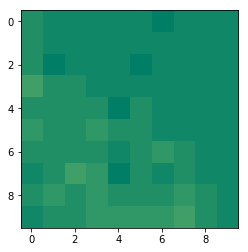

Step: 82
Updated position: [3 5]
Updated direction: [ 0 -1]


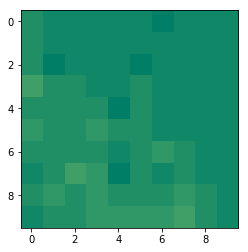

Step: 83
Updated position: [3 4]
Updated direction: [-1  0]


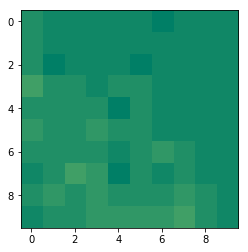

Step: 84
Updated position: [2 4]
Updated direction: [-1  0]


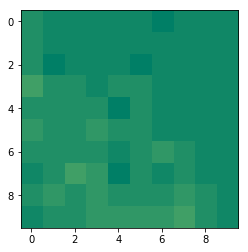

Step: 85
Updated position: [1 4]
Updated direction: [1 0]


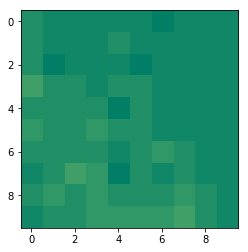

Step: 86
Updated position: [2 4]
Updated direction: [ 0 -1]


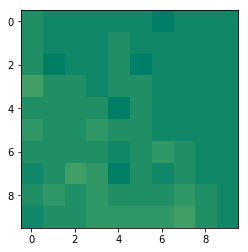

Step: 87
Updated position: [2 3]
Updated direction: [ 0 -1]


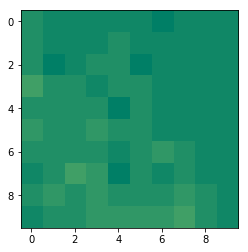

Step: 88
Updated position: [2 2]
Updated direction: [-1  0]


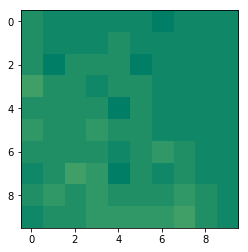

Step: 89
Updated position: [1 2]
Updated direction: [ 0 -1]


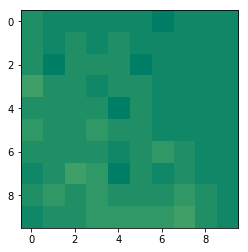

Step: 90
Updated position: [1 1]
Updated direction: [-1  0]


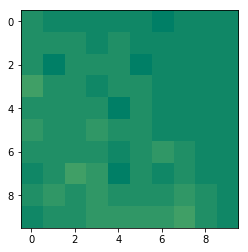

Step: 91
Updated position: [0 1]
Updated direction: [0 1]


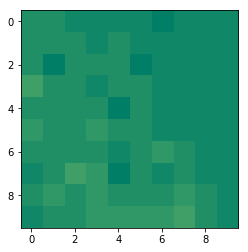

Step: 92
Updated position: [0 2]
Updated direction: [0 1]


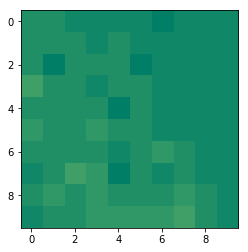

Step: 93
Updated position: [0 3]
Updated direction: [1 0]


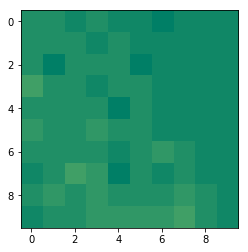

Step: 94
Updated position: [1 3]
Updated direction: [1 0]


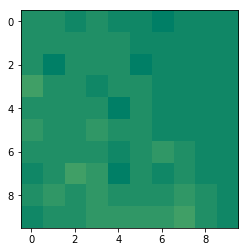

Step: 95
Updated position: [2 3]
Updated direction: [1 0]


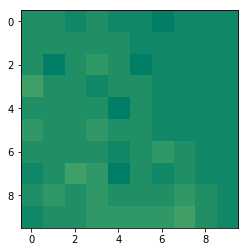

Step: 96
Updated position: [3 3]
Updated direction: [1 0]


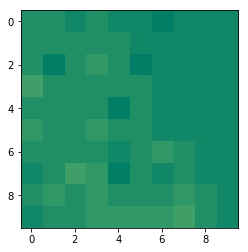

Step: 97
Updated position: [4 3]
Updated direction: [-1  0]


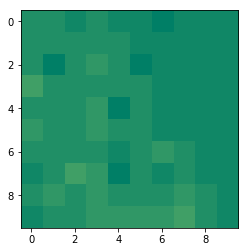

Step: 98
Updated position: [3 3]
Updated direction: [ 0 -1]


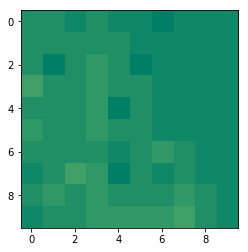

Step: 99
Updated position: [3 2]
Updated direction: [ 0 -1]


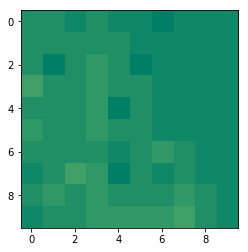

Step: 100
Updated position: [3 1]
Updated direction: [1 0]


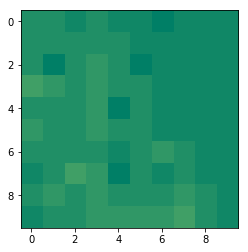

Step: 101
Updated position: [4 1]
Updated direction: [1 0]


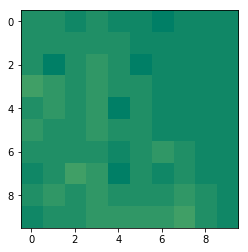

Step: 102
Updated position: [5 1]
Updated direction: [1 0]


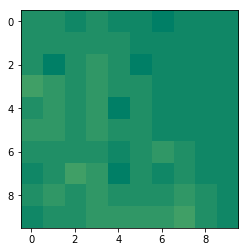

Step: 103
Updated position: [6 1]
Updated direction: [1 0]


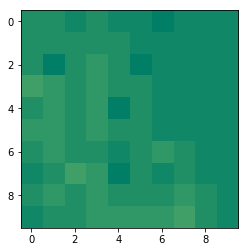

Step: 104
Updated position: [7 1]
Updated direction: [-1  0]


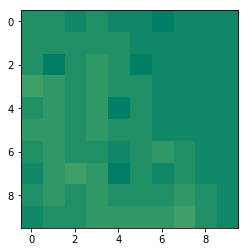

Step: 105
Updated position: [6 1]
Updated direction: [-1  0]


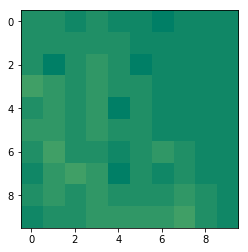

Step: 106
Updated position: [5 1]
Updated direction: [0 1]


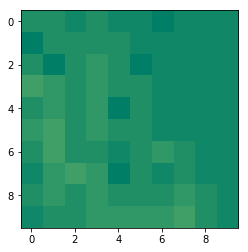

Step: 107
Updated position: [5 2]
Updated direction: [1 0]


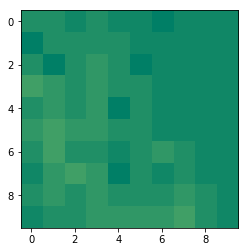

Step: 108
Updated position: [6 2]
Updated direction: [0 1]


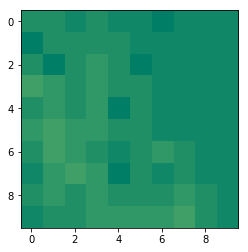

Step: 109
Updated position: [6 3]
Updated direction: [ 0 -1]


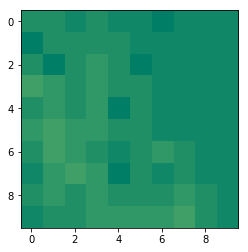

Step: 110
Updated position: [6 2]
Updated direction: [0 1]


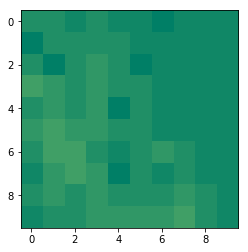

Step: 111
Updated position: [6 3]
Updated direction: [-1  0]


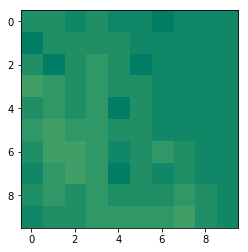

Step: 112
Updated position: [5 3]
Updated direction: [0 1]


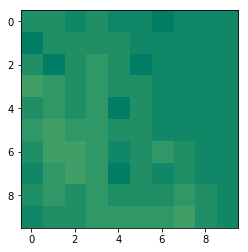

Step: 113
Updated position: [5 4]
Updated direction: [0 1]


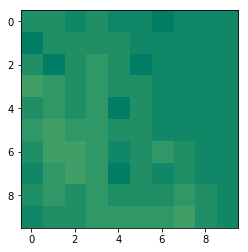

Step: 114
Updated position: [5 5]
Updated direction: [-1  0]


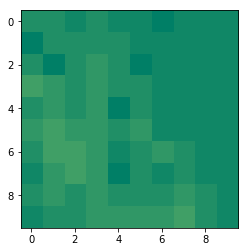

Step: 115
Updated position: [4 5]
Updated direction: [0 1]


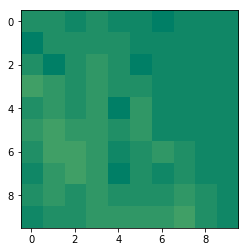

Step: 116
Updated position: [4 6]
Updated direction: [1 0]


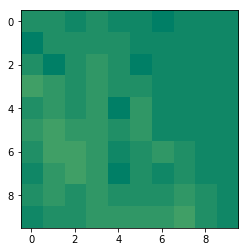

Step: 117
Updated position: [5 6]
Updated direction: [-1  0]


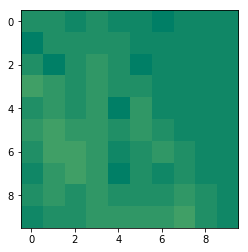

Step: 118
Updated position: [4 6]
Updated direction: [-1  0]


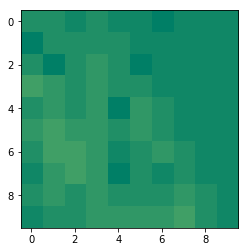

Step: 119
Updated position: [3 6]
Updated direction: [-1  0]


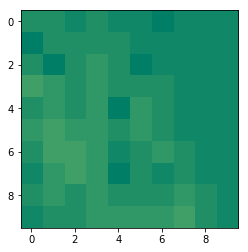

Step: 120
Updated position: [2 6]
Updated direction: [-1  0]


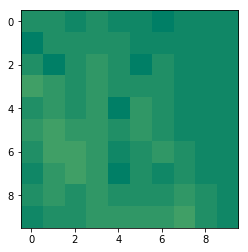

Step: 121
Updated position: [1 6]
Updated direction: [0 1]


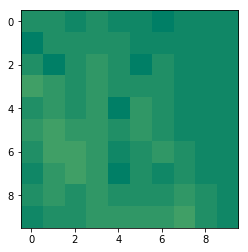

Step: 122
Updated position: [1 7]
Updated direction: [1 0]


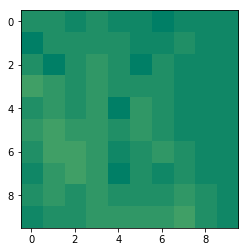

Step: 123
Updated position: [2 7]
Updated direction: [1 0]


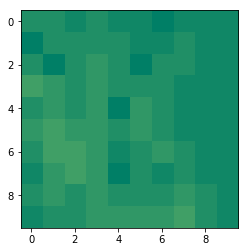

Step: 124
Updated position: [3 7]
Updated direction: [1 0]


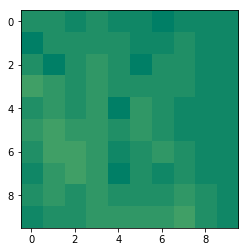

Step: 125
Updated position: [4 7]
Updated direction: [1 0]


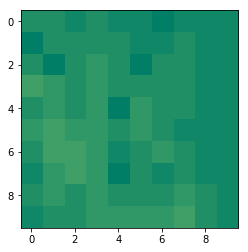

Step: 126
Updated position: [5 7]
Updated direction: [0 1]


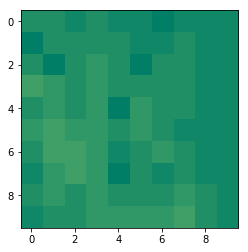

Step: 127
Updated position: [5 8]
Updated direction: [1 0]


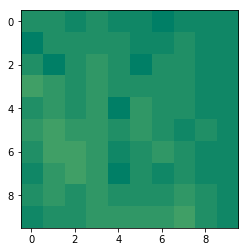

Step: 128
Updated position: [6 8]
Updated direction: [ 0 -1]


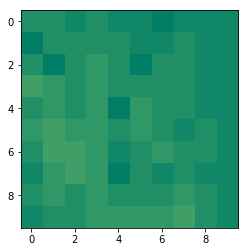

Step: 129
Updated position: [6 7]
Updated direction: [ 0 -1]


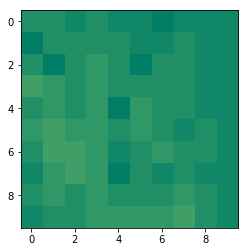

Step: 130
Updated position: [6 6]
Updated direction: [1 0]


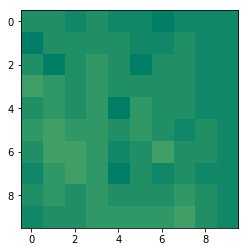

Step: 131
Updated position: [7 6]
Updated direction: [0 1]


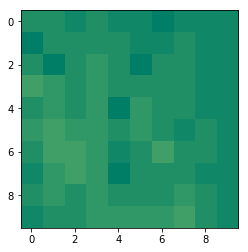

Step: 132
Updated position: [7 7]
Updated direction: [0 1]


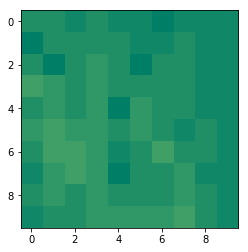

Step: 133
Updated position: [7 8]
Updated direction: [0 1]


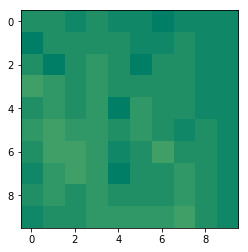

Step: 134
Updated position: [7 9]
Updated direction: [1 0]


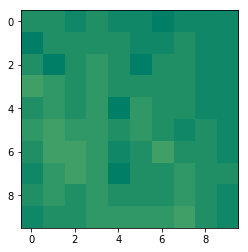

Step: 135
Updated position: [8 9]
Updated direction: [1 0]


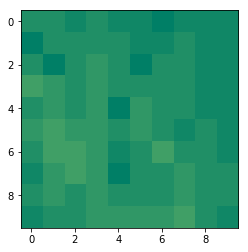

Step: 136
Updated position: [9 9]
Updated direction: [-1  0]


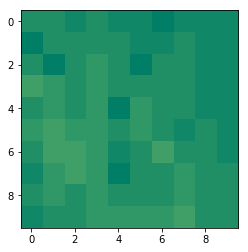

Step: 137
Updated position: [8 9]
Updated direction: [-1  0]


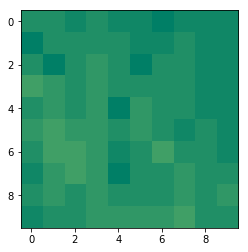

Step: 138
Updated position: [7 9]
Updated direction: [1 0]


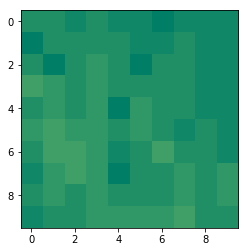

Step: 139
Updated position: [8 9]
Updated direction: [-1  0]


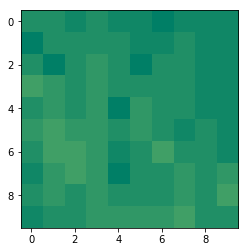

Step: 140
Updated position: [7 9]
Updated direction: [-1  0]


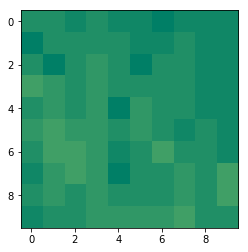

Step: 141
Updated position: [6 9]
Updated direction: [-1  0]


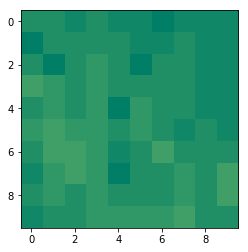

Step: 142
Updated position: [5 9]
Updated direction: [-1  0]


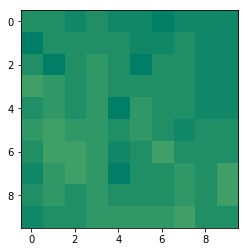

Step: 143
Updated position: [4 9]
Updated direction: [-1  0]


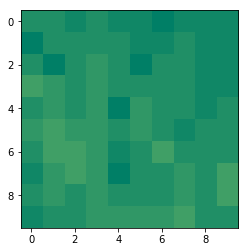

Step: 144
Updated position: [3 9]
Updated direction: [-1  0]


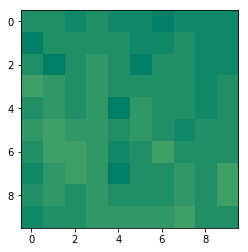

Step: 145
Updated position: [2 9]
Updated direction: [-1  0]


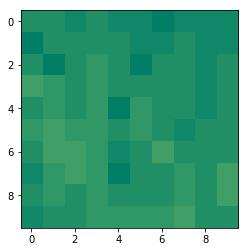

Step: 146
Updated position: [1 9]
Updated direction: [-1  0]


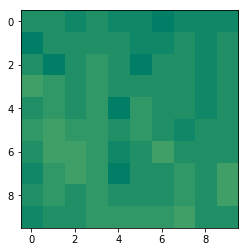

Step: 147
Updated position: [0 9]
Updated direction: [ 0 -1]


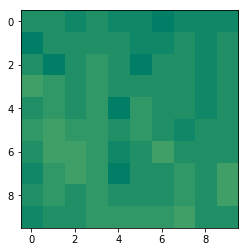

Step: 148
Updated position: [0 8]
Updated direction: [0 1]


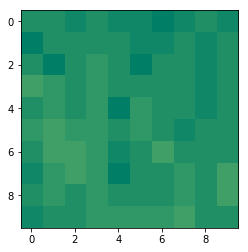

Step: 149
Updated position: [0 9]
Updated direction: [ 0 -1]


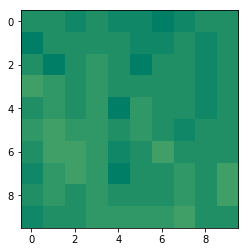

Step: 150
Updated position: [0 8]
Updated direction: [ 0 -1]


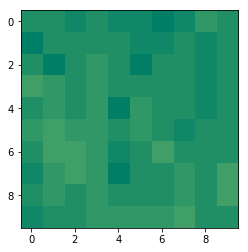

Step: 151
Updated position: [0 7]
Updated direction: [1 0]


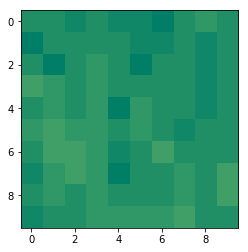

Step: 152
Updated position: [1 7]
Updated direction: [ 0 -1]


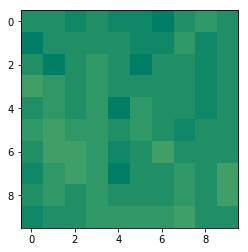

Step: 153
Updated position: [1 6]
Updated direction: [ 0 -1]


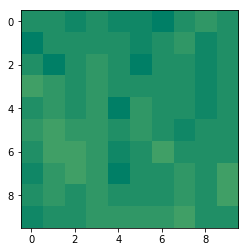

Step: 154
Updated position: [1 5]
Updated direction: [-1  0]


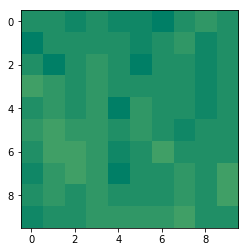

Step: 155
Updated position: [0 5]
Updated direction: [ 0 -1]


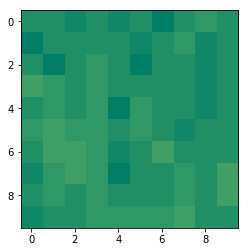

Step: 156
Updated position: [0 4]
Updated direction: [0 1]


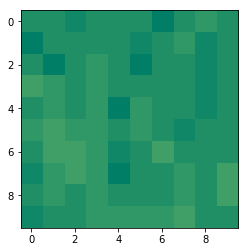

Step: 157
Updated position: [0 5]
Updated direction: [1 0]


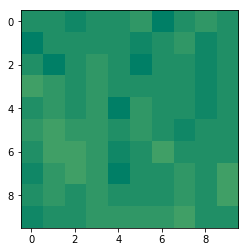

Step: 158
Updated position: [1 5]
Updated direction: [ 0 -1]


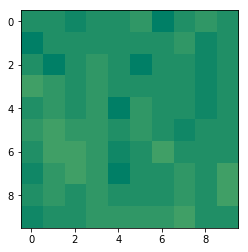

Step: 159
Updated position: [1 4]
Updated direction: [1 0]


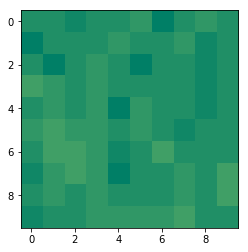

Step: 160
Updated position: [2 4]
Updated direction: [-1  0]


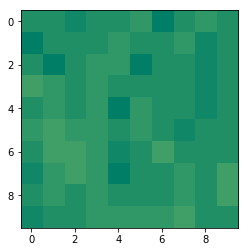

Step: 161
Updated position: [1 4]
Updated direction: [-1  0]


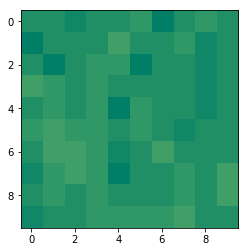

Step: 162
Updated position: [0 4]
Updated direction: [0 1]


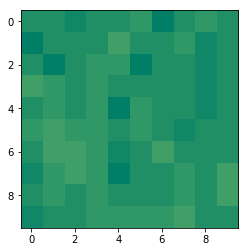

Step: 163
Updated position: [0 5]
Updated direction: [1 0]


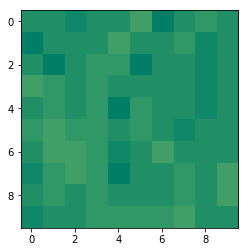

Step: 164
Updated position: [1 5]
Updated direction: [0 1]


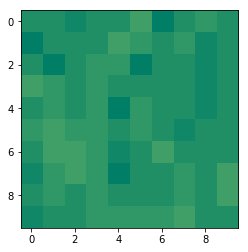

Step: 165
Updated position: [1 6]
Updated direction: [1 0]


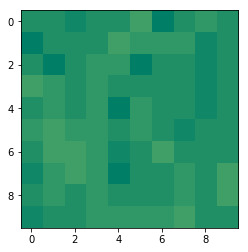

Step: 166
Updated position: [2 6]
Updated direction: [1 0]


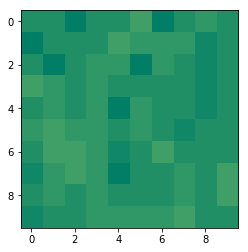

Step: 167
Updated position: [3 6]
Updated direction: [-1  0]


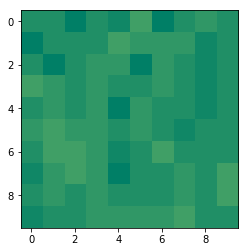

Step: 168
Updated position: [2 6]
Updated direction: [1 0]


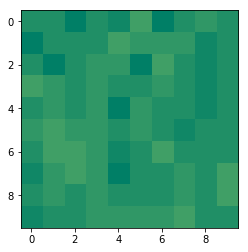

Step: 169
Updated position: [3 6]
Updated direction: [1 0]


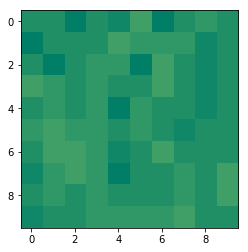

Step: 170
Updated position: [4 6]
Updated direction: [1 0]


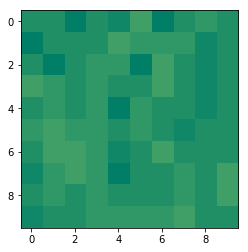

Step: 171
Updated position: [5 6]
Updated direction: [0 1]


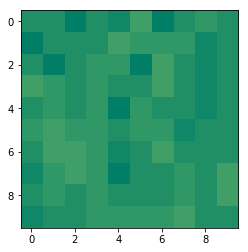

Step: 172
Updated position: [5 7]
Updated direction: [1 0]


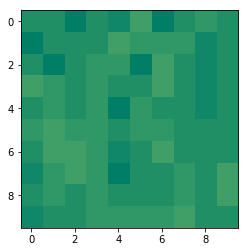

Step: 173
Updated position: [6 7]
Updated direction: [ 0 -1]


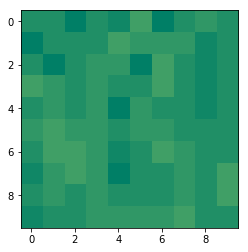

Step: 174
Updated position: [6 6]
Updated direction: [1 0]


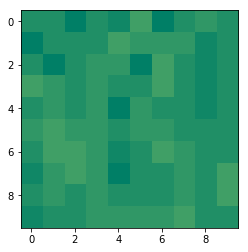

Step: 175
Updated position: [7 6]
Updated direction: [-1  0]


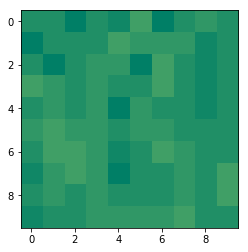

Step: 176
Updated position: [6 6]
Updated direction: [1 0]


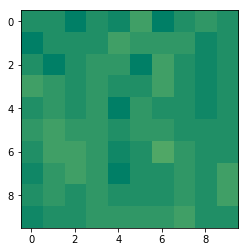

Step: 177
Updated position: [7 6]
Updated direction: [1 0]


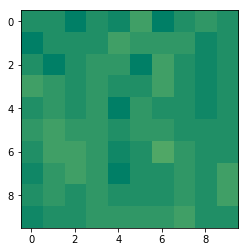

Step: 178
Updated position: [8 6]
Updated direction: [1 0]


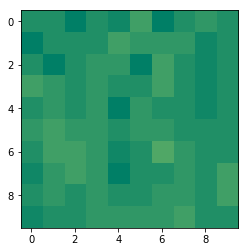

Step: 179
Updated position: [9 6]
Updated direction: [ 0 -1]


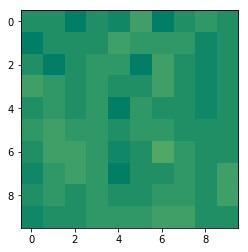

Step: 180
Updated position: [9 5]
Updated direction: [-1  0]


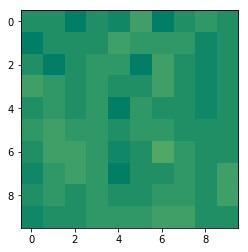

Step: 181
Updated position: [8 5]
Updated direction: [-1  0]


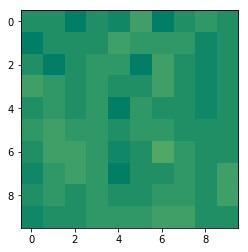

Step: 182
Updated position: [7 5]
Updated direction: [1 0]


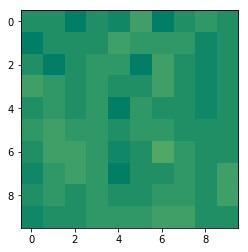

Step: 183
Updated position: [8 5]
Updated direction: [1 0]


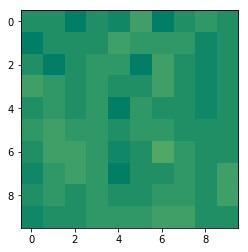

Step: 184
Updated position: [9 5]
Updated direction: [0 1]


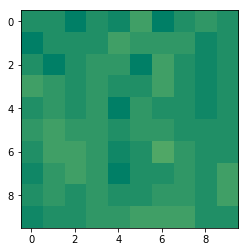

Step: 185
Updated position: [9 6]
Updated direction: [-1  0]


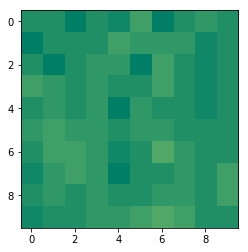

Step: 186
Updated position: [8 6]
Updated direction: [-1  0]


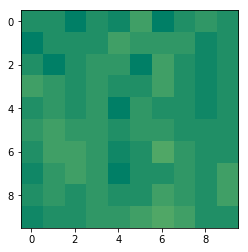

Step: 187
Updated position: [7 6]
Updated direction: [-1  0]


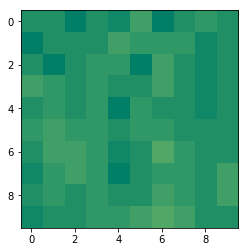

Step: 188
Updated position: [6 6]
Updated direction: [ 0 -1]


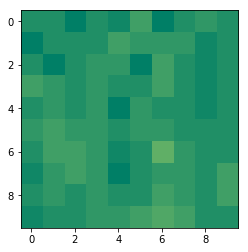

Step: 189
Updated position: [6 5]
Updated direction: [ 0 -1]


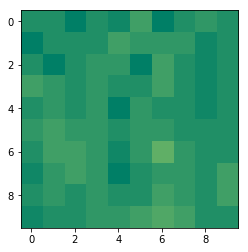

Step: 190
Updated position: [6 4]
Updated direction: [-1  0]


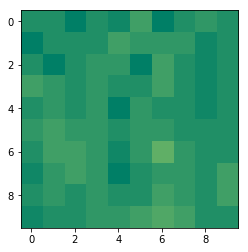

Step: 191
Updated position: [5 4]
Updated direction: [1 0]


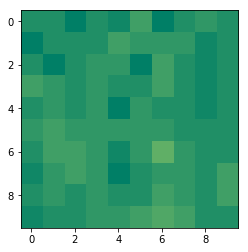

Step: 192
Updated position: [6 4]
Updated direction: [-1  0]


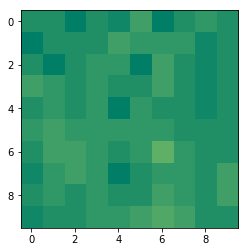

Step: 193
Updated position: [5 4]
Updated direction: [1 0]


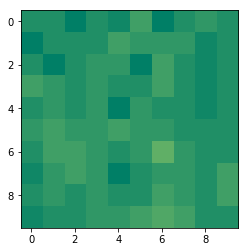

Step: 194
Updated position: [6 4]
Updated direction: [-1  0]


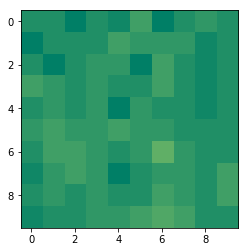

Step: 195
Updated position: [5 4]
Updated direction: [1 0]


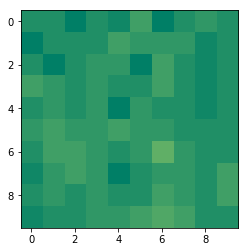

Step: 196
Updated position: [6 4]
Updated direction: [ 0 -1]


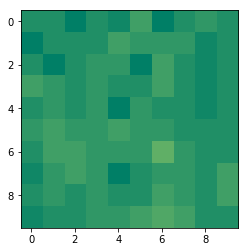

Step: 197
Updated position: [6 3]
Updated direction: [1 0]


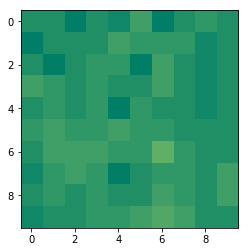

Step: 198
Updated position: [7 3]
Updated direction: [1 0]


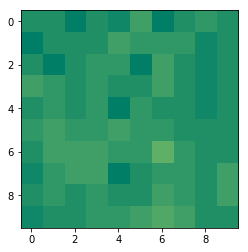

Step: 199
Updated position: [8 3]
Updated direction: [ 0 -1]


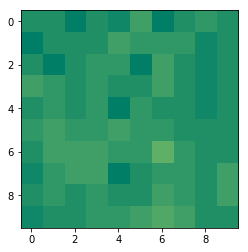

Step: 200
Updated position: [8 2]
Updated direction: [1 0]


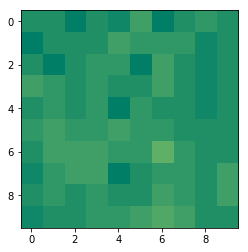

Step: 201
Updated position: [9 2]
Updated direction: [ 0 -1]


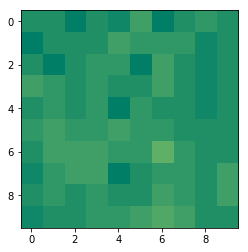

Step: 202
Updated position: [9 1]
Updated direction: [ 0 -1]


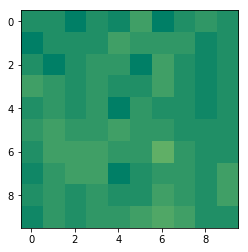

Step: 203
Updated position: [9 0]
Updated direction: [-1  0]


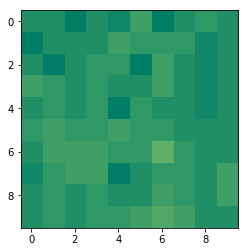

Step: 204
Updated position: [8 0]
Updated direction: [1 0]


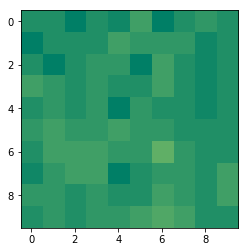

Step: 205
Updated position: [9 0]
Updated direction: [-1  0]


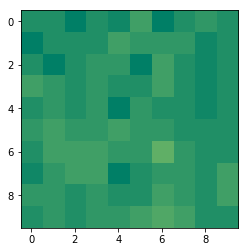

Step: 206
Updated position: [8 0]
Updated direction: [-1  0]


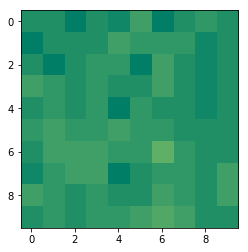

Step: 207
Updated position: [7 0]
Updated direction: [-1  0]


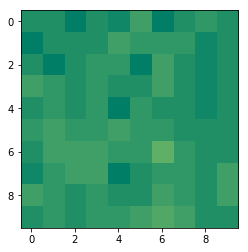

Step: 208
Updated position: [6 0]
Updated direction: [0 1]


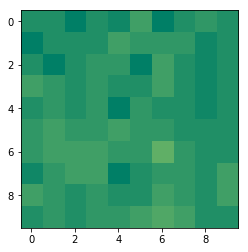

Step: 209
Updated position: [6 1]
Updated direction: [1 0]


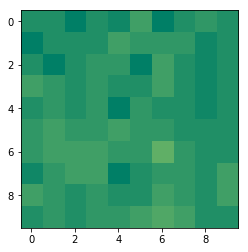

Step: 210
Updated position: [7 1]
Updated direction: [ 0 -1]


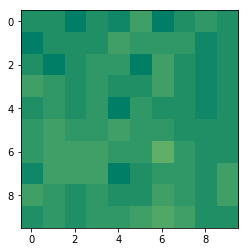

Step: 211
Updated position: [7 0]
Updated direction: [-1  0]


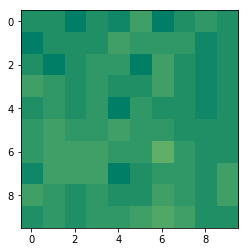

Step: 212
Updated position: [6 0]
Updated direction: [1 0]


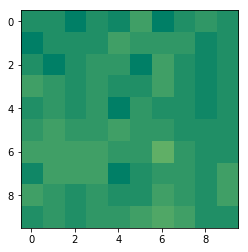

Step: 213
Updated position: [7 0]
Updated direction: [0 1]


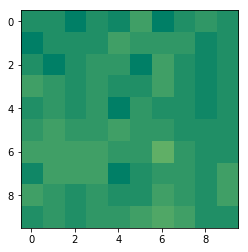

Step: 214
Updated position: [7 1]
Updated direction: [ 0 -1]


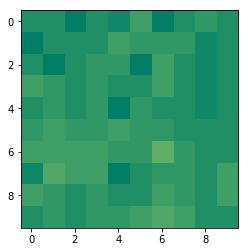

Step: 215
Updated position: [7 0]
Updated direction: [0 1]


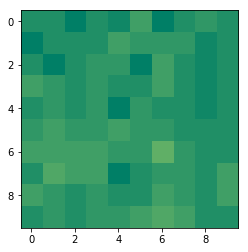

Step: 216
Updated position: [7 1]
Updated direction: [0 1]


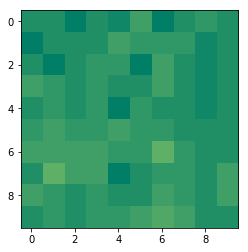

Step: 217
Updated position: [7 2]
Updated direction: [1 0]


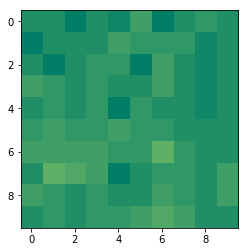

Step: 218
Updated position: [8 2]
Updated direction: [0 1]


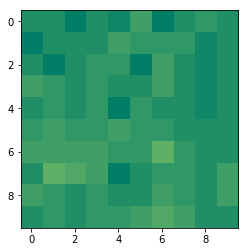

Step: 219
Updated position: [8 3]
Updated direction: [ 0 -1]


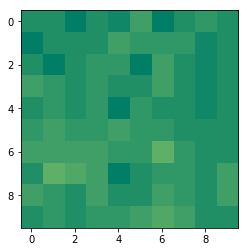

Step: 220
Updated position: [8 2]
Updated direction: [1 0]


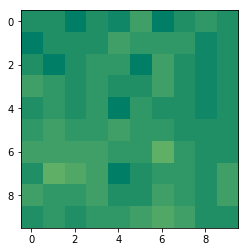

Step: 221
Updated position: [9 2]
Updated direction: [-1  0]


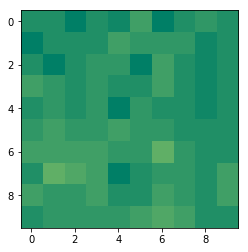

Step: 222
Updated position: [8 2]
Updated direction: [1 0]


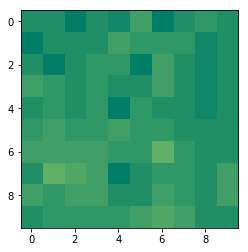

Step: 223
Updated position: [9 2]
Updated direction: [ 0 -1]


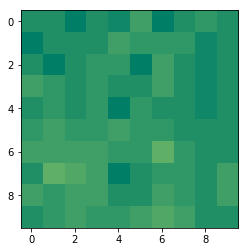

Step: 224
Updated position: [9 1]
Updated direction: [ 0 -1]


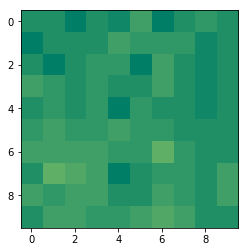

Step: 225
Updated position: [9 0]
Updated direction: [-1  0]


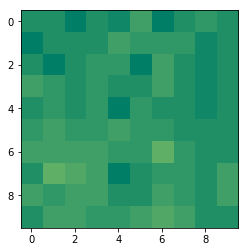

Step: 226
Updated position: [8 0]
Updated direction: [-1  0]


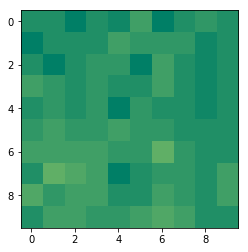

Step: 227
Updated position: [7 0]
Updated direction: [1 0]


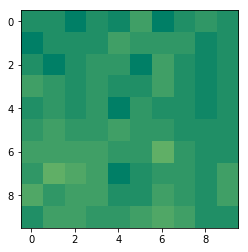

Step: 228
Updated position: [8 0]
Updated direction: [0 1]


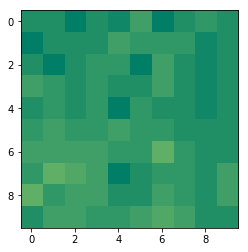

Step: 229
Updated position: [8 1]
Updated direction: [1 0]


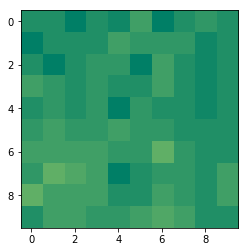

Step: 230
Updated position: [9 1]
Updated direction: [ 0 -1]


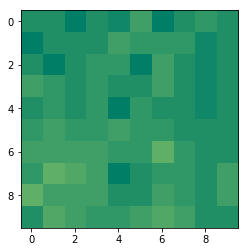

Step: 231
Updated position: [9 0]
Updated direction: [0 1]


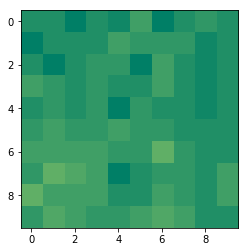

Step: 232
Updated position: [9 1]
Updated direction: [0 1]


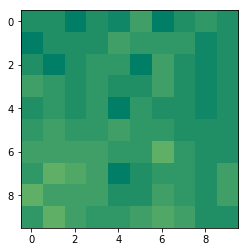

Step: 233
Updated position: [9 2]
Updated direction: [0 1]


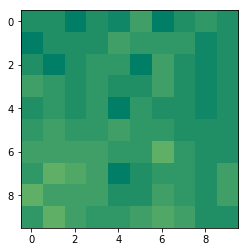

Step: 234
Updated position: [9 3]
Updated direction: [-1  0]


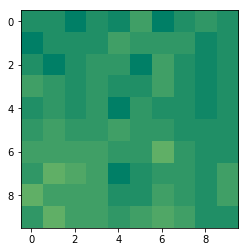

Step: 235
Updated position: [8 3]
Updated direction: [0 1]


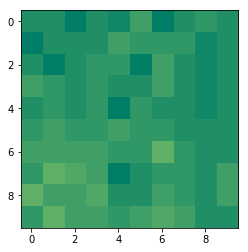

Step: 236
Updated position: [8 4]
Updated direction: [0 1]


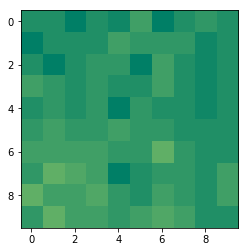

Step: 237
Updated position: [8 5]
Updated direction: [-1  0]


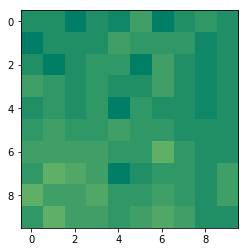

Step: 238
Updated position: [7 5]
Updated direction: [1 0]


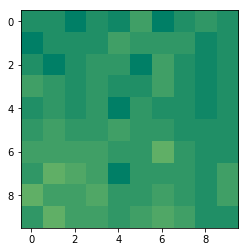

Step: 239
Updated position: [8 5]
Updated direction: [0 1]


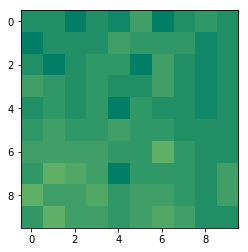

Step: 240
Updated position: [8 6]
Updated direction: [-1  0]


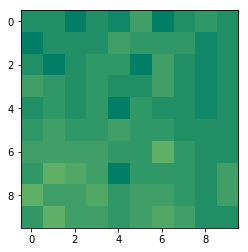

Step: 241
Updated position: [7 6]
Updated direction: [0 1]


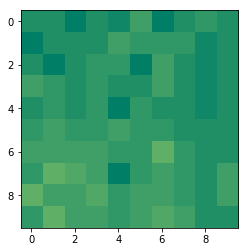

Step: 242
Updated position: [7 7]
Updated direction: [0 1]


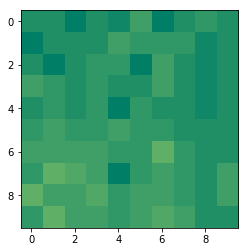

Step: 243
Updated position: [7 8]
Updated direction: [-1  0]


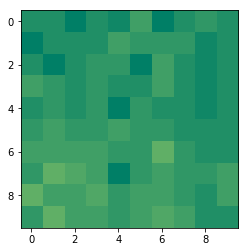

Step: 244
Updated position: [6 8]
Updated direction: [-1  0]


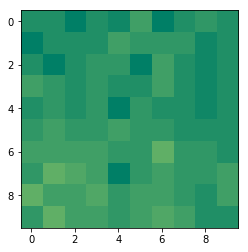

Step: 245
Updated position: [5 8]
Updated direction: [-1  0]


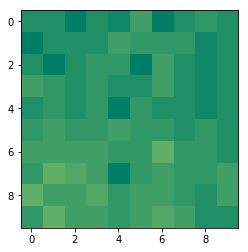

Step: 246
Updated position: [4 8]
Updated direction: [0 1]


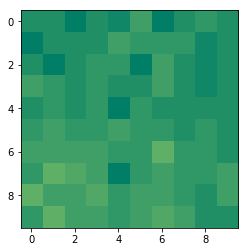

Step: 247
Updated position: [4 9]
Updated direction: [-1  0]


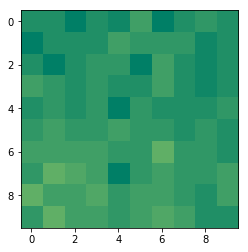

Step: 248
Updated position: [3 9]
Updated direction: [ 0 -1]


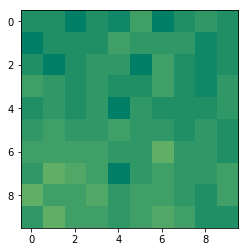

Step: 249
Updated position: [3 8]
Updated direction: [-1  0]


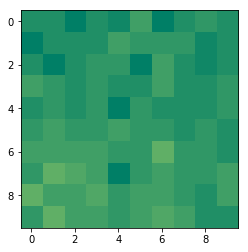

Step: 250
Updated position: [2 8]
Updated direction: [1 0]


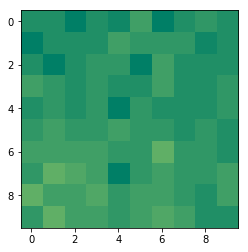

Total amount of time: 1733


In [3]:
# Visualization of the floor - Roomba 1
roomba_1 = RoombaSimulation(0.05, 0.05, 0.05, 0.05, 0.8, 10)
roomba_1.initialize()
steps_1 = 0
while len(np.where(roomba_1.config == 0)[0]) > 0.02*roomba_1.size**2 and steps_1 < 1000:
    print("Step: " + str(steps_1))
    roomba_1.cell_change()
    print("Updated position: " + str(roomba_1.pos))
    roomba_1.roomba_1()
    print("Updated direction: " + str(roomba_1.current_dir))
    steps_1 += 1
    plt.cla()
    plt.imshow(roomba_1.config, vmin = -1, vmax = 15, cmap = cm.summer)
    plt.show()
print("Total amount of time: " + str(roomba_1.T))


Step: 0
Updated position: [7 7]
Updated direction: [1 0]


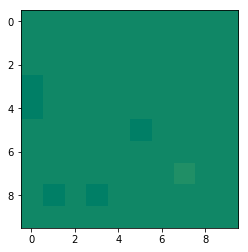

Step: 1
Updated position: [8 7]
Updated direction: [1 0]


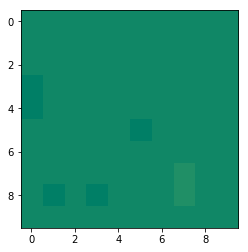

Step: 2
Updated position: [9 7]
Updated direction: [ 0 -1]


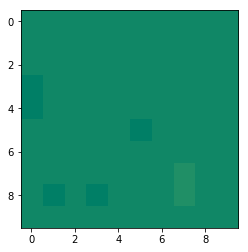

Step: 3
Updated position: [9 6]
Updated direction: [ 0 -1]


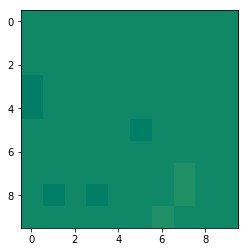

Step: 4
Updated position: [9 5]
Updated direction: [ 0 -1]


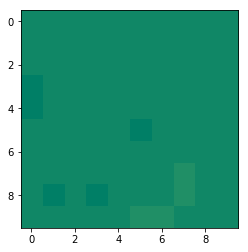

Step: 5
Updated position: [9 4]
Updated direction: [ 0 -1]


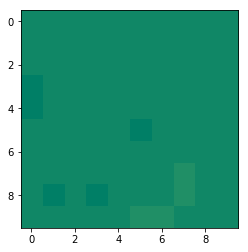

Step: 6
Updated position: [9 3]
Updated direction: [ 0 -1]


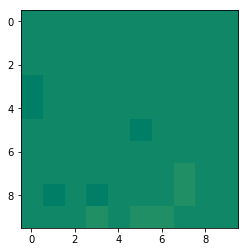

Step: 7
Updated position: [9 2]
Updated direction: [ 0 -1]


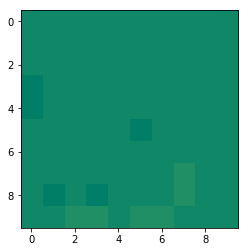

Step: 8
Updated position: [9 1]
Updated direction: [ 0 -1]


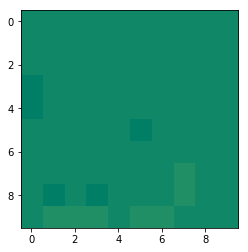

Step: 9
Updated position: [9 0]
Updated direction: [-1  0]


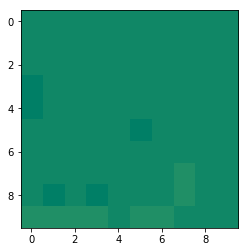

Step: 10
Updated position: [8 0]
Updated direction: [-1  0]


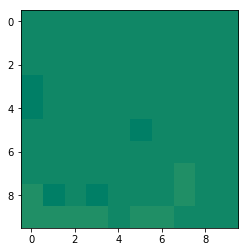

Step: 11
Updated position: [7 0]
Updated direction: [-1  0]


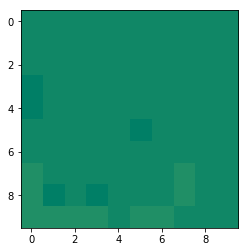

Step: 12
Updated position: [6 0]
Updated direction: [-1  0]


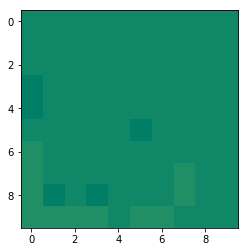

Step: 13
Updated position: [5 0]
Updated direction: [1 0]


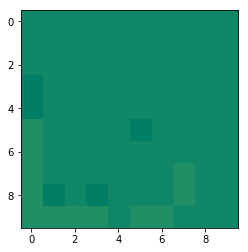

Step: 14
Updated position: [6 0]
Updated direction: [-1  0]


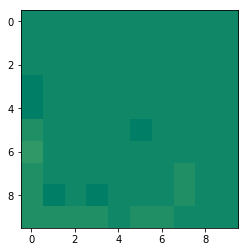

Step: 15
Updated position: [5 0]
Updated direction: [1 0]


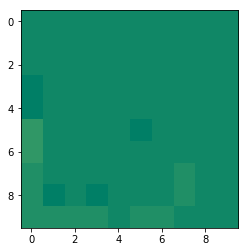

Step: 16
Updated position: [6 0]
Updated direction: [0 1]


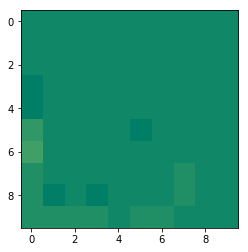

Step: 17
Updated position: [6 1]
Updated direction: [0 1]


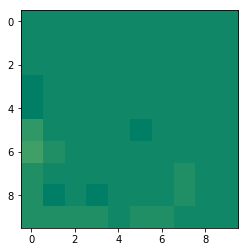

Step: 18
Updated position: [6 2]
Updated direction: [0 1]


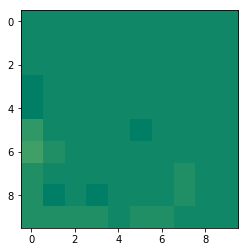

Step: 19
Updated position: [6 3]
Updated direction: [0 1]


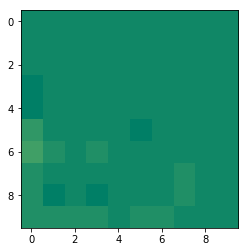

Step: 20
Updated position: [6 4]
Updated direction: [0 1]


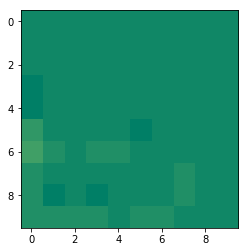

Step: 21
Updated position: [6 5]
Updated direction: [0 1]


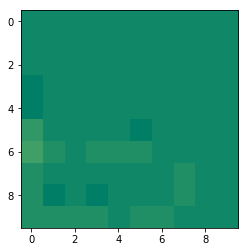

Step: 22
Updated position: [6 6]
Updated direction: [0 1]


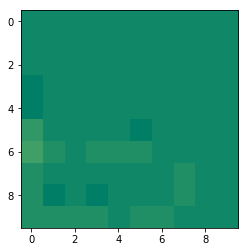

Step: 23
Updated position: [6 7]
Updated direction: [0 1]


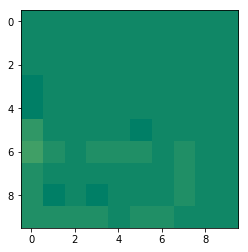

Step: 24
Updated position: [6 8]
Updated direction: [0 1]


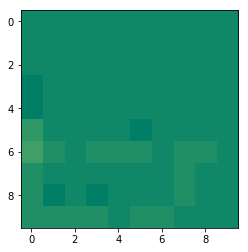

Step: 25
Updated position: [6 9]
Updated direction: [1 0]


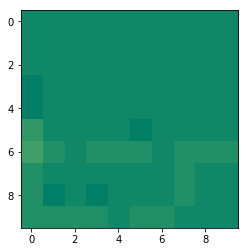

Step: 26
Updated position: [7 9]
Updated direction: [1 0]


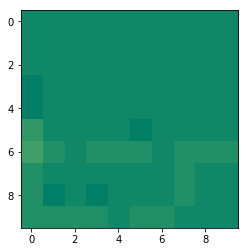

Step: 27
Updated position: [8 9]
Updated direction: [1 0]


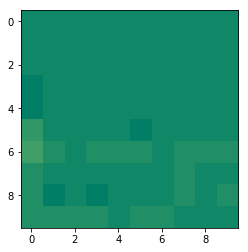

Step: 28
Updated position: [9 9]
Updated direction: [ 0 -1]


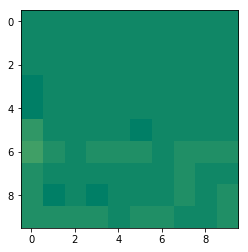

Step: 29
Updated position: [9 8]
Updated direction: [ 0 -1]


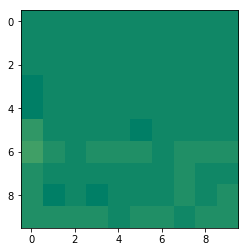

Step: 30
Updated position: [9 7]
Updated direction: [ 0 -1]


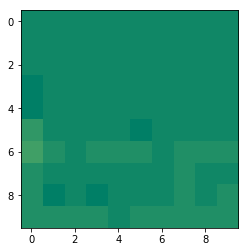

Step: 31
Updated position: [9 6]
Updated direction: [-1  0]


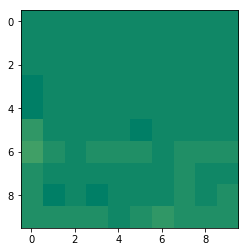

Step: 32
Updated position: [8 6]
Updated direction: [-1  0]


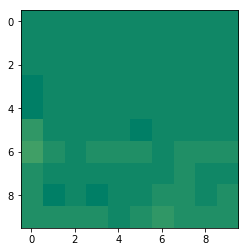

Step: 33
Updated position: [7 6]
Updated direction: [-1  0]


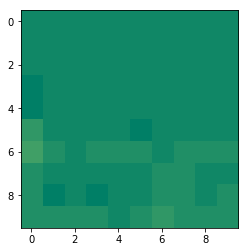

Step: 34
Updated position: [6 6]
Updated direction: [-1  0]


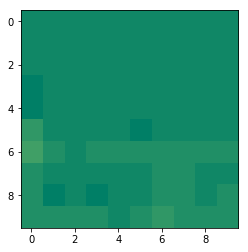

Step: 35
Updated position: [5 6]
Updated direction: [-1  0]


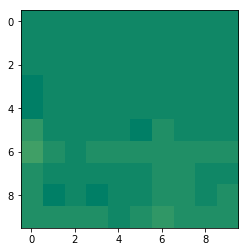

Step: 36
Updated position: [4 6]
Updated direction: [-1  0]


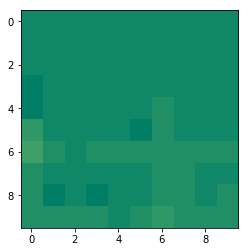

Step: 37
Updated position: [3 6]
Updated direction: [-1  0]


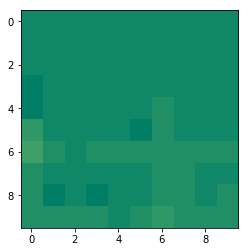

Step: 38
Updated position: [2 6]
Updated direction: [-1  0]


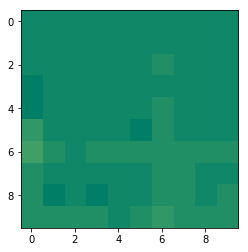

Step: 39
Updated position: [1 6]
Updated direction: [-1  0]


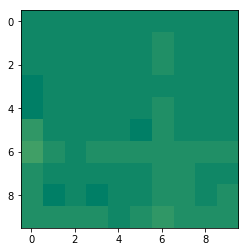

Step: 40
Updated position: [0 6]
Updated direction: [0 1]


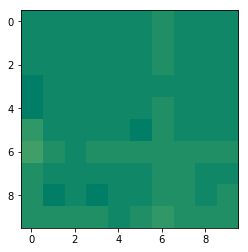

Step: 41
Updated position: [0 7]
Updated direction: [0 1]


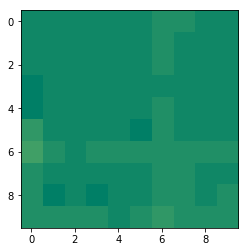

Step: 42
Updated position: [0 8]
Updated direction: [0 1]


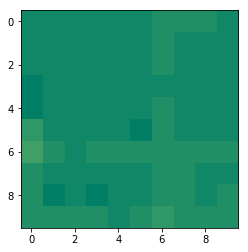

Step: 43
Updated position: [0 9]
Updated direction: [1 0]


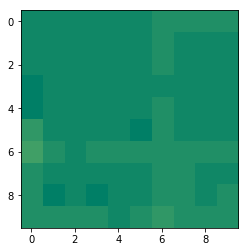

Step: 44
Updated position: [1 9]
Updated direction: [1 0]


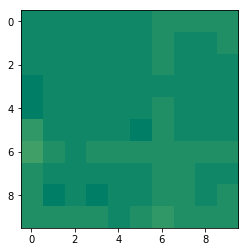

Step: 45
Updated position: [2 9]
Updated direction: [1 0]


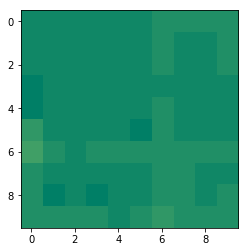

Step: 46
Updated position: [3 9]
Updated direction: [1 0]


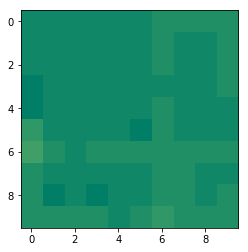

Step: 47
Updated position: [4 9]
Updated direction: [1 0]


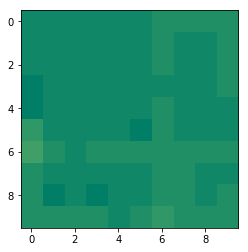

Step: 48
Updated position: [5 9]
Updated direction: [-1  0]


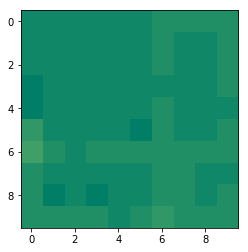

Step: 49
Updated position: [4 9]
Updated direction: [ 0 -1]


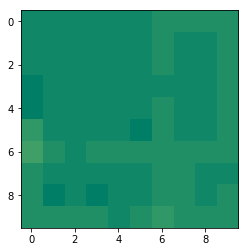

Step: 50
Updated position: [4 8]
Updated direction: [ 0 -1]


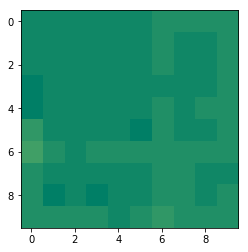

Step: 51
Updated position: [4 7]
Updated direction: [1 0]


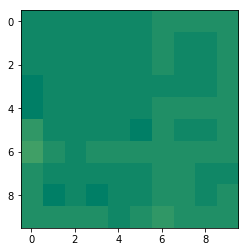

Step: 52
Updated position: [5 7]
Updated direction: [0 1]


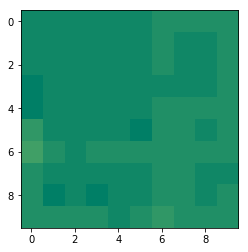

Step: 53
Updated position: [5 8]
Updated direction: [1 0]


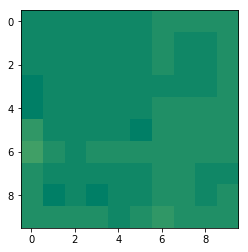

Step: 54
Updated position: [6 8]
Updated direction: [1 0]


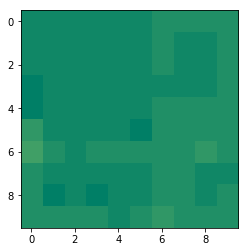

Step: 55
Updated position: [7 8]
Updated direction: [1 0]


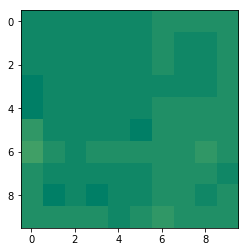

Step: 56
Updated position: [8 8]
Updated direction: [1 0]


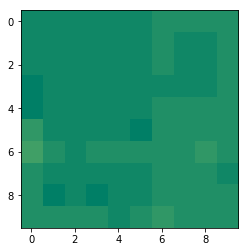

Step: 57
Updated position: [9 8]
Updated direction: [-1  0]


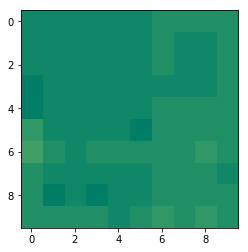

Step: 58
Updated position: [8 8]
Updated direction: [-1  0]


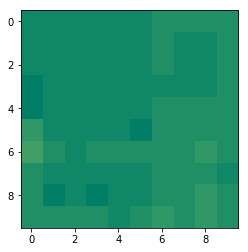

Step: 59
Updated position: [7 8]
Updated direction: [0 1]


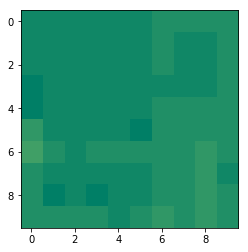

Step: 60
Updated position: [7 9]
Updated direction: [1 0]


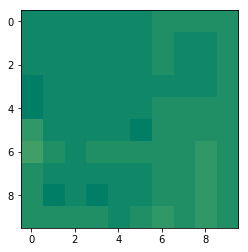

Step: 61
Updated position: [8 9]
Updated direction: [1 0]


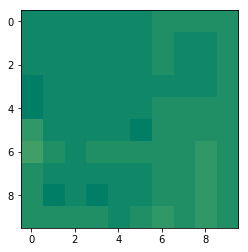

Step: 62
Updated position: [9 9]
Updated direction: [-1  0]


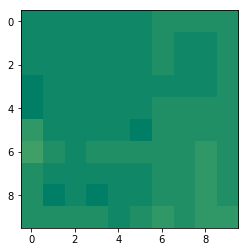

Step: 63
Updated position: [8 9]
Updated direction: [-1  0]


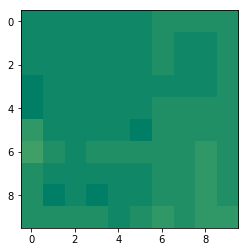

Step: 64
Updated position: [7 9]
Updated direction: [ 0 -1]


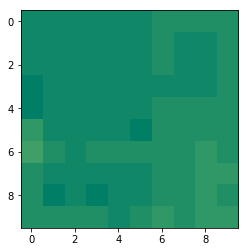

Step: 65
Updated position: [7 8]
Updated direction: [1 0]


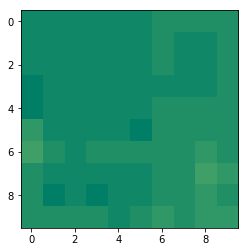

Step: 66
Updated position: [8 8]
Updated direction: [1 0]


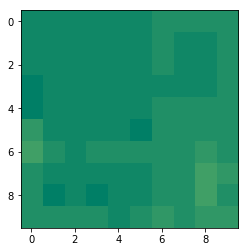

Step: 67
Updated position: [9 8]
Updated direction: [ 0 -1]


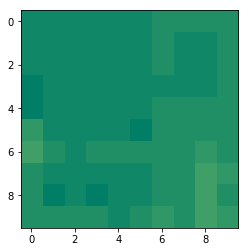

Step: 68
Updated position: [9 7]
Updated direction: [-1  0]


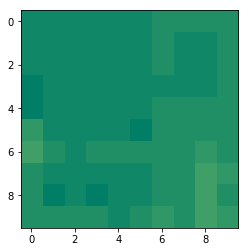

Step: 69
Updated position: [8 7]
Updated direction: [1 0]


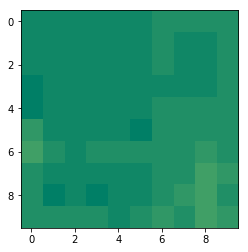

Step: 70
Updated position: [9 7]
Updated direction: [ 0 -1]


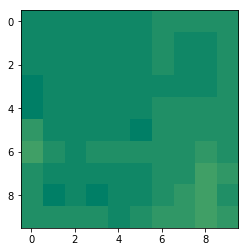

Step: 71
Updated position: [9 6]
Updated direction: [ 0 -1]


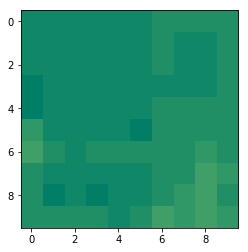

Step: 72
Updated position: [9 5]
Updated direction: [ 0 -1]


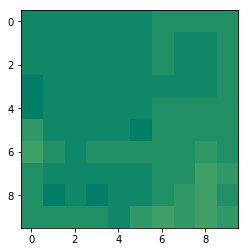

Step: 73
Updated position: [9 4]
Updated direction: [0 1]


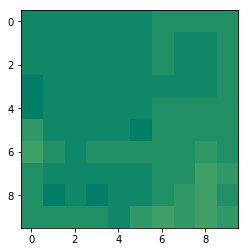

Step: 74
Updated position: [9 5]
Updated direction: [ 0 -1]


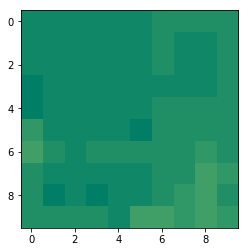

Step: 75
Updated position: [9 4]
Updated direction: [-1  0]


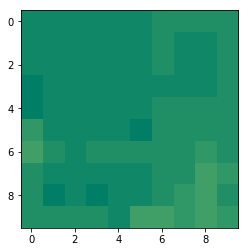

Step: 76
Updated position: [8 4]
Updated direction: [-1  0]


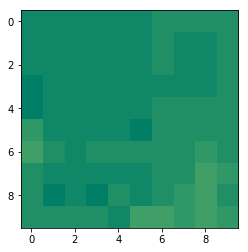

Step: 77
Updated position: [7 4]
Updated direction: [ 0 -1]


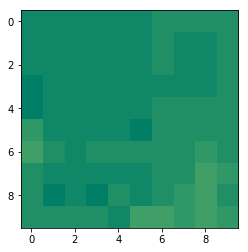

Step: 78
Updated position: [7 3]
Updated direction: [ 0 -1]


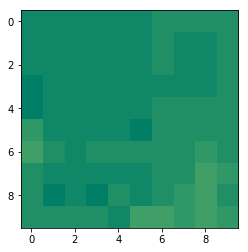

Step: 79
Updated position: [7 2]
Updated direction: [ 0 -1]


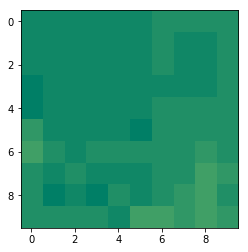

Step: 80
Updated position: [7 1]
Updated direction: [-1  0]


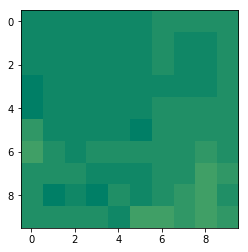

Step: 81
Updated position: [6 1]
Updated direction: [-1  0]


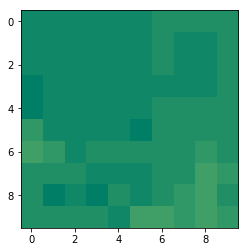

Step: 82
Updated position: [5 1]
Updated direction: [-1  0]


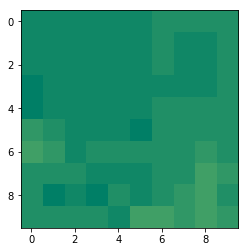

Step: 83
Updated position: [4 1]
Updated direction: [-1  0]


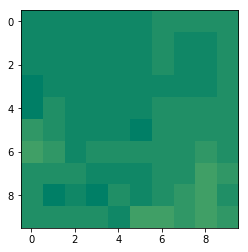

Step: 84
Updated position: [3 1]
Updated direction: [-1  0]


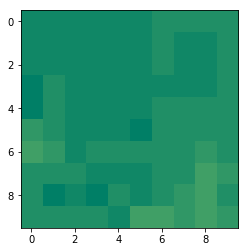

Step: 85
Updated position: [2 1]
Updated direction: [-1  0]


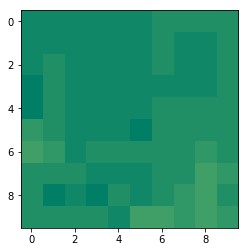

Step: 86
Updated position: [1 1]
Updated direction: [-1  0]


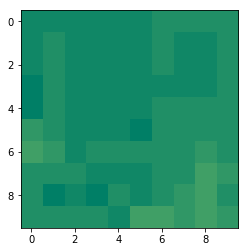

Step: 87
Updated position: [0 1]
Updated direction: [0 1]


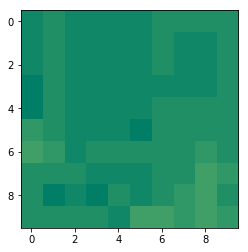

Step: 88
Updated position: [0 2]
Updated direction: [0 1]


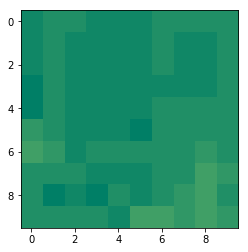

Step: 89
Updated position: [0 3]
Updated direction: [0 1]


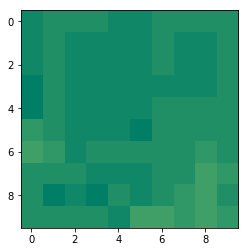

Step: 90
Updated position: [0 4]
Updated direction: [0 1]


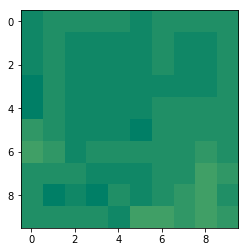

Step: 91
Updated position: [0 5]
Updated direction: [1 0]


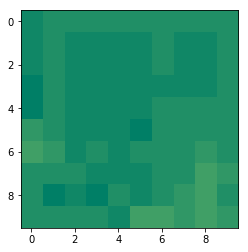

Step: 92
Updated position: [1 5]
Updated direction: [1 0]


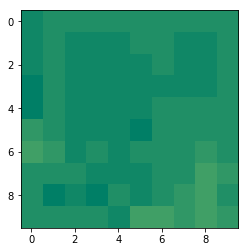

Step: 93
Updated position: [2 5]
Updated direction: [1 0]


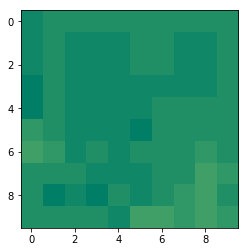

Step: 94
Updated position: [3 5]
Updated direction: [1 0]


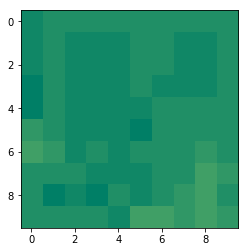

Step: 95
Updated position: [4 5]
Updated direction: [ 0 -1]


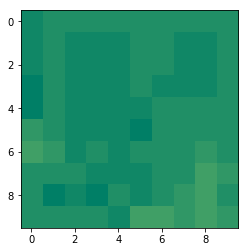

Step: 96
Updated position: [4 4]
Updated direction: [ 0 -1]


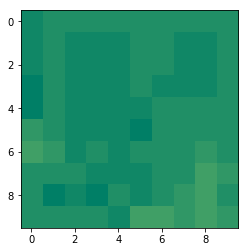

Step: 97
Updated position: [4 3]
Updated direction: [ 0 -1]


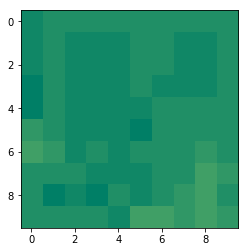

Step: 98
Updated position: [4 2]
Updated direction: [1 0]


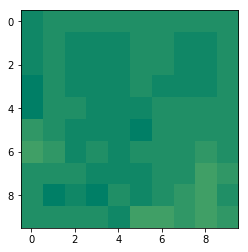

Step: 99
Updated position: [5 2]
Updated direction: [1 0]


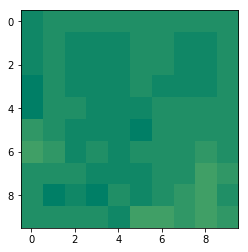

Step: 100
Updated position: [6 2]
Updated direction: [1 0]


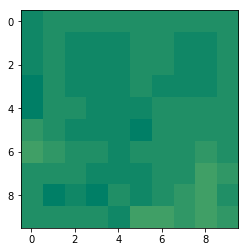

Step: 101
Updated position: [7 2]
Updated direction: [1 0]


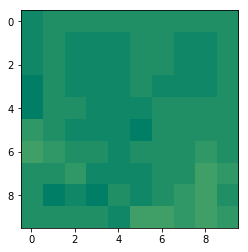

Step: 102
Updated position: [8 2]
Updated direction: [-1  0]


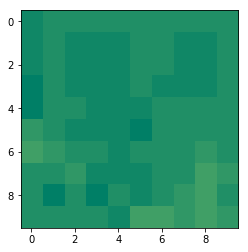

Step: 103
Updated position: [7 2]
Updated direction: [ 0 -1]


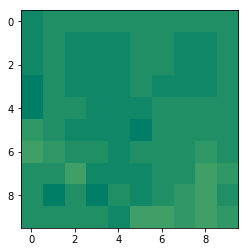

Step: 104
Updated position: [7 1]
Updated direction: [0 1]


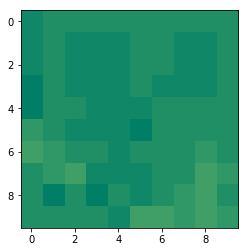

Step: 105
Updated position: [7 2]
Updated direction: [0 1]


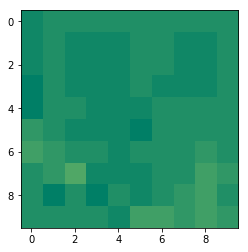

Step: 106
Updated position: [7 3]
Updated direction: [0 1]


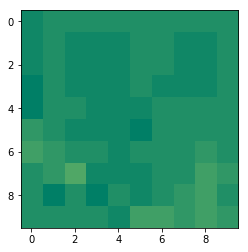

Step: 107
Updated position: [7 4]
Updated direction: [0 1]


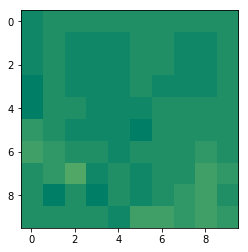

Step: 108
Updated position: [7 5]
Updated direction: [1 0]


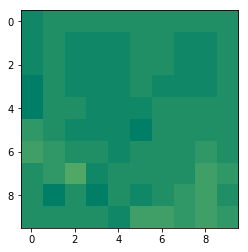

Step: 109
Updated position: [8 5]
Updated direction: [0 1]


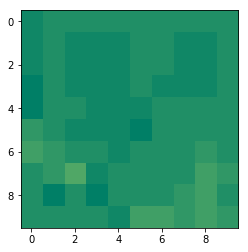

Step: 110
Updated position: [8 6]
Updated direction: [-1  0]


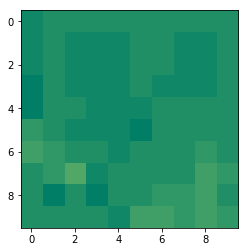

Step: 111
Updated position: [7 6]
Updated direction: [-1  0]


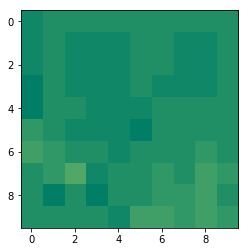

Step: 112
Updated position: [6 6]
Updated direction: [-1  0]


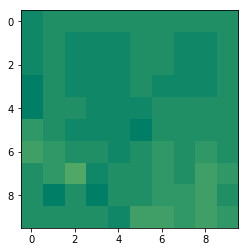

Step: 113
Updated position: [5 6]
Updated direction: [-1  0]


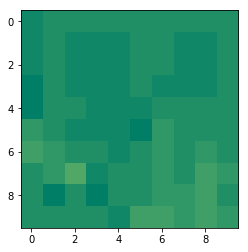

Step: 114
Updated position: [4 6]
Updated direction: [-1  0]


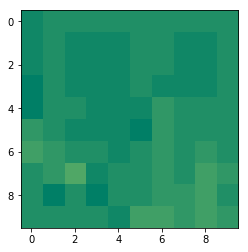

Step: 115
Updated position: [3 6]
Updated direction: [0 1]


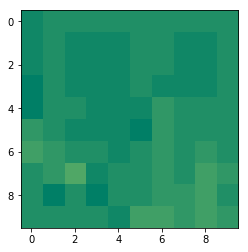

Step: 116
Updated position: [3 7]
Updated direction: [0 1]


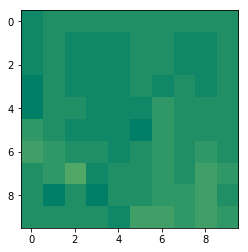

Step: 117
Updated position: [3 8]
Updated direction: [-1  0]


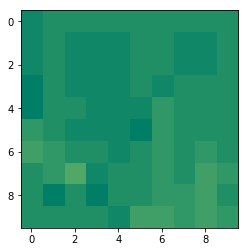

Step: 118
Updated position: [2 8]
Updated direction: [-1  0]


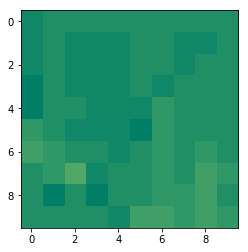

Step: 119
Updated position: [1 8]
Updated direction: [ 0 -1]


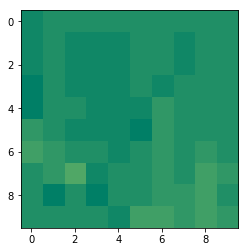

Step: 120
Updated position: [1 7]
Updated direction: [1 0]


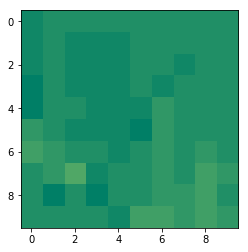

Step: 121
Updated position: [2 7]
Updated direction: [1 0]


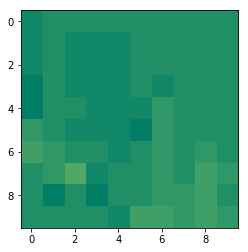

Step: 122
Updated position: [3 7]
Updated direction: [ 0 -1]


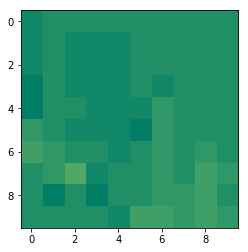

Step: 123
Updated position: [3 6]
Updated direction: [ 0 -1]


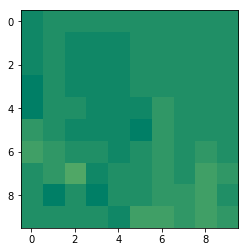

Step: 124
Updated position: [3 5]
Updated direction: [ 0 -1]


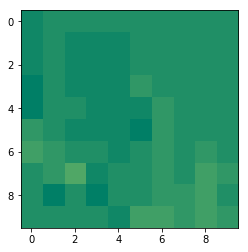

Step: 125
Updated position: [3 4]
Updated direction: [ 0 -1]


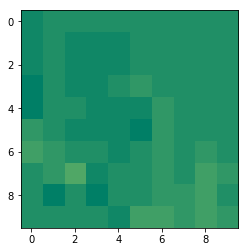

Step: 126
Updated position: [3 3]
Updated direction: [ 0 -1]


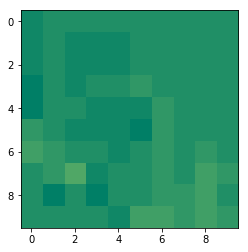

Step: 127
Updated position: [3 2]
Updated direction: [-1  0]


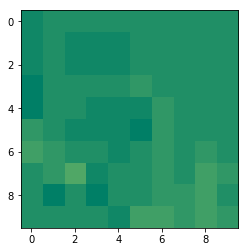

Step: 128
Updated position: [2 2]
Updated direction: [-1  0]


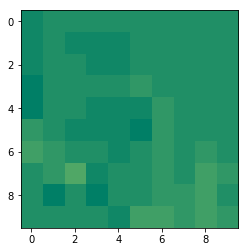

Step: 129
Updated position: [1 2]
Updated direction: [0 1]


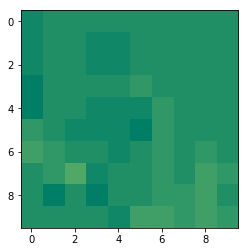

Step: 130
Updated position: [1 3]
Updated direction: [0 1]


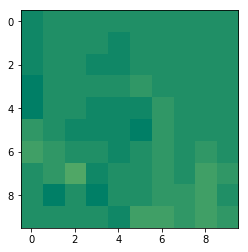

Step: 131
Updated position: [1 4]
Updated direction: [0 1]


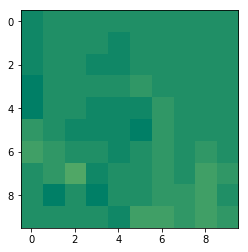

Step: 132
Updated position: [1 5]
Updated direction: [0 1]


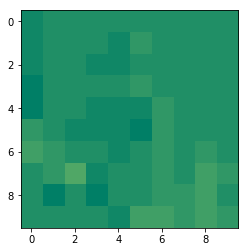

Step: 133
Updated position: [1 6]
Updated direction: [1 0]


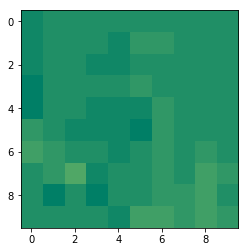

Step: 134
Updated position: [2 6]
Updated direction: [1 0]


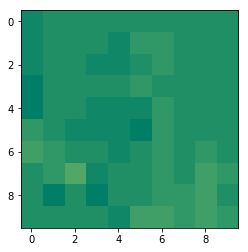

Step: 135
Updated position: [3 6]
Updated direction: [0 1]


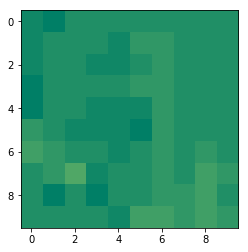

Step: 136
Updated position: [3 7]
Updated direction: [-1  0]


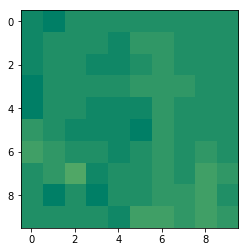

Step: 137
Updated position: [2 7]
Updated direction: [-1  0]


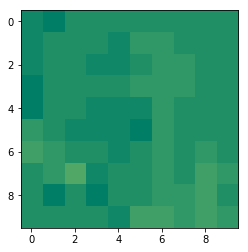

Step: 138
Updated position: [1 7]
Updated direction: [-1  0]


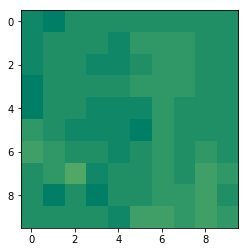

Step: 139
Updated position: [0 7]
Updated direction: [0 1]


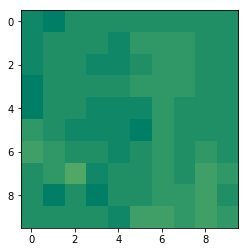

Step: 140
Updated position: [0 8]
Updated direction: [0 1]


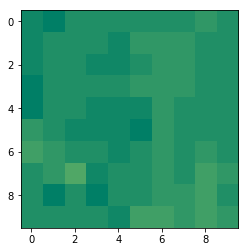

Step: 141
Updated position: [0 9]
Updated direction: [1 0]


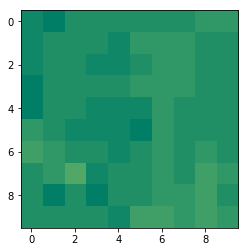

Step: 142
Updated position: [1 9]
Updated direction: [1 0]


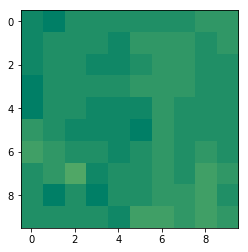

Step: 143
Updated position: [2 9]
Updated direction: [-1  0]


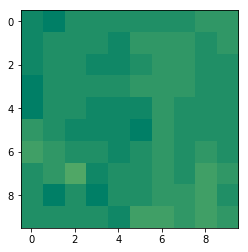

Step: 144
Updated position: [1 9]
Updated direction: [ 0 -1]


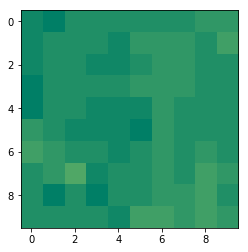

Step: 145
Updated position: [1 8]
Updated direction: [1 0]


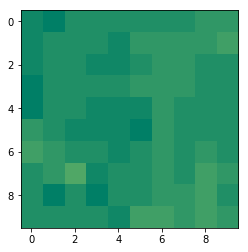

Step: 146
Updated position: [2 8]
Updated direction: [ 0 -1]


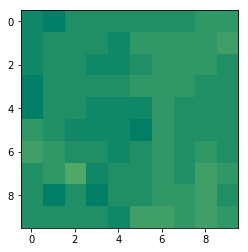

Step: 147
Updated position: [2 7]
Updated direction: [-1  0]


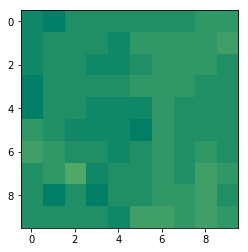

Step: 148
Updated position: [1 7]
Updated direction: [-1  0]


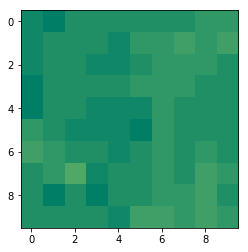

Step: 149
Updated position: [0 7]
Updated direction: [0 1]


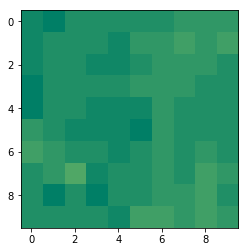

Step: 150
Updated position: [0 8]
Updated direction: [0 1]


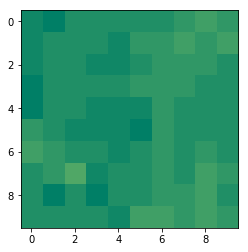

Step: 151
Updated position: [0 9]
Updated direction: [ 0 -1]


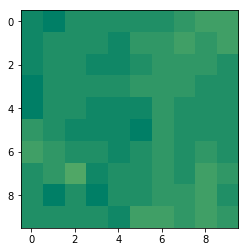

Step: 152
Updated position: [0 8]
Updated direction: [ 0 -1]


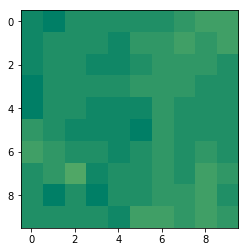

Step: 153
Updated position: [0 7]
Updated direction: [ 0 -1]


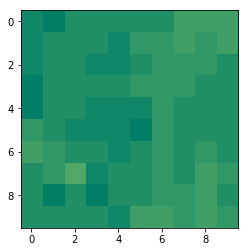

Step: 154
Updated position: [0 6]
Updated direction: [1 0]


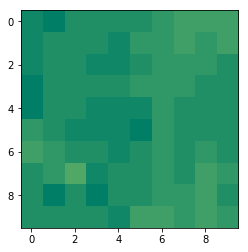

Step: 155
Updated position: [1 6]
Updated direction: [1 0]


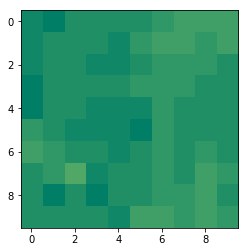

Step: 156
Updated position: [2 6]
Updated direction: [ 0 -1]


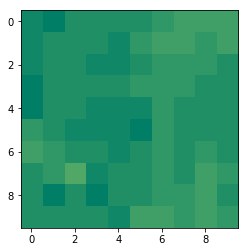

Step: 157
Updated position: [2 5]
Updated direction: [ 0 -1]


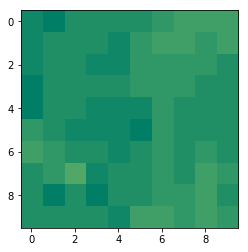

Step: 158
Updated position: [2 4]
Updated direction: [ 0 -1]


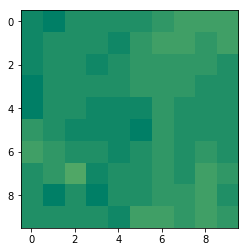

Step: 159
Updated position: [2 3]
Updated direction: [1 0]


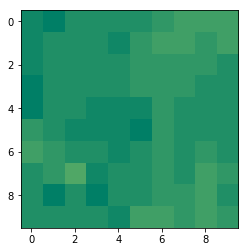

Step: 160
Updated position: [3 3]
Updated direction: [1 0]


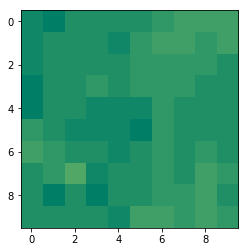

Step: 161
Updated position: [4 3]
Updated direction: [1 0]


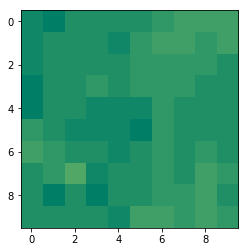

Step: 162
Updated position: [5 3]
Updated direction: [-1  0]


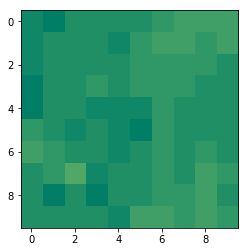

Step: 163
Updated position: [4 3]
Updated direction: [0 1]


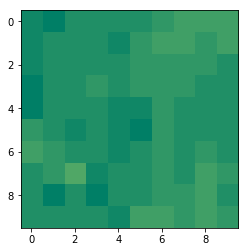

Step: 164
Updated position: [4 4]
Updated direction: [0 1]


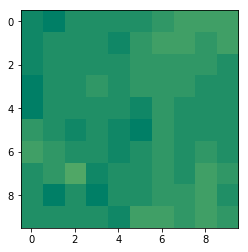

Step: 165
Updated position: [4 5]
Updated direction: [ 0 -1]


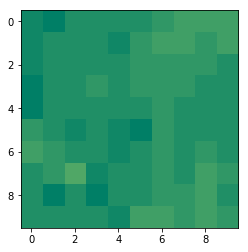

Step: 166
Updated position: [4 4]
Updated direction: [1 0]


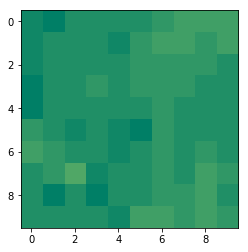

Step: 167
Updated position: [5 4]
Updated direction: [1 0]


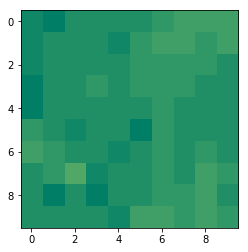

Step: 168
Updated position: [6 4]
Updated direction: [1 0]


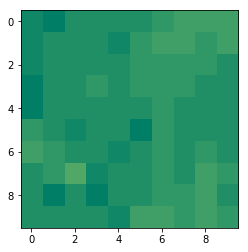

Step: 169
Updated position: [7 4]
Updated direction: [-1  0]


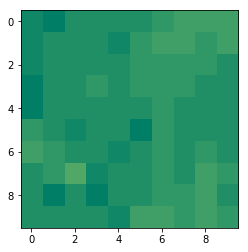

Step: 170
Updated position: [6 4]
Updated direction: [1 0]


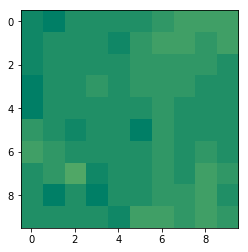

Step: 171
Updated position: [7 4]
Updated direction: [ 0 -1]


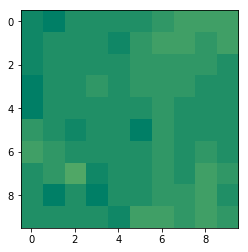

Step: 172
Updated position: [7 3]
Updated direction: [ 0 -1]


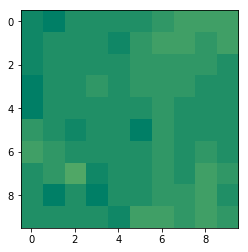

Step: 173
Updated position: [7 2]
Updated direction: [0 1]


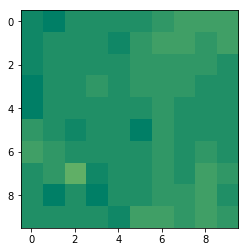

Step: 174
Updated position: [7 3]
Updated direction: [ 0 -1]


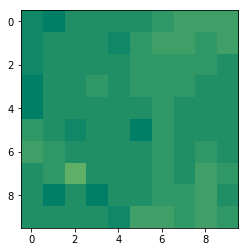

Step: 175
Updated position: [7 2]
Updated direction: [1 0]


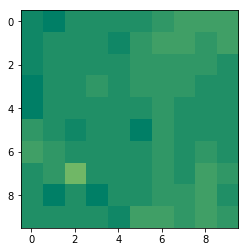

Step: 176
Updated position: [8 2]
Updated direction: [-1  0]


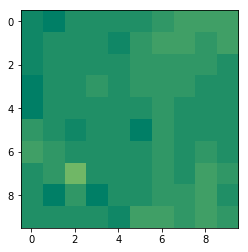

Step: 177
Updated position: [7 2]
Updated direction: [-1  0]


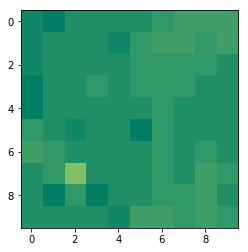

Step: 178
Updated position: [6 2]
Updated direction: [-1  0]


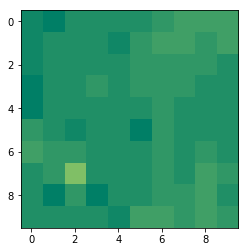

Step: 179
Updated position: [5 2]
Updated direction: [-1  0]


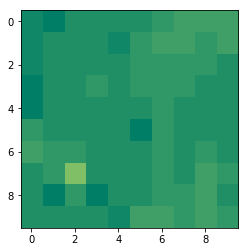

Step: 180
Updated position: [4 2]
Updated direction: [0 1]


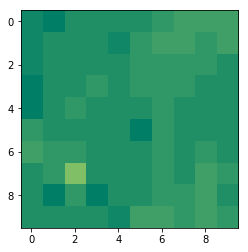

Step: 181
Updated position: [4 3]
Updated direction: [1 0]


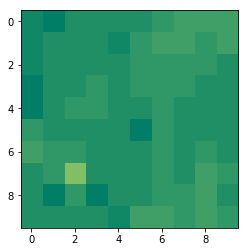

Step: 182
Updated position: [5 3]
Updated direction: [1 0]


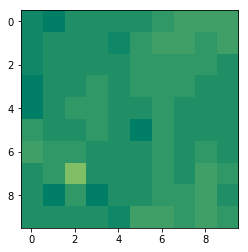

Step: 183
Updated position: [6 3]
Updated direction: [1 0]


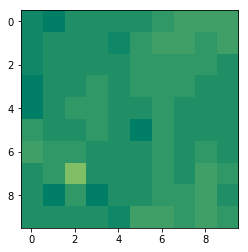

Step: 184
Updated position: [7 3]
Updated direction: [-1  0]


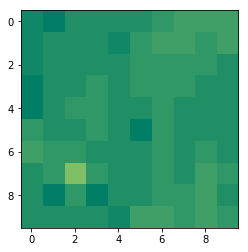

Step: 185
Updated position: [6 3]
Updated direction: [0 1]


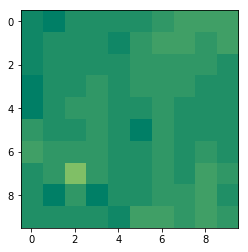

Step: 186
Updated position: [6 4]
Updated direction: [1 0]


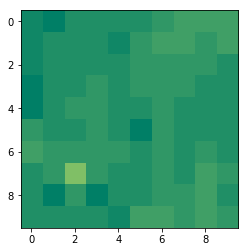

Step: 187
Updated position: [7 4]
Updated direction: [1 0]


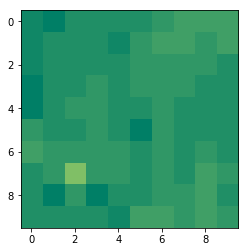

Step: 188
Updated position: [8 4]
Updated direction: [1 0]


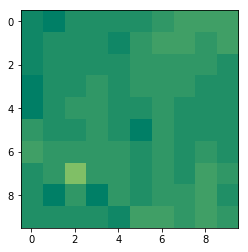

Step: 189
Updated position: [9 4]
Updated direction: [-1  0]


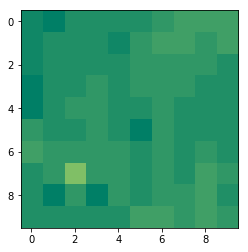

Step: 190
Updated position: [8 4]
Updated direction: [1 0]


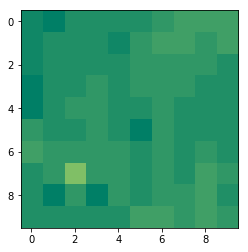

Step: 191
Updated position: [9 4]
Updated direction: [ 0 -1]


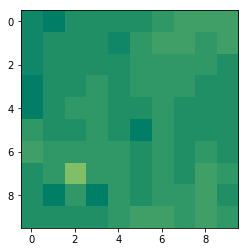

Step: 192
Updated position: [9 3]
Updated direction: [0 1]


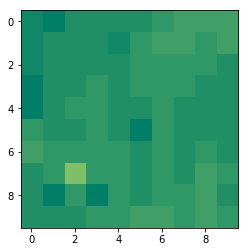

Step: 193
Updated position: [9 4]
Updated direction: [0 1]


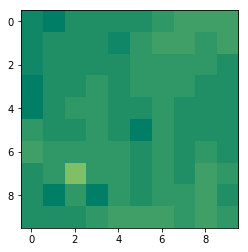

Step: 194
Updated position: [9 5]
Updated direction: [0 1]


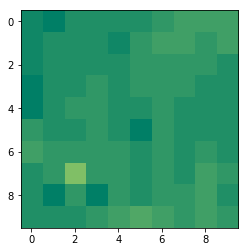

Step: 195
Updated position: [9 6]
Updated direction: [0 1]


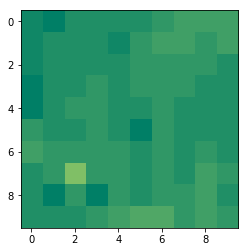

Step: 196
Updated position: [9 7]
Updated direction: [-1  0]


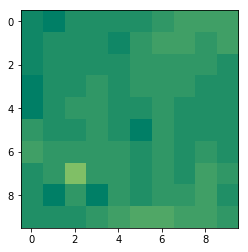

Step: 197
Updated position: [8 7]
Updated direction: [-1  0]


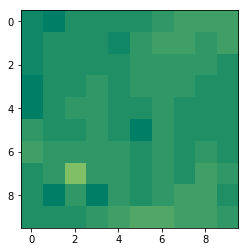

Step: 198
Updated position: [7 7]
Updated direction: [ 0 -1]


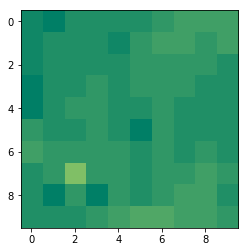

Step: 199
Updated position: [7 6]
Updated direction: [-1  0]


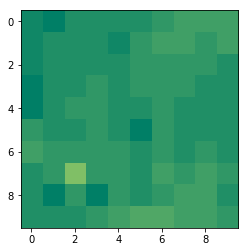

Step: 200
Updated position: [6 6]
Updated direction: [0 1]


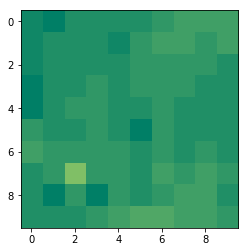

Step: 201
Updated position: [6 7]
Updated direction: [-1  0]


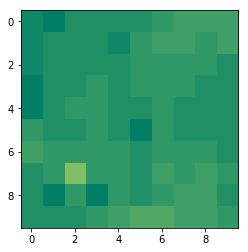

Step: 202
Updated position: [5 7]
Updated direction: [-1  0]


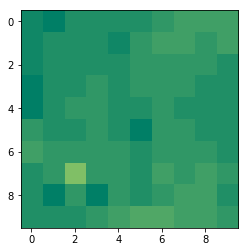

Step: 203
Updated position: [4 7]
Updated direction: [0 1]


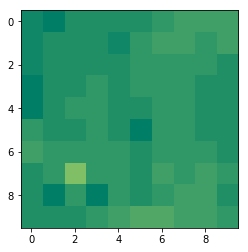

Step: 204
Updated position: [4 8]
Updated direction: [1 0]


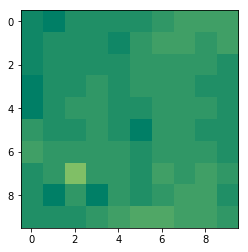

Step: 205
Updated position: [5 8]
Updated direction: [0 1]


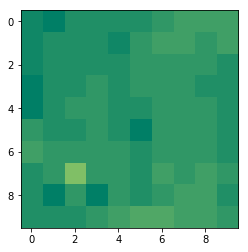

Step: 206
Updated position: [5 9]
Updated direction: [1 0]


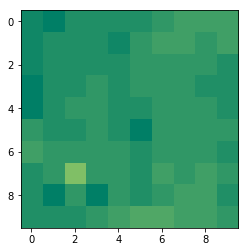

Step: 207
Updated position: [6 9]
Updated direction: [1 0]


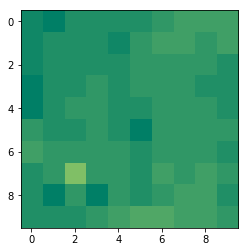

Step: 208
Updated position: [7 9]
Updated direction: [1 0]


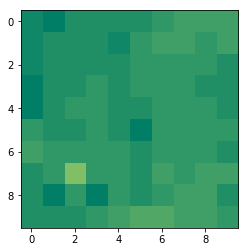

Step: 209
Updated position: [8 9]
Updated direction: [-1  0]


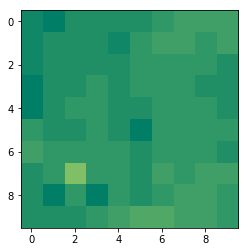

Step: 210
Updated position: [7 9]
Updated direction: [-1  0]


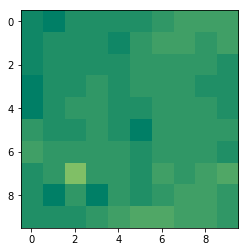

Step: 211
Updated position: [6 9]
Updated direction: [-1  0]


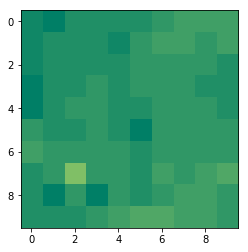

Step: 212
Updated position: [5 9]
Updated direction: [-1  0]


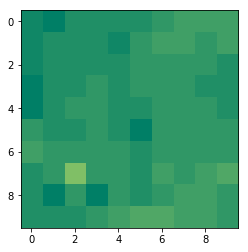

Step: 213
Updated position: [4 9]
Updated direction: [-1  0]


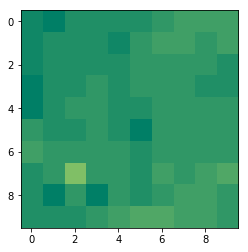

Step: 214
Updated position: [3 9]
Updated direction: [ 0 -1]


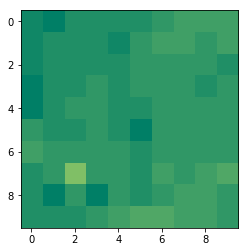

Step: 215
Updated position: [3 8]
Updated direction: [0 1]


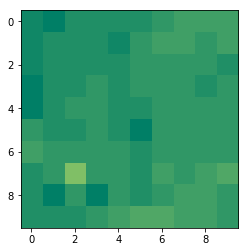

Step: 216
Updated position: [3 9]
Updated direction: [-1  0]


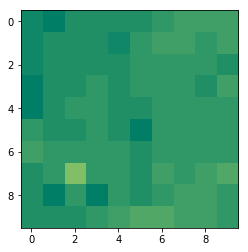

Step: 217
Updated position: [2 9]
Updated direction: [-1  0]


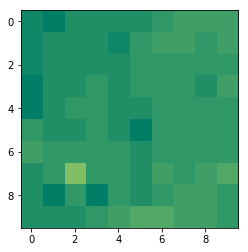

Step: 218
Updated position: [1 9]
Updated direction: [1 0]


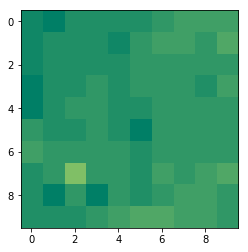

Step: 219
Updated position: [2 9]
Updated direction: [1 0]


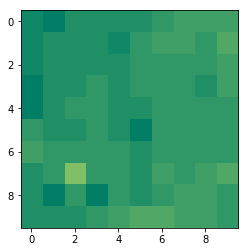

Step: 220
Updated position: [3 9]
Updated direction: [ 0 -1]


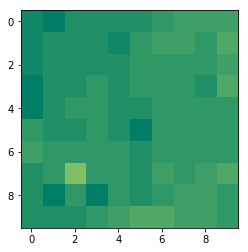

Step: 221
Updated position: [3 8]
Updated direction: [0 1]


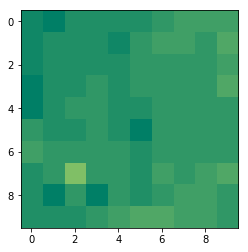

Step: 222
Updated position: [3 9]
Updated direction: [ 0 -1]


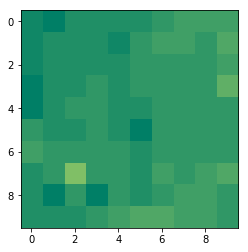

Step: 223
Updated position: [3 8]
Updated direction: [1 0]


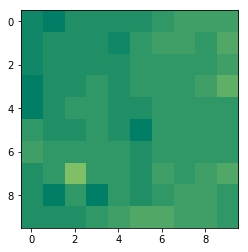

Step: 224
Updated position: [4 8]
Updated direction: [1 0]


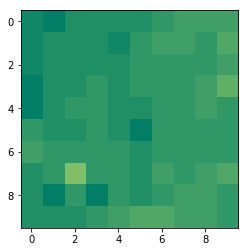

Step: 225
Updated position: [5 8]
Updated direction: [-1  0]


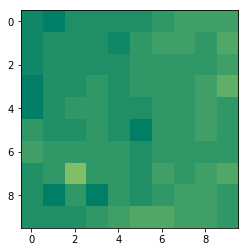

Step: 226
Updated position: [4 8]
Updated direction: [ 0 -1]


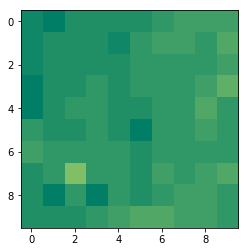

Step: 227
Updated position: [4 7]
Updated direction: [1 0]


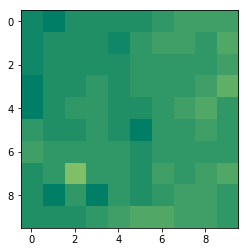

Step: 228
Updated position: [5 7]
Updated direction: [ 0 -1]


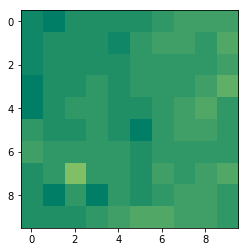

Step: 229
Updated position: [5 6]
Updated direction: [1 0]


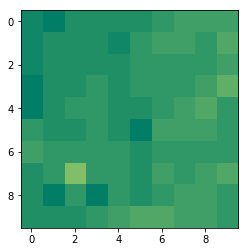

Step: 230
Updated position: [6 6]
Updated direction: [ 0 -1]


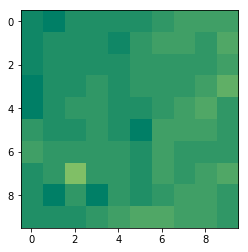

Step: 231
Updated position: [6 5]
Updated direction: [ 0 -1]


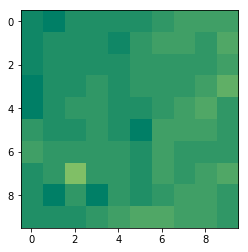

Step: 232
Updated position: [6 4]
Updated direction: [-1  0]


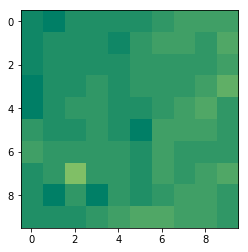

Step: 233
Updated position: [5 4]
Updated direction: [ 0 -1]


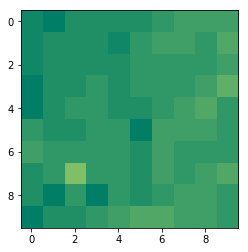

Step: 234
Updated position: [5 3]
Updated direction: [-1  0]


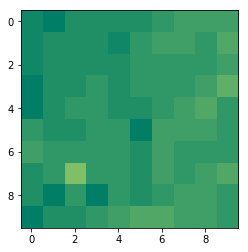

Step: 235
Updated position: [4 3]
Updated direction: [0 1]


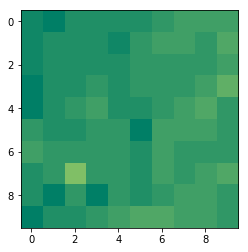

Step: 236
Updated position: [4 4]
Updated direction: [-1  0]


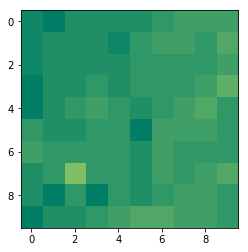

Step: 237
Updated position: [3 4]
Updated direction: [-1  0]


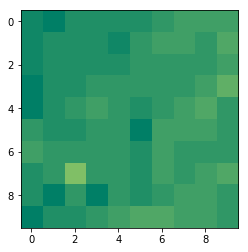

Step: 238
Updated position: [2 4]
Updated direction: [-1  0]


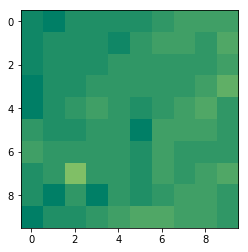

Step: 239
Updated position: [1 4]
Updated direction: [-1  0]


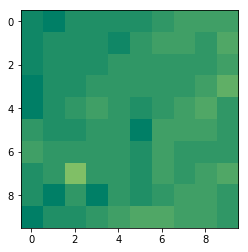

Step: 240
Updated position: [0 4]
Updated direction: [1 0]


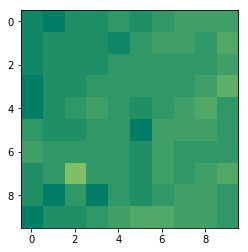

Step: 241
Updated position: [1 4]
Updated direction: [-1  0]


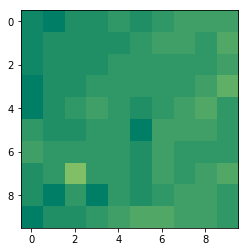

Step: 242
Updated position: [0 4]
Updated direction: [1 0]


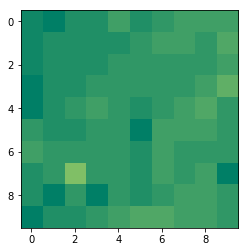

Step: 243
Updated position: [1 4]
Updated direction: [-1  0]


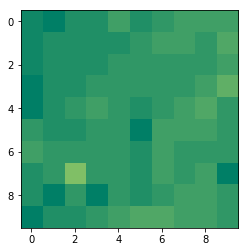

Step: 244
Updated position: [0 4]
Updated direction: [0 1]


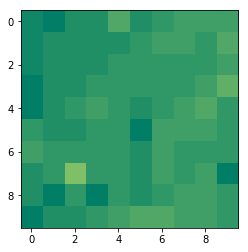

Step: 245
Updated position: [0 5]
Updated direction: [0 1]


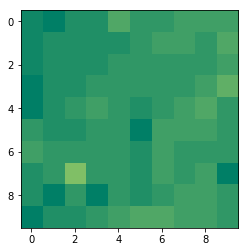

Step: 246
Updated position: [0 6]
Updated direction: [ 0 -1]


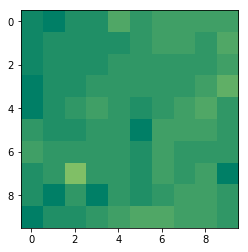

Step: 247
Updated position: [0 5]
Updated direction: [1 0]


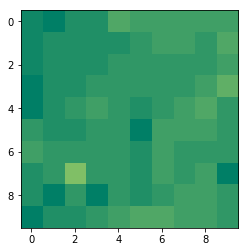

Step: 248
Updated position: [1 5]
Updated direction: [ 0 -1]


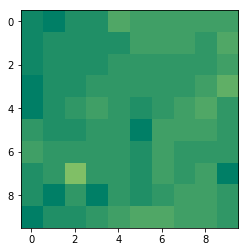

Step: 249
Updated position: [1 4]
Updated direction: [1 0]


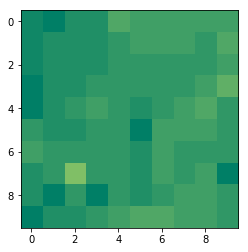

Step: 250
Updated position: [2 4]
Updated direction: [ 0 -1]


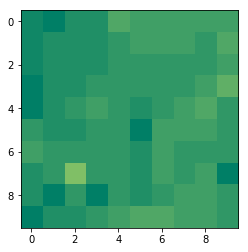

Step: 251
Updated position: [2 3]
Updated direction: [-1  0]


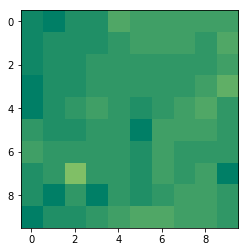

Step: 252
Updated position: [1 3]
Updated direction: [1 0]


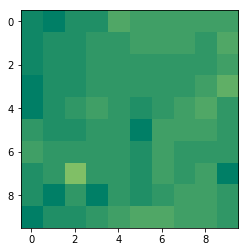

Step: 253
Updated position: [2 3]
Updated direction: [-1  0]


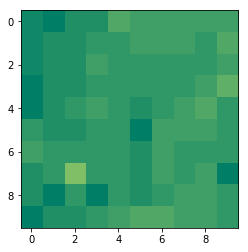

Step: 254
Updated position: [1 3]
Updated direction: [-1  0]


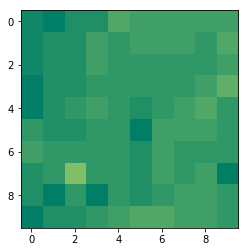

Step: 255
Updated position: [0 3]
Updated direction: [ 0 -1]


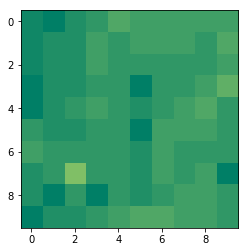

Step: 256
Updated position: [0 2]
Updated direction: [1 0]


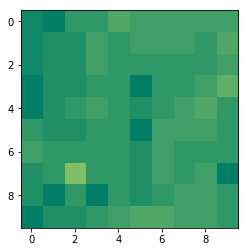

Step: 257
Updated position: [1 2]
Updated direction: [1 0]


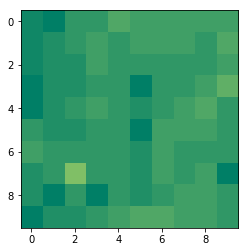

Step: 258
Updated position: [2 2]
Updated direction: [1 0]


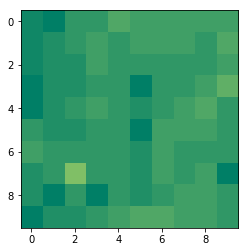

Step: 259
Updated position: [3 2]
Updated direction: [-1  0]


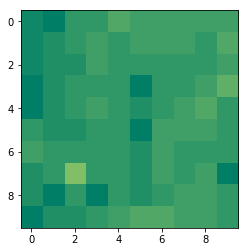

Step: 260
Updated position: [2 2]
Updated direction: [ 0 -1]


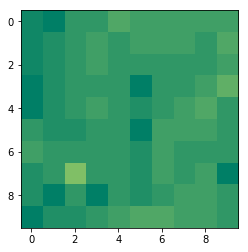

Step: 261
Updated position: [2 1]
Updated direction: [ 0 -1]


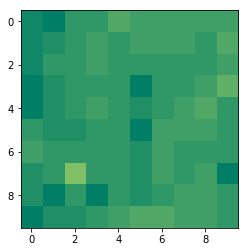

Step: 262
Updated position: [2 0]
Updated direction: [0 1]


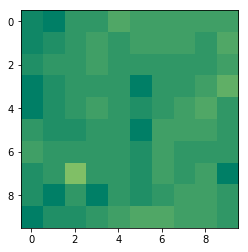

Total amount of time: 1874


In [164]:
# Visualization of the floor - Roomba 2
roomba_2 = RoombaSimulation(0.05, 0.05, 0.05, 0.05, 0.8, 10)
roomba_2.initialize()
steps_2 = 0
while len(np.where(roomba_2.config == 0)[0]) > 0.02*roomba_1.size**2 and steps_2 < 1000:
    print("Step: " + str(steps_2))
    roomba_2.cell_change()
    print("Updated position: " + str(roomba_2.pos))
    roomba_2.roomba_2()
    print("Updated direction: " + str(roomba_2.current_dir))
    steps_2 += 1
    plt.cla()
    plt.imshow(roomba_2.config, vmin = -1, vmax = 15, cmap = cm.summer)
    plt.show()
print("Total amount of time: " + str(roomba_2.T))

Step: 0
Updated position: [8 2]
Updated direction: [ 0 -1]


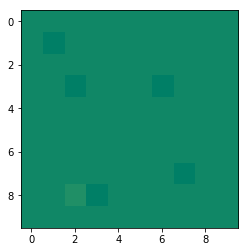

Step: 1
Updated position: [8 1]
Updated direction: [1 0]


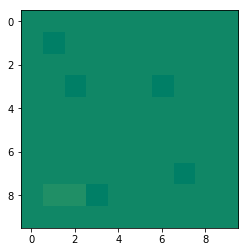

Step: 2
Updated position: [9 1]
Updated direction: [-1  0]


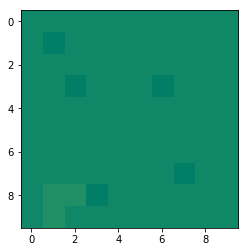

Step: 3
Updated position: [8 1]
Updated direction: [1 0]


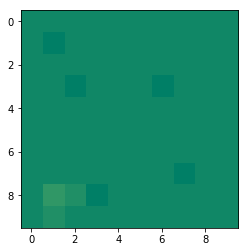

Step: 4
Updated position: [9 1]
Updated direction: [ 0 -1]


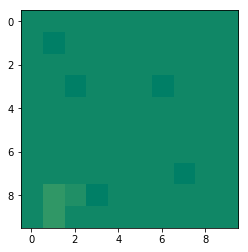

Step: 5
Updated position: [9 0]
Updated direction: [-1  0]


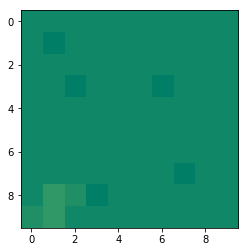

Step: 6
Updated position: [8 0]
Updated direction: [-1  0]


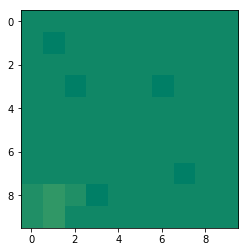

Step: 7
Updated position: [7 0]
Updated direction: [0 1]


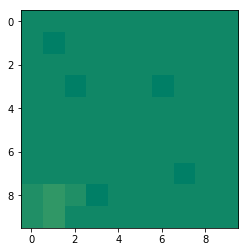

Step: 8
Updated position: [7 1]
Updated direction: [1 0]


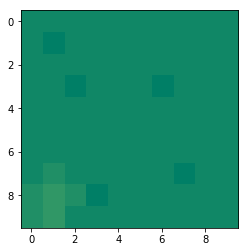

Step: 9
Updated position: [8 1]
Updated direction: [-1  0]


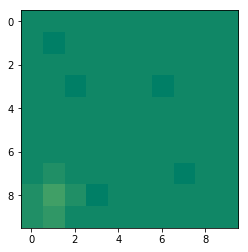

Step: 10
Updated position: [7 1]
Updated direction: [1 0]


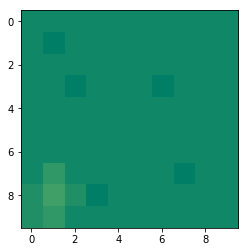

Step: 11
Updated position: [8 1]
Updated direction: [1 0]


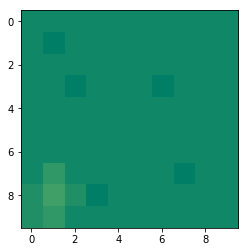

Step: 12
Updated position: [9 1]
Updated direction: [-1  0]


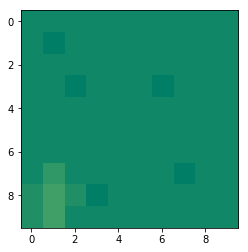

Step: 13
Updated position: [8 1]
Updated direction: [ 0 -1]


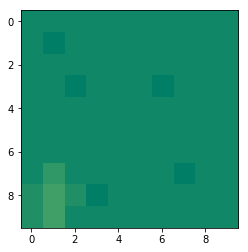

Step: 14
Updated position: [8 0]
Updated direction: [0 1]


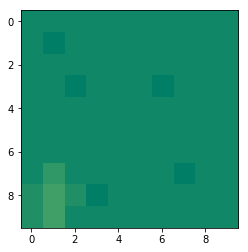

Step: 15
Updated position: [8 1]
Updated direction: [1 0]


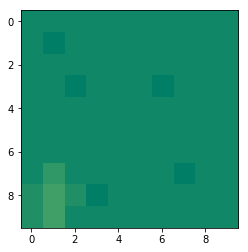

Step: 16
Updated position: [9 1]
Updated direction: [ 0 -1]


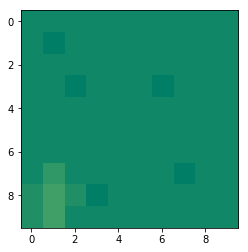

Step: 17
Updated position: [9 0]
Updated direction: [-1  0]


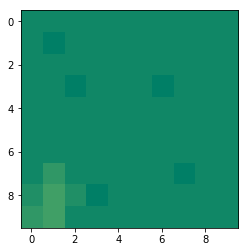

Step: 18
Updated position: [8 0]
Updated direction: [-1  0]


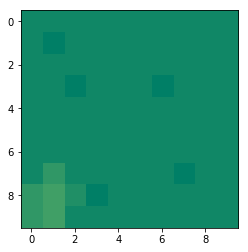

Step: 19
Updated position: [7 0]
Updated direction: [-1  0]


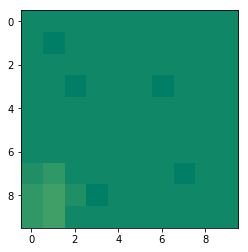

Step: 20
Updated position: [6 0]
Updated direction: [-1  0]


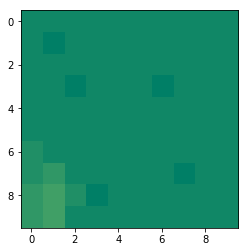

Step: 21
Updated position: [5 0]
Updated direction: [-1  0]


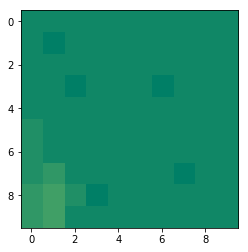

Step: 22
Updated position: [4 0]
Updated direction: [-1  0]


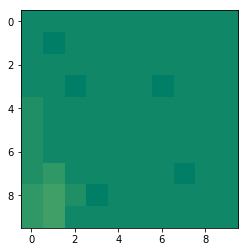

Step: 23
Updated position: [3 0]
Updated direction: [0 1]


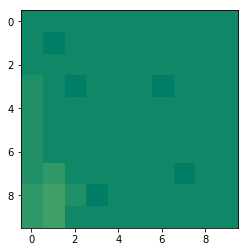

Step: 24
Updated position: [3 1]
Updated direction: [ 0 -1]


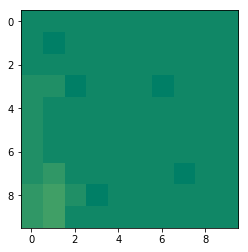

Step: 25
Updated position: [3 0]
Updated direction: [-1  0]


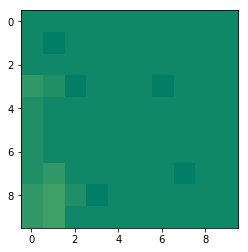

Step: 26
Updated position: [2 0]
Updated direction: [-1  0]


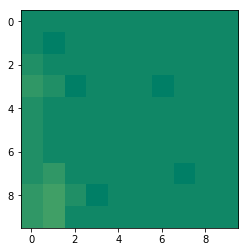

Step: 27
Updated position: [1 0]
Updated direction: [-1  0]


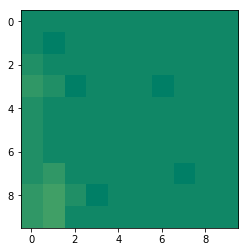

Step: 28
Updated position: [0 0]
Updated direction: [0 1]


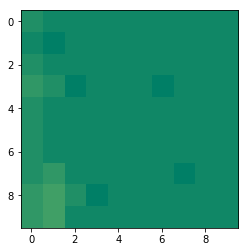

Step: 29
Updated position: [0 1]
Updated direction: [0 1]


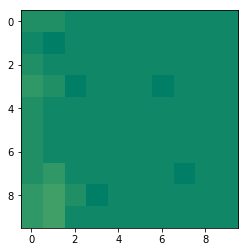

Step: 30
Updated position: [0 2]
Updated direction: [ 0 -1]


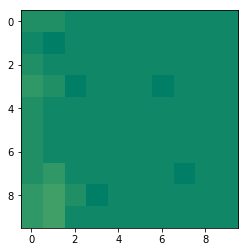

Step: 31
Updated position: [0 1]
Updated direction: [ 0 -1]


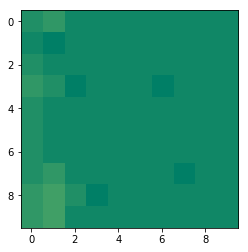

Step: 32
Updated position: [0 0]
Updated direction: [1 0]


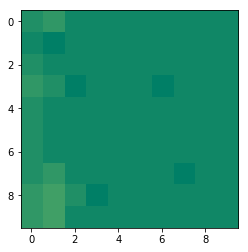

Step: 33
Updated position: [1 0]
Updated direction: [1 0]


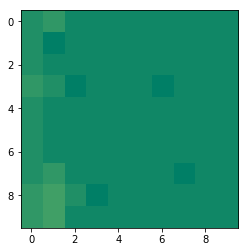

Step: 34
Updated position: [2 0]
Updated direction: [0 1]


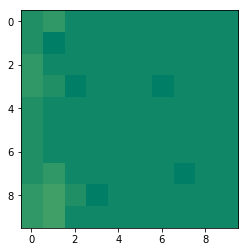

Step: 35
Updated position: [2 1]
Updated direction: [1 0]


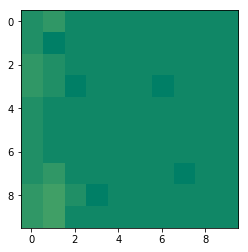

Step: 36
Updated position: [3 1]
Updated direction: [-1  0]


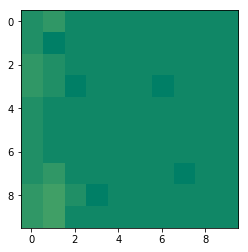

Step: 37
Updated position: [2 1]
Updated direction: [0 1]


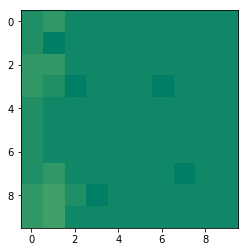

Step: 38
Updated position: [2 2]
Updated direction: [ 0 -1]


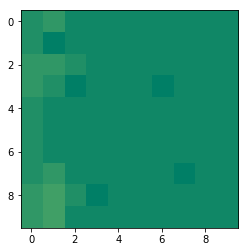

Step: 39
Updated position: [2 1]
Updated direction: [1 0]


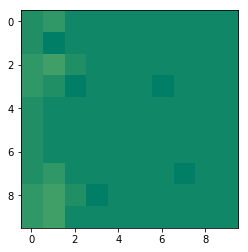

Step: 40
Updated position: [3 1]
Updated direction: [-1  0]


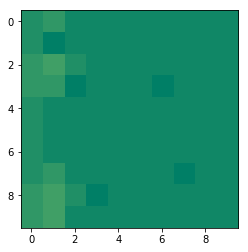

Step: 41
Updated position: [2 1]
Updated direction: [0 1]


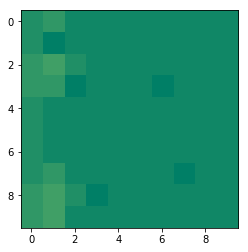

Step: 42
Updated position: [2 2]
Updated direction: [-1  0]


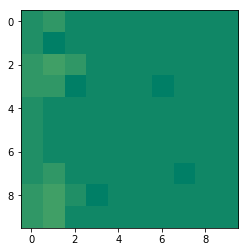

Step: 43
Updated position: [1 2]
Updated direction: [-1  0]


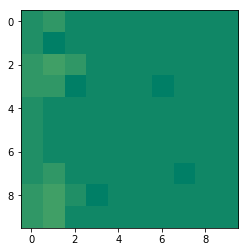

Step: 44
Updated position: [0 2]
Updated direction: [1 0]


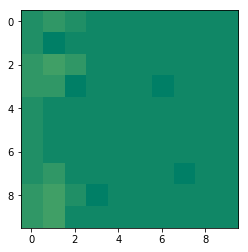

Step: 45
Updated position: [1 2]
Updated direction: [0 1]


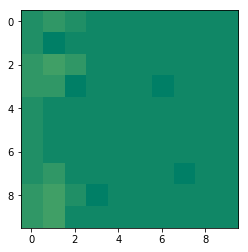

Step: 46
Updated position: [1 3]
Updated direction: [1 0]


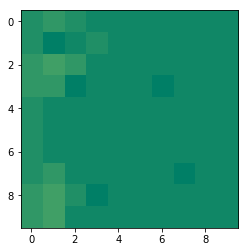

Step: 47
Updated position: [2 3]
Updated direction: [0 1]


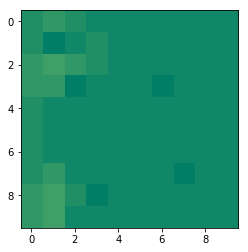

Step: 48
Updated position: [2 4]
Updated direction: [1 0]


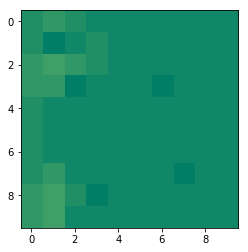

Step: 49
Updated position: [3 4]
Updated direction: [1 0]


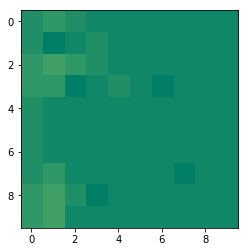

Step: 50
Updated position: [4 4]
Updated direction: [1 0]


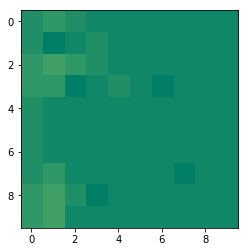

Step: 51
Updated position: [5 4]
Updated direction: [-1  0]


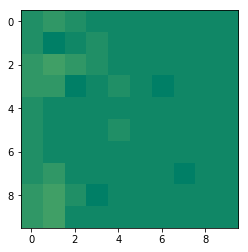

Step: 52
Updated position: [4 4]
Updated direction: [ 0 -1]


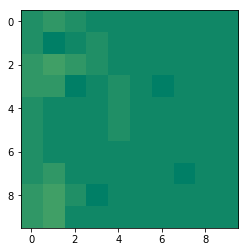

Step: 53
Updated position: [4 3]
Updated direction: [ 0 -1]


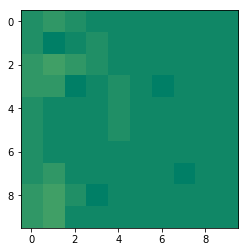

Step: 54
Updated position: [4 2]
Updated direction: [1 0]


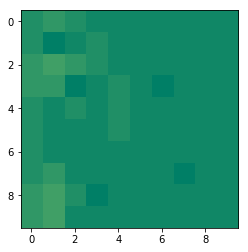

Step: 55
Updated position: [5 2]
Updated direction: [ 0 -1]


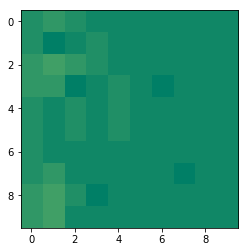

Step: 56
Updated position: [5 1]
Updated direction: [1 0]


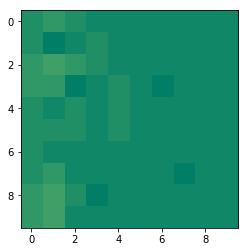

Step: 57
Updated position: [6 1]
Updated direction: [0 1]


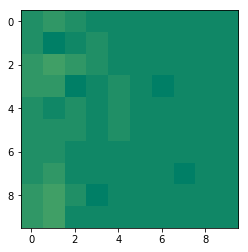

Step: 58
Updated position: [6 2]
Updated direction: [ 0 -1]


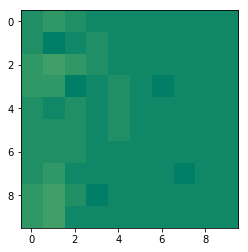

Step: 59
Updated position: [6 1]
Updated direction: [-1  0]


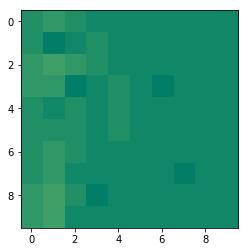

Step: 60
Updated position: [5 1]
Updated direction: [-1  0]


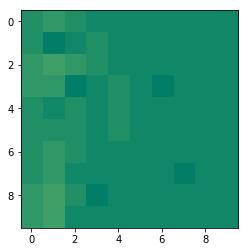

Step: 61
Updated position: [4 1]
Updated direction: [1 0]


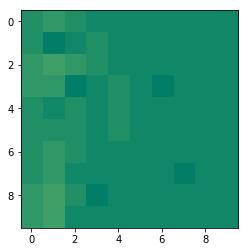

Step: 62
Updated position: [5 1]
Updated direction: [-1  0]


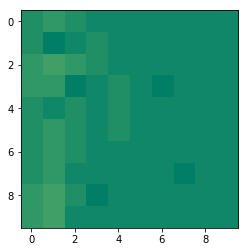

Step: 63
Updated position: [4 1]
Updated direction: [ 0 -1]


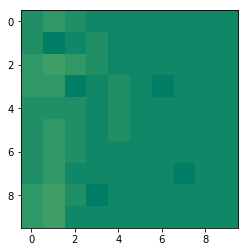

Step: 64
Updated position: [4 0]
Updated direction: [1 0]


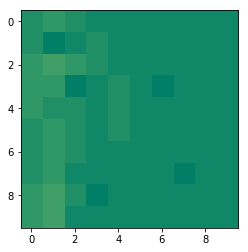

Step: 65
Updated position: [5 0]
Updated direction: [1 0]


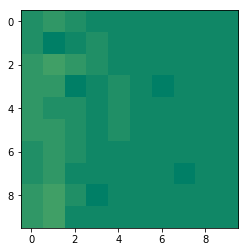

Step: 66
Updated position: [6 0]
Updated direction: [1 0]


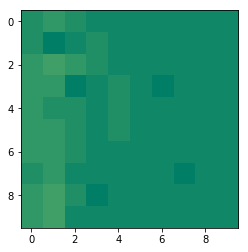

Step: 67
Updated position: [7 0]
Updated direction: [1 0]


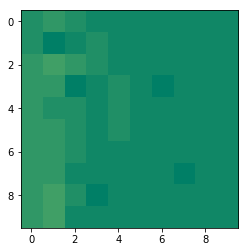

Step: 68
Updated position: [8 0]
Updated direction: [-1  0]


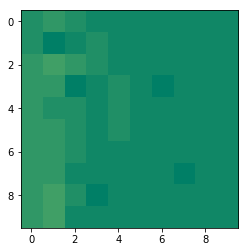

Step: 69
Updated position: [7 0]
Updated direction: [1 0]


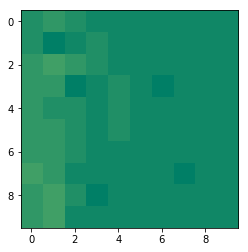

Step: 70
Updated position: [8 0]
Updated direction: [1 0]


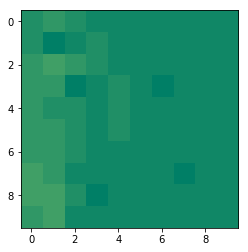

Step: 71
Updated position: [9 0]
Updated direction: [-1  0]


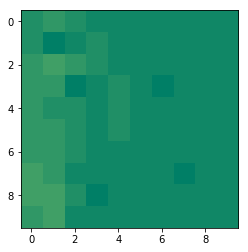

Step: 72
Updated position: [8 0]
Updated direction: [0 1]


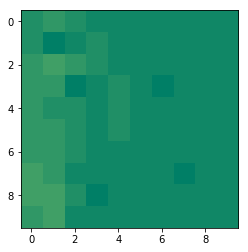

Step: 73
Updated position: [8 1]
Updated direction: [-1  0]


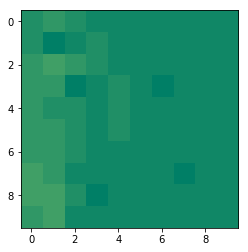

Step: 74
Updated position: [7 1]
Updated direction: [-1  0]


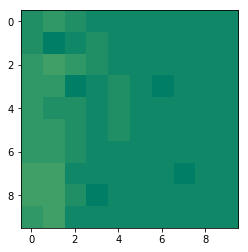

Step: 75
Updated position: [6 1]
Updated direction: [0 1]


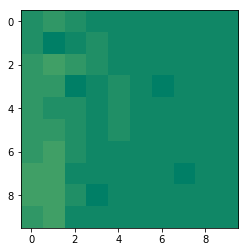

Step: 76
Updated position: [6 2]
Updated direction: [1 0]


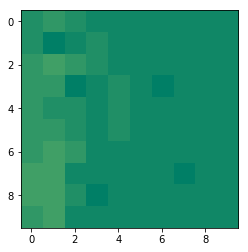

Step: 77
Updated position: [7 2]
Updated direction: [ 0 -1]


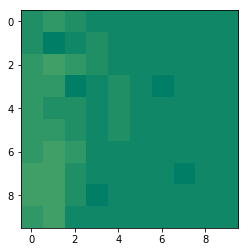

Step: 78
Updated position: [7 1]
Updated direction: [1 0]


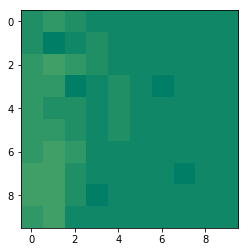

Step: 79
Updated position: [8 1]
Updated direction: [0 1]


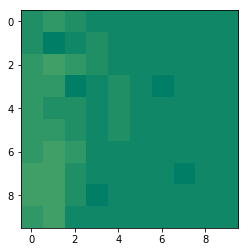

Step: 80
Updated position: [8 2]
Updated direction: [ 0 -1]


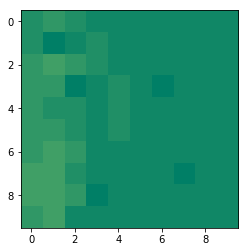

Step: 81
Updated position: [8 1]
Updated direction: [0 1]


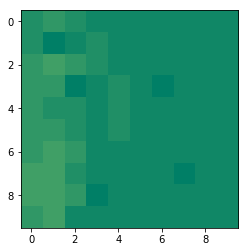

Step: 82
Updated position: [8 2]
Updated direction: [1 0]


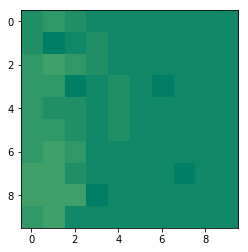

Step: 83
Updated position: [9 2]
Updated direction: [ 0 -1]


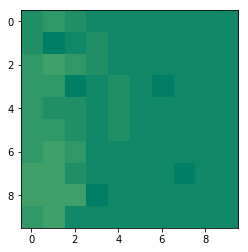

Step: 84
Updated position: [9 1]
Updated direction: [0 1]


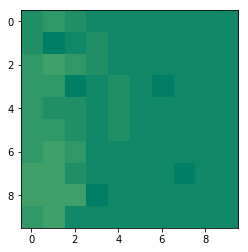

Step: 85
Updated position: [9 2]
Updated direction: [0 1]


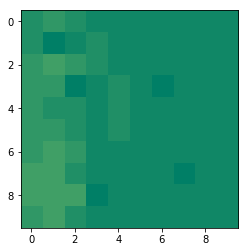

Step: 86
Updated position: [9 3]
Updated direction: [ 0 -1]


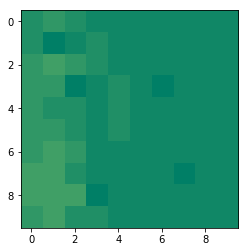

Step: 87
Updated position: [9 2]
Updated direction: [0 1]


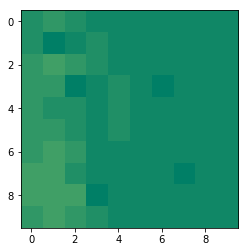

Step: 88
Updated position: [9 3]
Updated direction: [0 1]


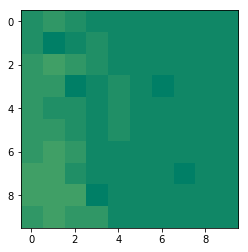

Step: 89
Updated position: [9 4]
Updated direction: [0 1]


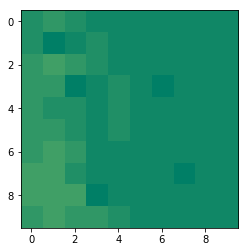

Step: 90
Updated position: [9 5]
Updated direction: [0 1]


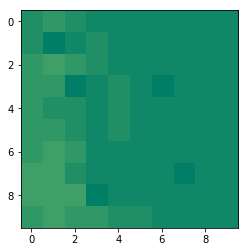

Step: 91
Updated position: [9 6]
Updated direction: [0 1]


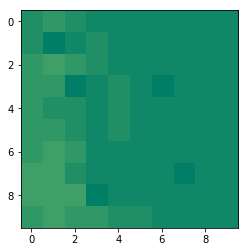

Step: 92
Updated position: [9 7]
Updated direction: [ 0 -1]


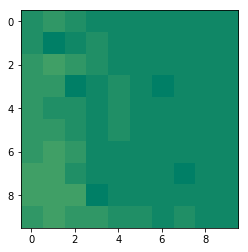

Step: 93
Updated position: [9 6]
Updated direction: [-1  0]


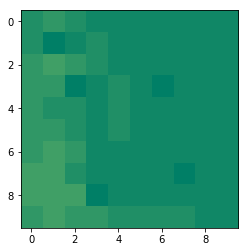

Step: 94
Updated position: [8 6]
Updated direction: [-1  0]


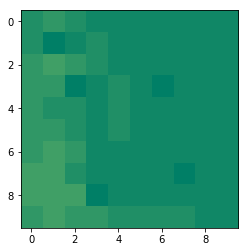

Step: 95
Updated position: [7 6]
Updated direction: [1 0]


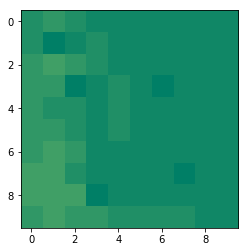

Step: 96
Updated position: [8 6]
Updated direction: [ 0 -1]


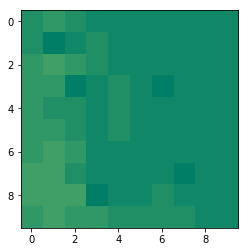

Step: 97
Updated position: [8 5]
Updated direction: [-1  0]


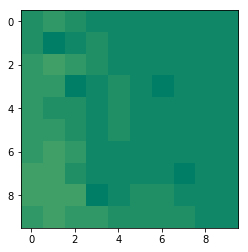

Step: 98
Updated position: [7 5]
Updated direction: [0 1]


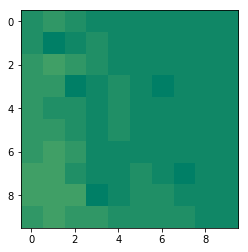

Step: 99
Updated position: [7 6]
Updated direction: [-1  0]


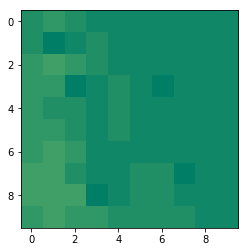

Step: 100
Updated position: [6 6]
Updated direction: [-1  0]


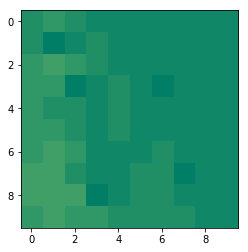

Step: 101
Updated position: [5 6]
Updated direction: [-1  0]


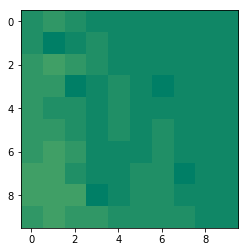

Step: 102
Updated position: [4 6]
Updated direction: [ 0 -1]


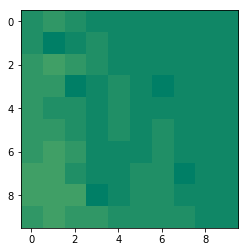

Step: 103
Updated position: [4 5]
Updated direction: [1 0]


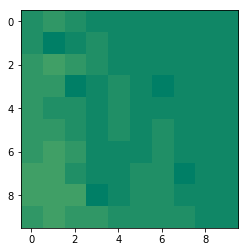

Step: 104
Updated position: [5 5]
Updated direction: [1 0]


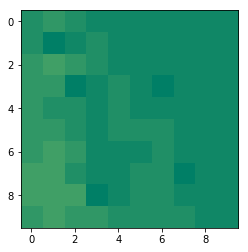

Step: 105
Updated position: [6 5]
Updated direction: [ 0 -1]


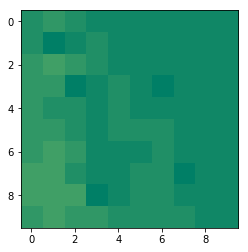

Step: 106
Updated position: [6 4]
Updated direction: [1 0]


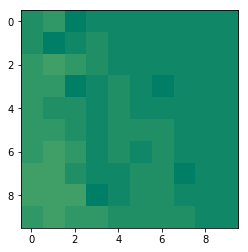

Step: 107
Updated position: [7 4]
Updated direction: [0 1]


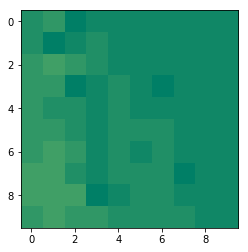

Step: 108
Updated position: [7 5]
Updated direction: [-1  0]


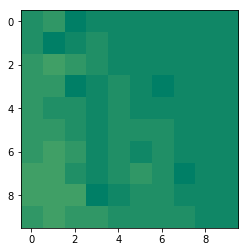

Step: 109
Updated position: [6 5]
Updated direction: [-1  0]


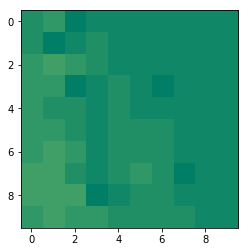

Step: 110
Updated position: [5 5]
Updated direction: [-1  0]


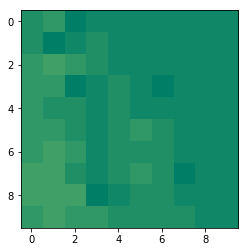

Step: 111
Updated position: [4 5]
Updated direction: [-1  0]


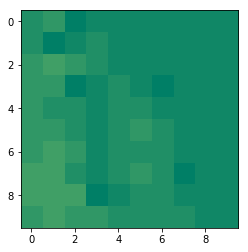

Step: 112
Updated position: [3 5]
Updated direction: [-1  0]


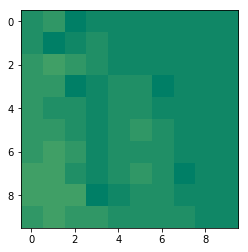

Step: 113
Updated position: [2 5]
Updated direction: [-1  0]


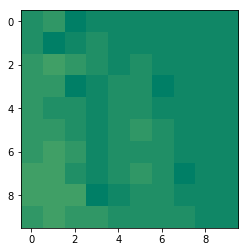

Step: 114
Updated position: [1 5]
Updated direction: [0 1]


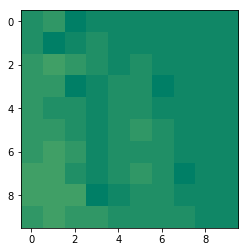

Step: 115
Updated position: [1 6]
Updated direction: [1 0]


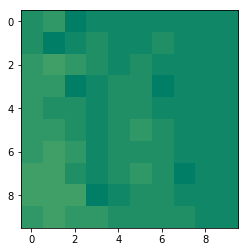

Step: 116
Updated position: [2 6]
Updated direction: [0 1]


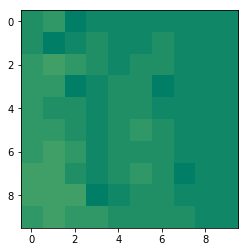

Step: 117
Updated position: [2 7]
Updated direction: [0 1]


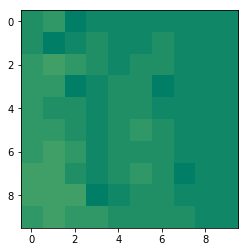

Step: 118
Updated position: [2 8]
Updated direction: [1 0]


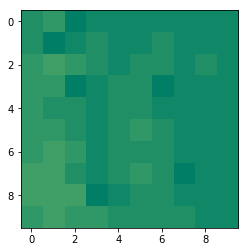

Step: 119
Updated position: [3 8]
Updated direction: [ 0 -1]


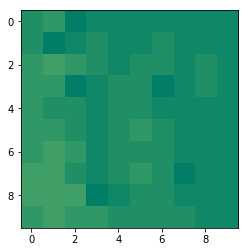

Step: 120
Updated position: [3 7]
Updated direction: [1 0]


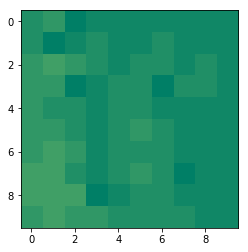

Step: 121
Updated position: [4 7]
Updated direction: [1 0]


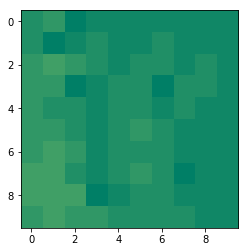

Step: 122
Updated position: [5 7]
Updated direction: [1 0]


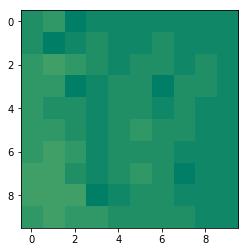

Step: 123
Updated position: [6 7]
Updated direction: [0 1]


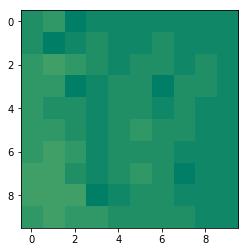

Step: 124
Updated position: [6 8]
Updated direction: [1 0]


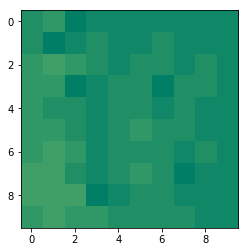

Step: 125
Updated position: [7 8]
Updated direction: [1 0]


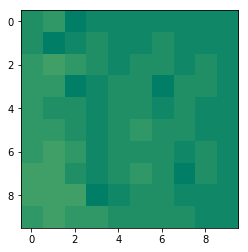

Step: 126
Updated position: [8 8]
Updated direction: [1 0]


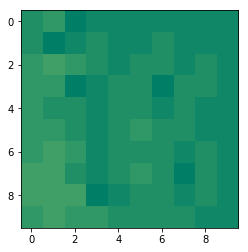

Step: 127
Updated position: [9 8]
Updated direction: [0 1]


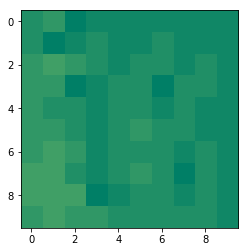

Step: 128
Updated position: [9 9]
Updated direction: [-1  0]


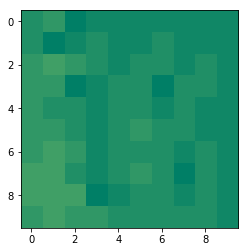

Step: 129
Updated position: [8 9]
Updated direction: [-1  0]


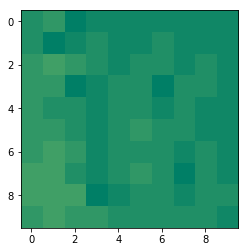

Step: 130
Updated position: [7 9]
Updated direction: [-1  0]


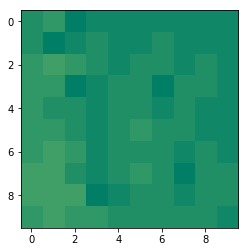

Step: 131
Updated position: [6 9]
Updated direction: [-1  0]


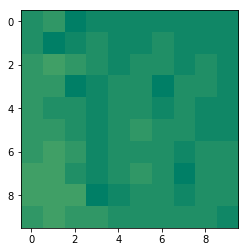

Step: 132
Updated position: [5 9]
Updated direction: [-1  0]


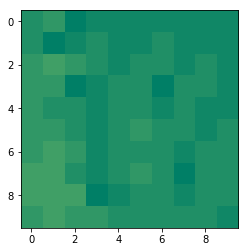

Step: 133
Updated position: [4 9]
Updated direction: [-1  0]


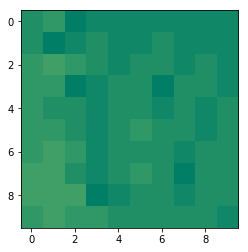

Step: 134
Updated position: [3 9]
Updated direction: [-1  0]


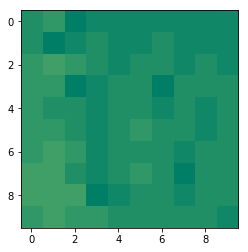

Step: 135
Updated position: [2 9]
Updated direction: [-1  0]


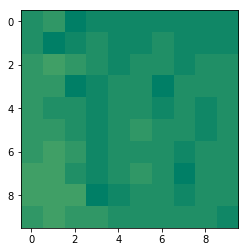

Step: 136
Updated position: [1 9]
Updated direction: [1 0]


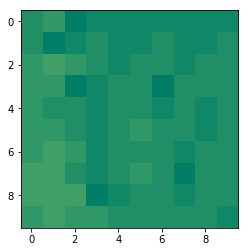

Step: 137
Updated position: [2 9]
Updated direction: [1 0]


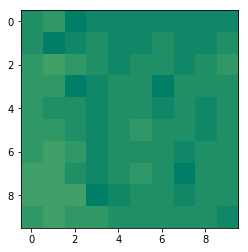

Step: 138
Updated position: [3 9]
Updated direction: [1 0]


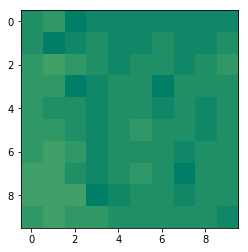

Step: 139
Updated position: [4 9]
Updated direction: [ 0 -1]


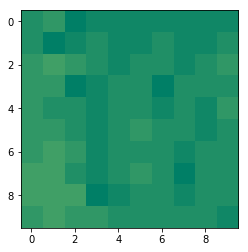

Step: 140
Updated position: [4 8]
Updated direction: [0 1]


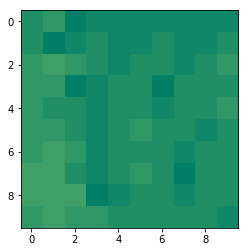

Step: 141
Updated position: [4 9]
Updated direction: [-1  0]


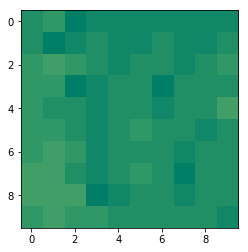

Step: 142
Updated position: [3 9]
Updated direction: [ 0 -1]


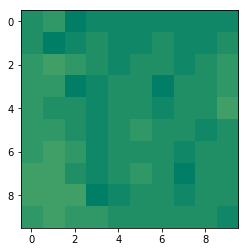

Step: 143
Updated position: [3 8]
Updated direction: [-1  0]


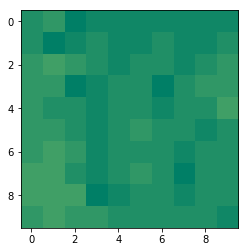

Step: 144
Updated position: [2 8]
Updated direction: [-1  0]


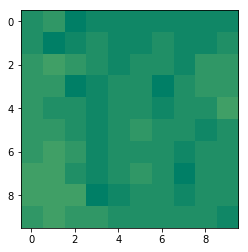

Step: 145
Updated position: [1 8]
Updated direction: [-1  0]


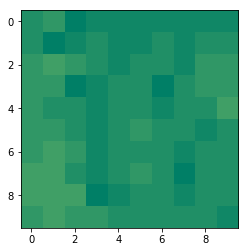

Step: 146
Updated position: [0 8]
Updated direction: [0 1]


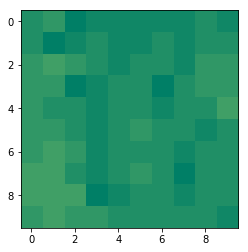

Step: 147
Updated position: [0 9]
Updated direction: [ 0 -1]


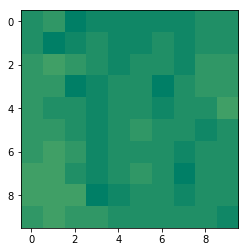

Step: 148
Updated position: [0 8]
Updated direction: [ 0 -1]


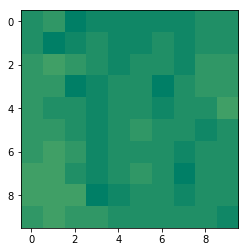

Step: 149
Updated position: [0 7]
Updated direction: [ 0 -1]


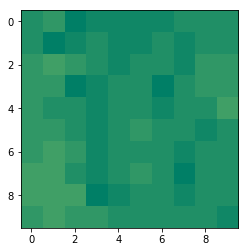

Step: 150
Updated position: [0 6]
Updated direction: [ 0 -1]


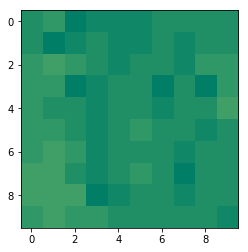

Step: 151
Updated position: [0 5]
Updated direction: [ 0 -1]


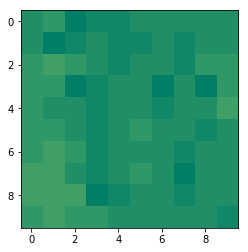

Step: 152
Updated position: [0 4]
Updated direction: [ 0 -1]


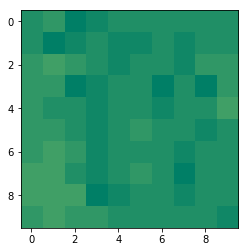

Step: 153
Updated position: [0 3]
Updated direction: [1 0]


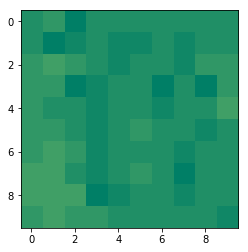

Step: 154
Updated position: [1 3]
Updated direction: [ 0 -1]


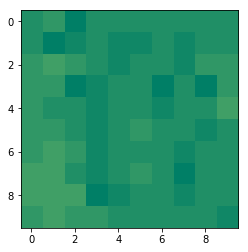

Step: 155
Updated position: [1 2]
Updated direction: [1 0]


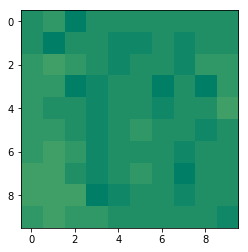

Step: 156
Updated position: [2 2]
Updated direction: [0 1]


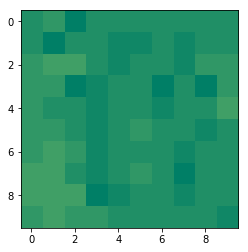

Step: 157
Updated position: [2 3]
Updated direction: [1 0]


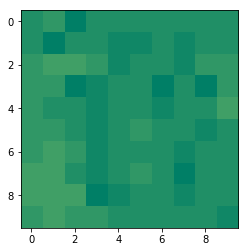

Step: 158
Updated position: [3 3]
Updated direction: [-1  0]


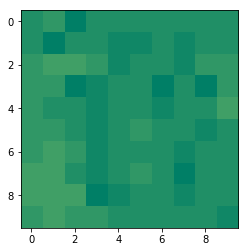

Step: 159
Updated position: [2 3]
Updated direction: [1 0]


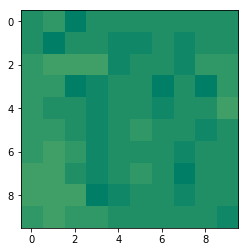

Step: 160
Updated position: [3 3]
Updated direction: [0 1]


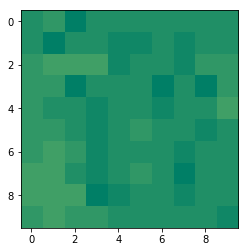

Step: 161
Updated position: [3 4]
Updated direction: [0 1]


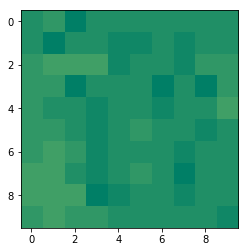

Step: 162
Updated position: [3 5]
Updated direction: [1 0]


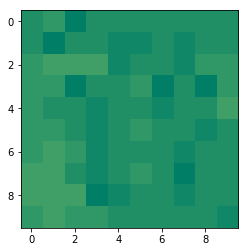

Step: 163
Updated position: [4 5]
Updated direction: [ 0 -1]


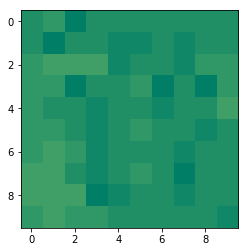

Step: 164
Updated position: [4 4]
Updated direction: [ 0 -1]


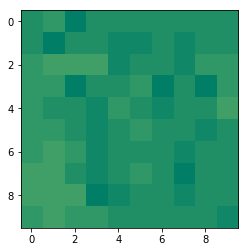

Step: 165
Updated position: [4 3]
Updated direction: [1 0]


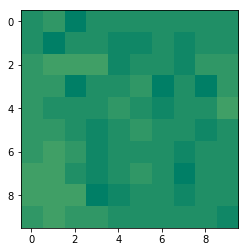

Step: 166
Updated position: [5 3]
Updated direction: [-1  0]


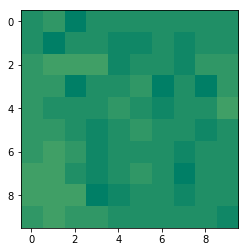

Step: 167
Updated position: [4 3]
Updated direction: [1 0]


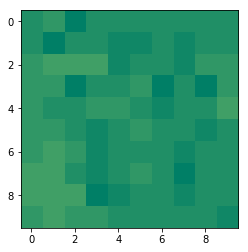

Step: 168
Updated position: [5 3]
Updated direction: [1 0]


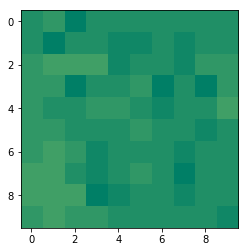

Step: 169
Updated position: [6 3]
Updated direction: [1 0]


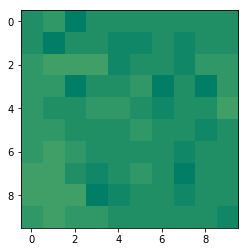

Step: 170
Updated position: [7 3]
Updated direction: [-1  0]


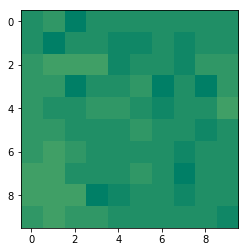

Step: 171
Updated position: [6 3]
Updated direction: [1 0]


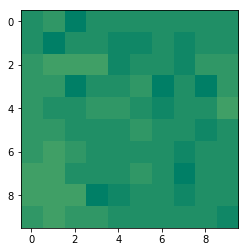

Step: 172
Updated position: [7 3]
Updated direction: [-1  0]


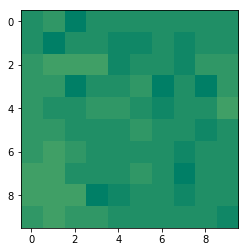

Step: 173
Updated position: [6 3]
Updated direction: [1 0]


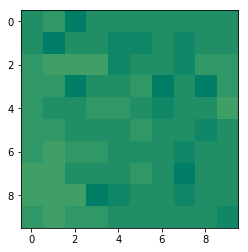

Step: 174
Updated position: [7 3]
Updated direction: [0 1]


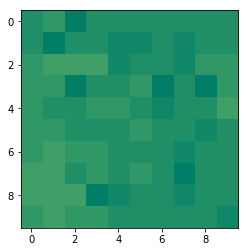

Step: 175
Updated position: [7 4]
Updated direction: [1 0]


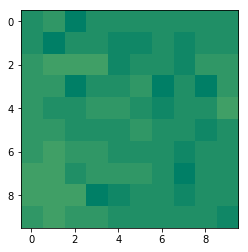

Step: 176
Updated position: [8 4]
Updated direction: [1 0]


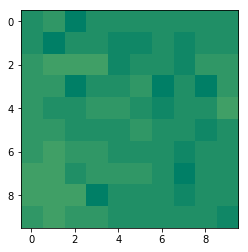

Step: 177
Updated position: [9 4]
Updated direction: [0 1]


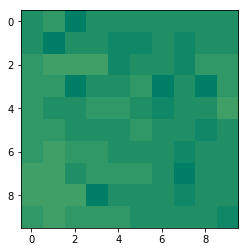

Step: 178
Updated position: [9 5]
Updated direction: [ 0 -1]


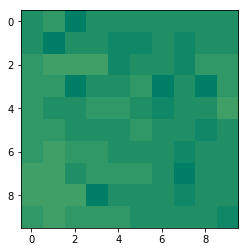

Step: 179
Updated position: [9 4]
Updated direction: [0 1]


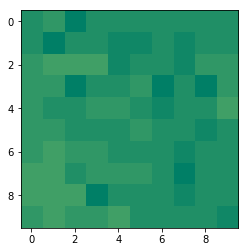

Step: 180
Updated position: [9 5]
Updated direction: [0 1]


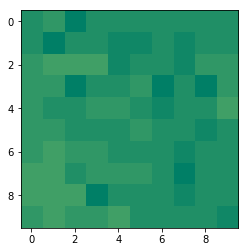

Step: 181
Updated position: [9 6]
Updated direction: [0 1]


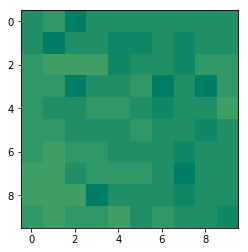

Step: 182
Updated position: [9 7]
Updated direction: [-1  0]


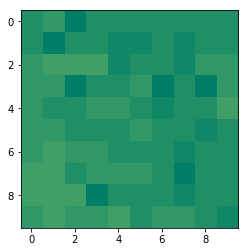

Step: 183
Updated position: [8 7]
Updated direction: [ 0 -1]


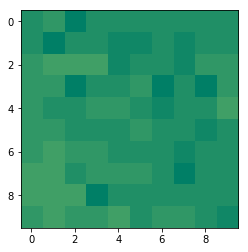

Step: 184
Updated position: [8 6]
Updated direction: [ 0 -1]


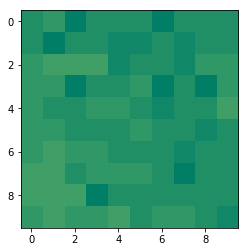

Step: 185
Updated position: [8 5]
Updated direction: [0 1]


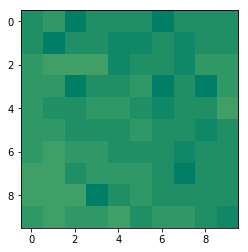

Step: 186
Updated position: [8 6]
Updated direction: [-1  0]


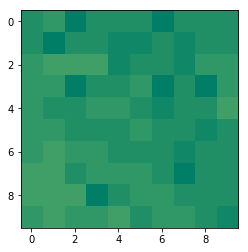

Step: 187
Updated position: [7 6]
Updated direction: [-1  0]


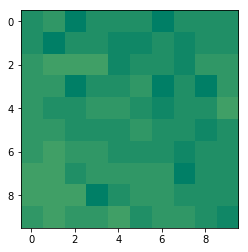

Step: 188
Updated position: [6 6]
Updated direction: [0 1]


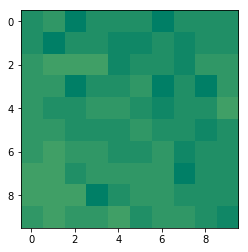

Step: 189
Updated position: [6 7]
Updated direction: [0 1]


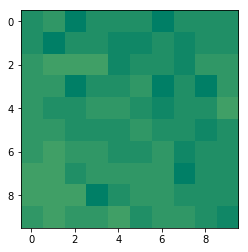

Step: 190
Updated position: [6 8]
Updated direction: [-1  0]


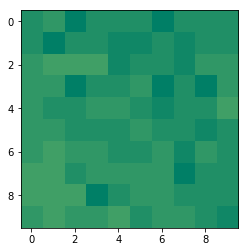

Step: 191
Updated position: [5 8]
Updated direction: [1 0]


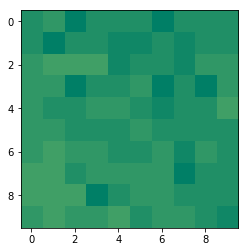

Step: 192
Updated position: [6 8]
Updated direction: [0 1]


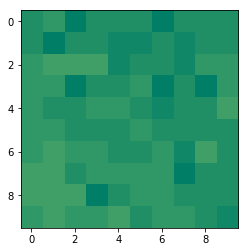

Step: 193
Updated position: [6 9]
Updated direction: [1 0]


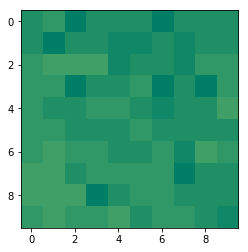

Step: 194
Updated position: [7 9]
Updated direction: [1 0]


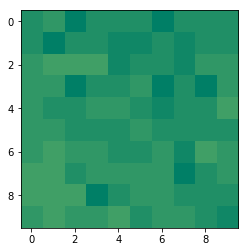

Step: 195
Updated position: [8 9]
Updated direction: [ 0 -1]


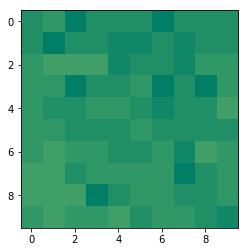

Step: 196
Updated position: [8 8]
Updated direction: [1 0]


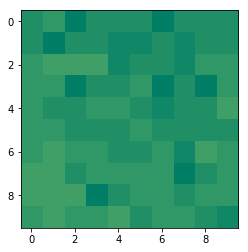

Step: 197
Updated position: [9 8]
Updated direction: [0 1]


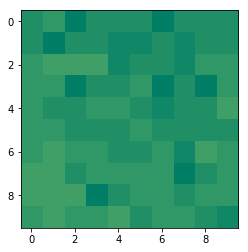

Step: 198
Updated position: [9 9]
Updated direction: [ 0 -1]


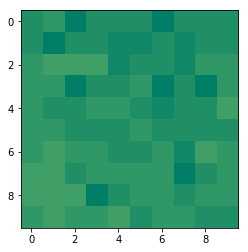

Step: 199
Updated position: [9 8]
Updated direction: [0 1]


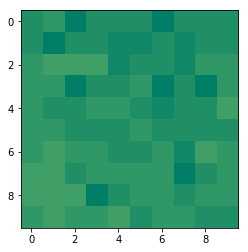

Step: 200
Updated position: [9 9]
Updated direction: [ 0 -1]


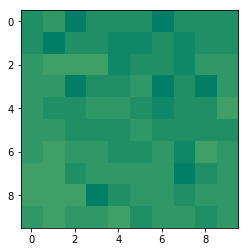

Step: 201
Updated position: [9 8]
Updated direction: [ 0 -1]


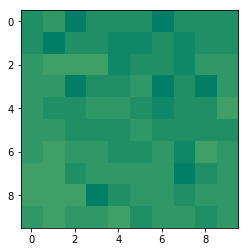

Step: 202
Updated position: [9 7]
Updated direction: [ 0 -1]


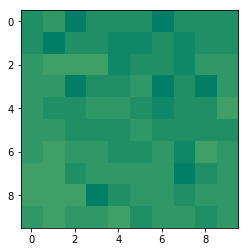

Step: 203
Updated position: [9 6]
Updated direction: [ 0 -1]


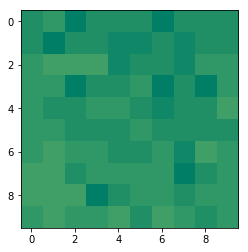

Step: 204
Updated position: [9 5]
Updated direction: [-1  0]


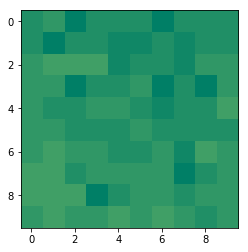

Step: 205
Updated position: [8 5]
Updated direction: [ 0 -1]


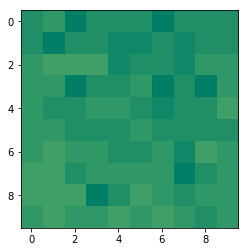

Step: 206
Updated position: [8 4]
Updated direction: [-1  0]


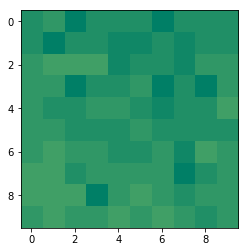

Step: 207
Updated position: [7 4]
Updated direction: [-1  0]


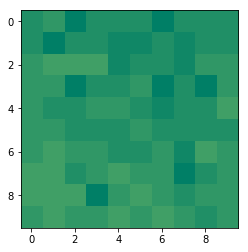

Step: 208
Updated position: [6 4]
Updated direction: [-1  0]


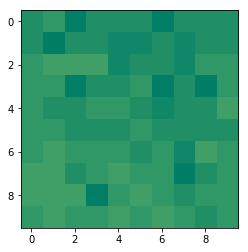

Step: 209
Updated position: [5 4]
Updated direction: [1 0]


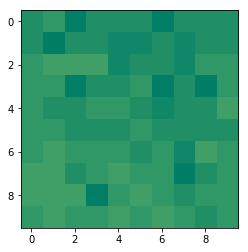

Step: 210
Updated position: [6 4]
Updated direction: [-1  0]


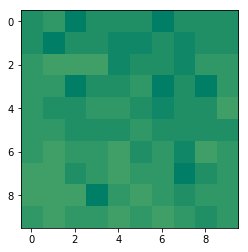

Step: 211
Updated position: [5 4]
Updated direction: [ 0 -1]


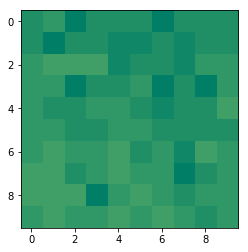

Step: 212
Updated position: [5 3]
Updated direction: [ 0 -1]


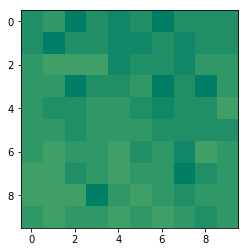

Step: 213
Updated position: [5 2]
Updated direction: [-1  0]


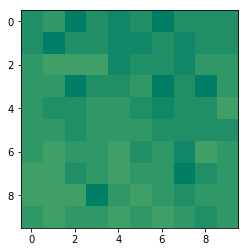

Step: 214
Updated position: [4 2]
Updated direction: [1 0]


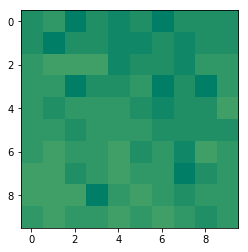

Step: 215
Updated position: [5 2]
Updated direction: [ 0 -1]


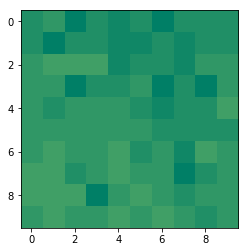

Step: 216
Updated position: [5 1]
Updated direction: [-1  0]


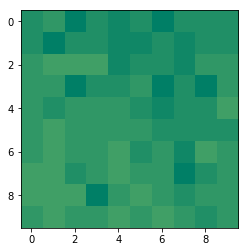

Step: 217
Updated position: [4 1]
Updated direction: [-1  0]


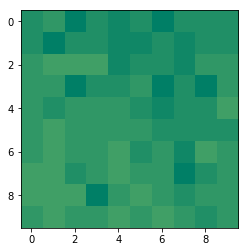

Step: 218
Updated position: [3 1]
Updated direction: [1 0]


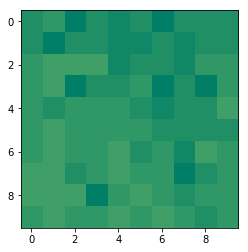

Step: 219
Updated position: [4 1]
Updated direction: [ 0 -1]


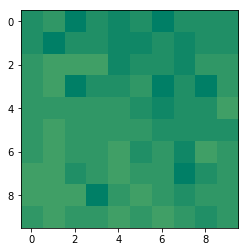

Step: 220
Updated position: [4 0]
Updated direction: [1 0]


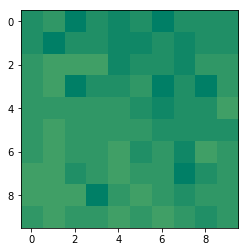

Step: 221
Updated position: [5 0]
Updated direction: [0 1]


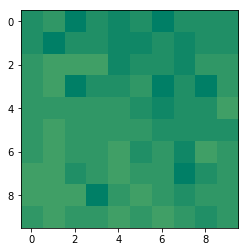

Step: 222
Updated position: [5 1]
Updated direction: [0 1]


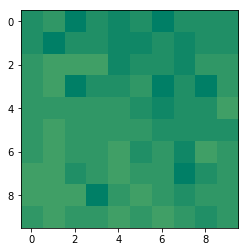

Step: 223
Updated position: [5 2]
Updated direction: [1 0]


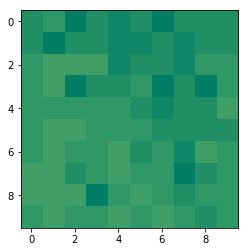

Step: 224
Updated position: [6 2]
Updated direction: [1 0]


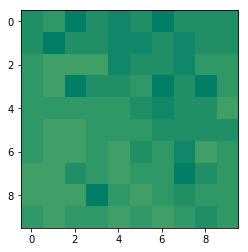

Step: 225
Updated position: [7 2]
Updated direction: [0 1]


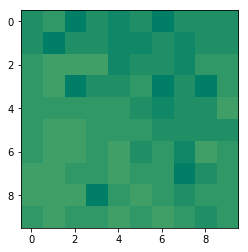

Step: 226
Updated position: [7 3]
Updated direction: [-1  0]


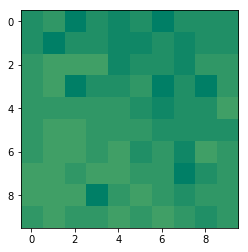

Step: 227
Updated position: [6 3]
Updated direction: [-1  0]


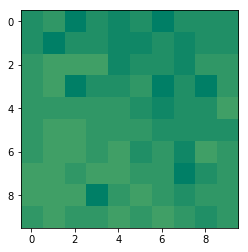

Step: 228
Updated position: [5 3]
Updated direction: [1 0]


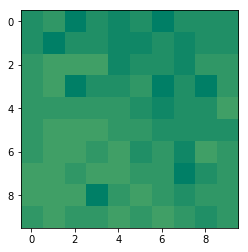

Step: 229
Updated position: [6 3]
Updated direction: [ 0 -1]


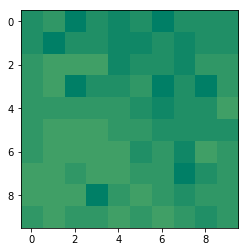

Step: 230
Updated position: [6 2]
Updated direction: [1 0]


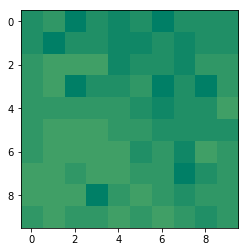

Step: 231
Updated position: [7 2]
Updated direction: [0 1]


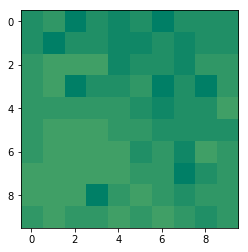

Step: 232
Updated position: [7 3]
Updated direction: [-1  0]


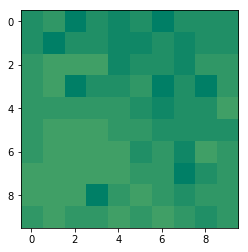

Step: 233
Updated position: [6 3]
Updated direction: [1 0]


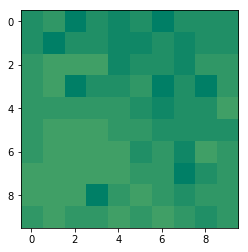

Step: 234
Updated position: [7 3]
Updated direction: [-1  0]


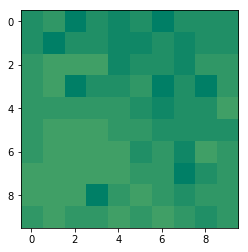

Step: 235
Updated position: [6 3]
Updated direction: [1 0]


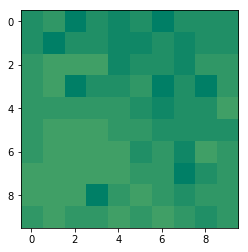

Step: 236
Updated position: [7 3]
Updated direction: [-1  0]


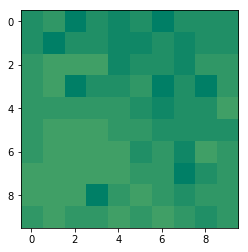

Step: 237
Updated position: [6 3]
Updated direction: [0 1]


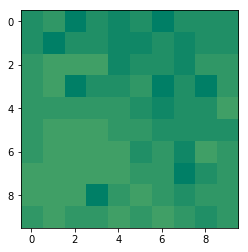

Step: 238
Updated position: [6 4]
Updated direction: [1 0]


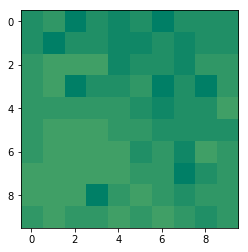

Step: 239
Updated position: [7 4]
Updated direction: [ 0 -1]


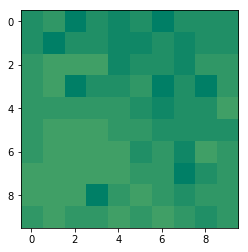

Step: 240
Updated position: [7 3]
Updated direction: [-1  0]


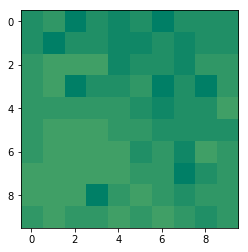

Step: 241
Updated position: [6 3]
Updated direction: [1 0]


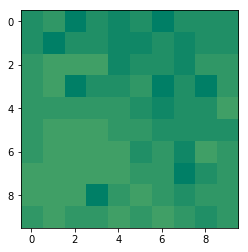

Step: 242
Updated position: [7 3]
Updated direction: [-1  0]


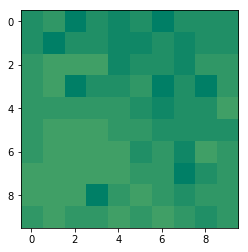

Step: 243
Updated position: [6 3]
Updated direction: [ 0 -1]


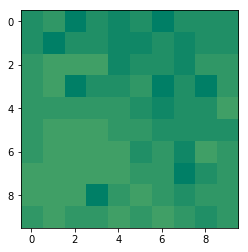

Step: 244
Updated position: [6 2]
Updated direction: [-1  0]


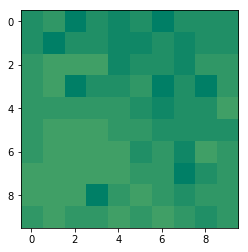

Step: 245
Updated position: [5 2]
Updated direction: [-1  0]


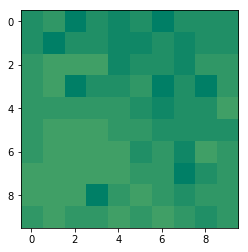

Step: 246
Updated position: [4 2]
Updated direction: [ 0 -1]


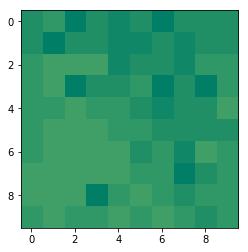

Step: 247
Updated position: [4 1]
Updated direction: [ 0 -1]


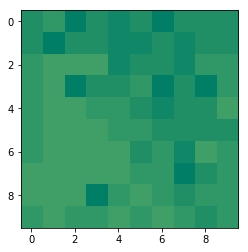

Step: 248
Updated position: [4 0]
Updated direction: [1 0]


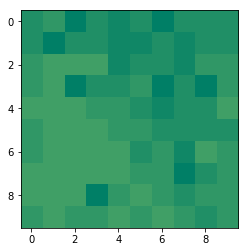

Step: 249
Updated position: [5 0]
Updated direction: [1 0]


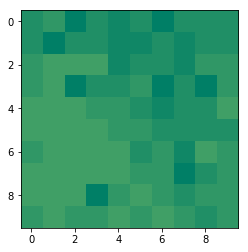

Step: 250
Updated position: [6 0]
Updated direction: [1 0]


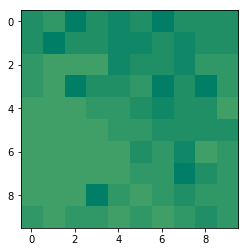

Step: 251
Updated position: [7 0]
Updated direction: [-1  0]


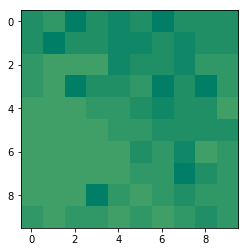

Step: 252
Updated position: [6 0]
Updated direction: [1 0]


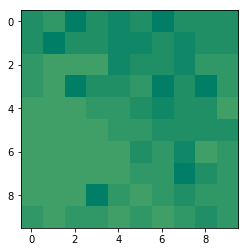

Step: 253
Updated position: [7 0]
Updated direction: [1 0]


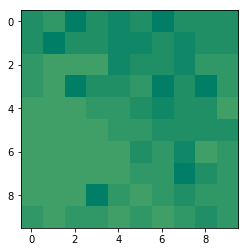

Step: 254
Updated position: [8 0]
Updated direction: [0 1]


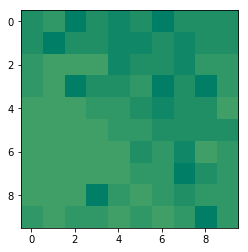

Step: 255
Updated position: [8 1]
Updated direction: [1 0]


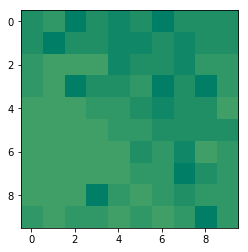

Step: 256
Updated position: [9 1]
Updated direction: [ 0 -1]


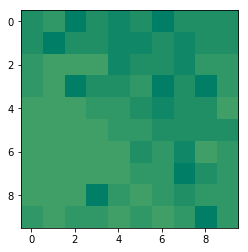

Step: 257
Updated position: [9 0]
Updated direction: [0 1]


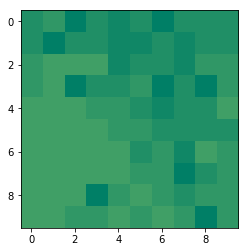

Step: 258
Updated position: [9 1]
Updated direction: [ 0 -1]


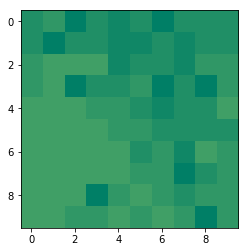

Step: 259
Updated position: [9 0]
Updated direction: [-1  0]


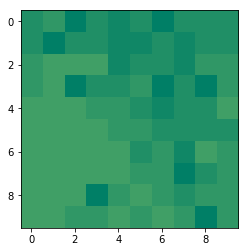

Step: 260
Updated position: [8 0]
Updated direction: [1 0]


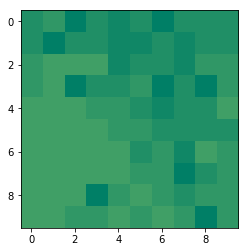

Step: 261
Updated position: [9 0]
Updated direction: [0 1]


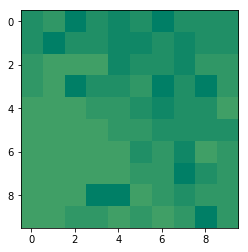

Step: 262
Updated position: [9 1]
Updated direction: [ 0 -1]


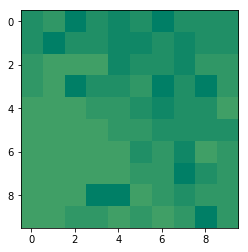

Step: 263
Updated position: [9 0]
Updated direction: [0 1]


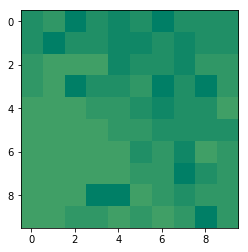

Step: 264
Updated position: [9 1]
Updated direction: [0 1]


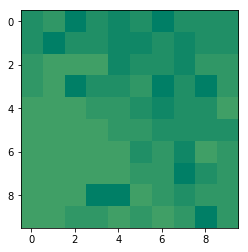

Step: 265
Updated position: [9 2]
Updated direction: [0 1]


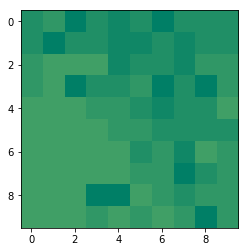

Step: 266
Updated position: [9 3]
Updated direction: [ 0 -1]


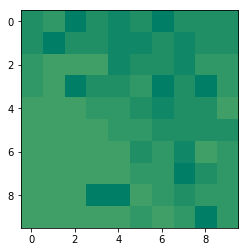

Step: 267
Updated position: [9 2]
Updated direction: [ 0 -1]


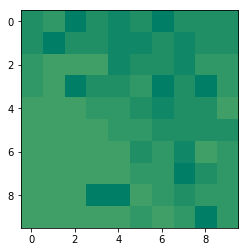

Step: 268
Updated position: [9 1]
Updated direction: [-1  0]


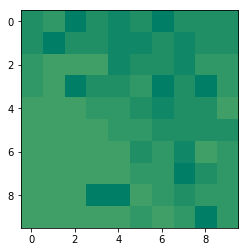

Step: 269
Updated position: [8 1]
Updated direction: [1 0]


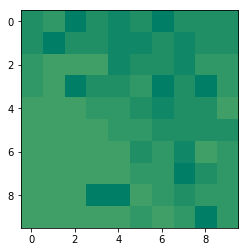

Step: 270
Updated position: [9 1]
Updated direction: [ 0 -1]


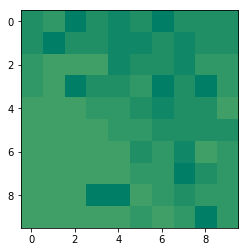

Step: 271
Updated position: [9 0]
Updated direction: [-1  0]


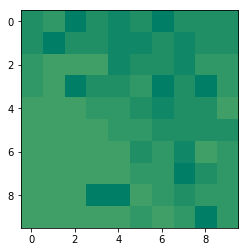

Step: 272
Updated position: [8 0]
Updated direction: [0 1]


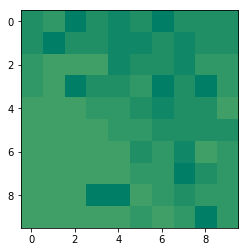

Step: 273
Updated position: [8 1]
Updated direction: [1 0]


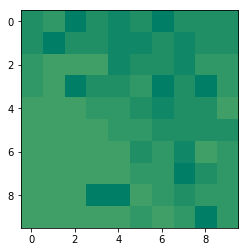

Step: 274
Updated position: [9 1]
Updated direction: [-1  0]


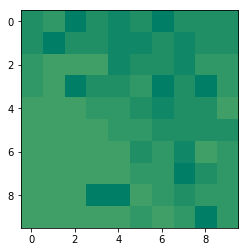

Step: 275
Updated position: [8 1]
Updated direction: [ 0 -1]


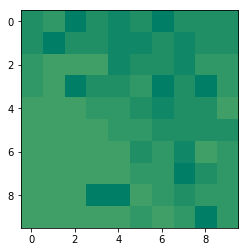

Step: 276
Updated position: [8 0]
Updated direction: [1 0]


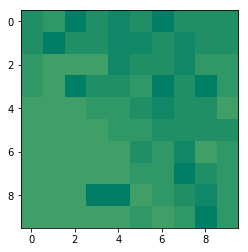

Step: 277
Updated position: [9 0]
Updated direction: [0 1]


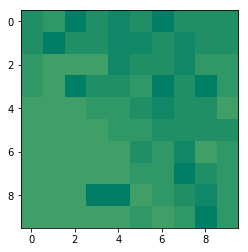

Step: 278
Updated position: [9 1]
Updated direction: [ 0 -1]


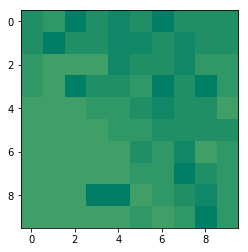

Step: 279
Updated position: [9 0]
Updated direction: [0 1]


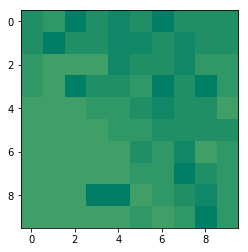

Step: 280
Updated position: [9 1]
Updated direction: [0 1]


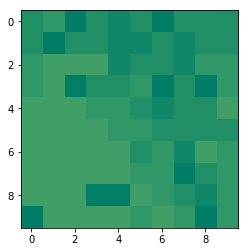

Step: 281
Updated position: [9 2]
Updated direction: [-1  0]


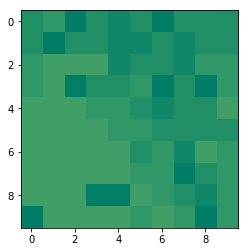

Step: 282
Updated position: [8 2]
Updated direction: [1 0]


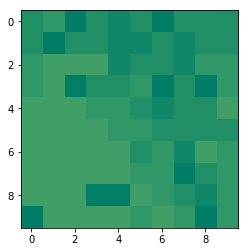

Step: 283
Updated position: [9 2]
Updated direction: [ 0 -1]


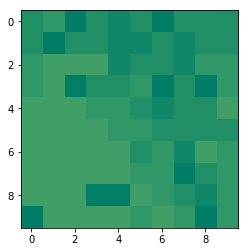

Step: 284
Updated position: [9 1]
Updated direction: [0 1]


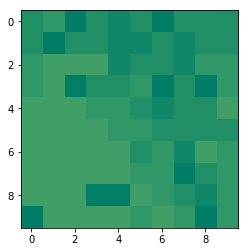

Step: 285
Updated position: [9 2]
Updated direction: [ 0 -1]


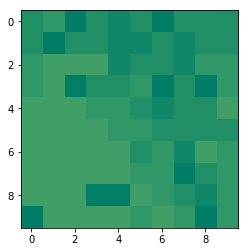

Step: 286
Updated position: [9 1]
Updated direction: [0 1]


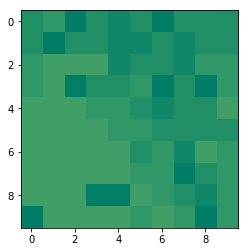

Step: 287
Updated position: [9 2]
Updated direction: [ 0 -1]


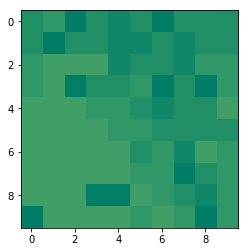

Step: 288
Updated position: [9 1]
Updated direction: [0 1]


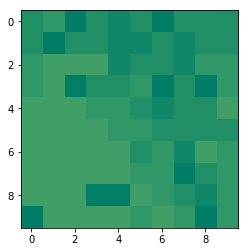

Step: 289
Updated position: [9 2]
Updated direction: [ 0 -1]


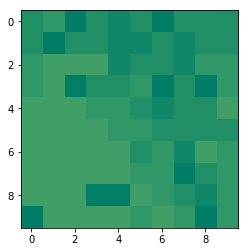

Step: 290
Updated position: [9 1]
Updated direction: [-1  0]


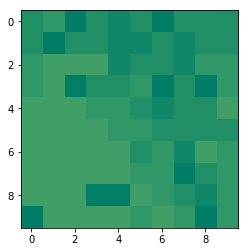

Step: 291
Updated position: [8 1]
Updated direction: [1 0]


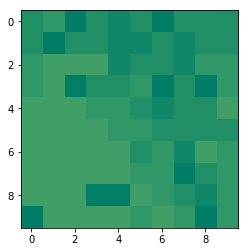

Step: 292
Updated position: [9 1]
Updated direction: [-1  0]


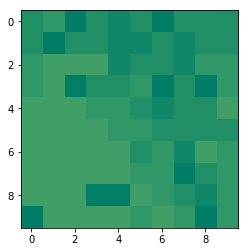

Step: 293
Updated position: [8 1]
Updated direction: [1 0]


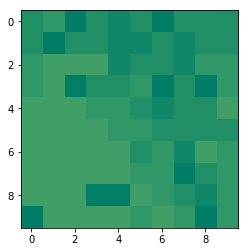

Step: 294
Updated position: [9 1]
Updated direction: [0 1]


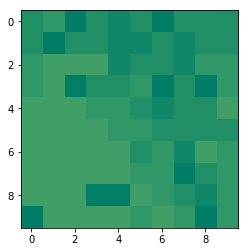

Step: 295
Updated position: [9 2]
Updated direction: [ 0 -1]


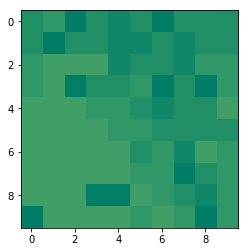

Step: 296
Updated position: [9 1]
Updated direction: [0 1]


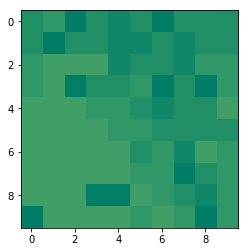

Step: 297
Updated position: [9 2]
Updated direction: [ 0 -1]


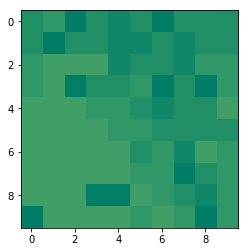

Step: 298
Updated position: [9 1]
Updated direction: [0 1]


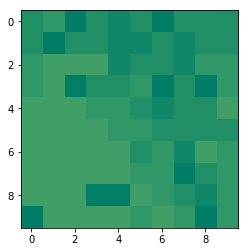

Step: 299
Updated position: [9 2]
Updated direction: [-1  0]


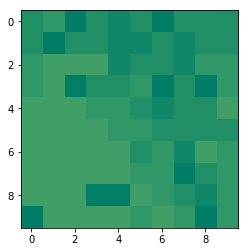

Step: 300
Updated position: [8 2]
Updated direction: [1 0]


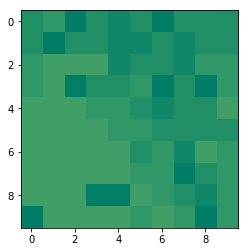

Step: 301
Updated position: [9 2]
Updated direction: [-1  0]


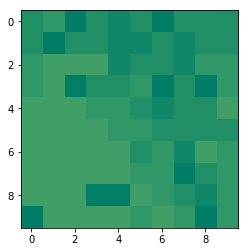

Step: 302
Updated position: [8 2]
Updated direction: [-1  0]


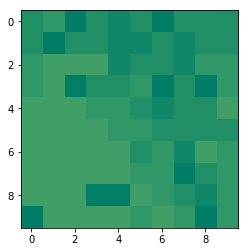

Step: 303
Updated position: [7 2]
Updated direction: [ 0 -1]


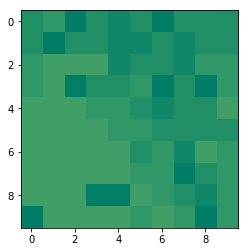

Step: 304
Updated position: [7 1]
Updated direction: [1 0]


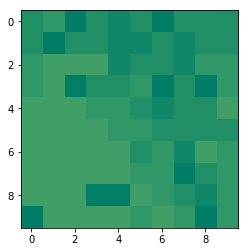

Step: 305
Updated position: [8 1]
Updated direction: [-1  0]


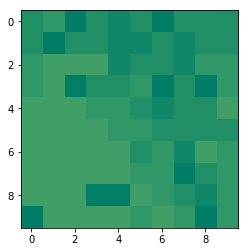

Step: 306
Updated position: [7 1]
Updated direction: [-1  0]


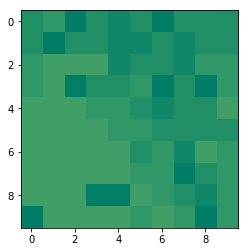

Step: 307
Updated position: [6 1]
Updated direction: [1 0]


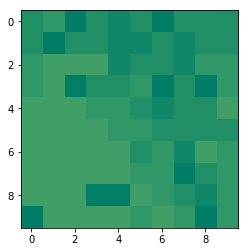

Step: 308
Updated position: [7 1]
Updated direction: [1 0]


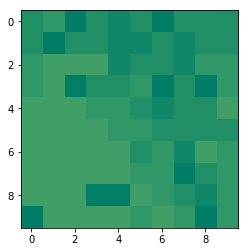

Step: 309
Updated position: [8 1]
Updated direction: [0 1]


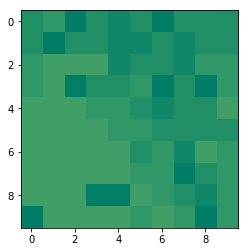

Step: 310
Updated position: [8 2]
Updated direction: [ 0 -1]


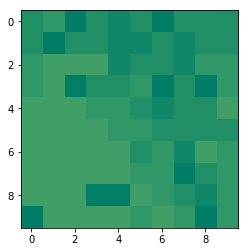

Step: 311
Updated position: [8 1]
Updated direction: [1 0]


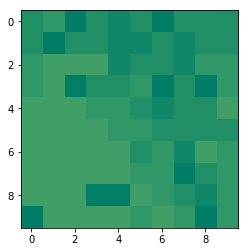

Step: 312
Updated position: [9 1]
Updated direction: [0 1]


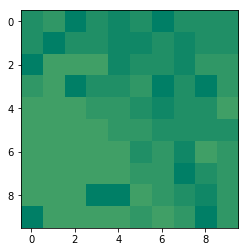

Step: 313
Updated position: [9 2]
Updated direction: [ 0 -1]


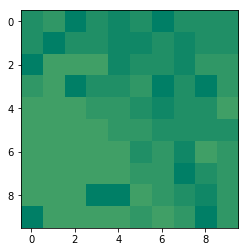

Step: 314
Updated position: [9 1]
Updated direction: [-1  0]


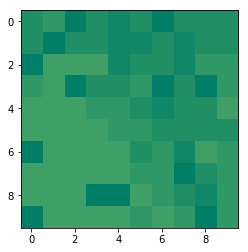

Step: 315
Updated position: [8 1]
Updated direction: [1 0]


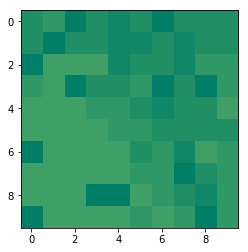

Step: 316
Updated position: [9 1]
Updated direction: [0 1]


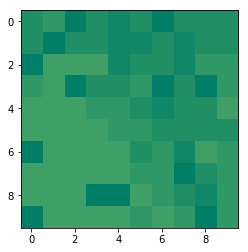

Step: 317
Updated position: [9 2]
Updated direction: [ 0 -1]


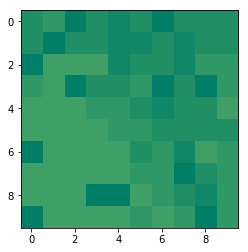

Step: 318
Updated position: [9 1]
Updated direction: [0 1]


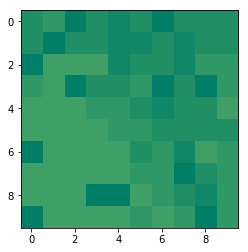

Step: 319
Updated position: [9 2]
Updated direction: [-1  0]


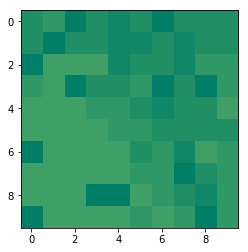

Step: 320
Updated position: [8 2]
Updated direction: [1 0]


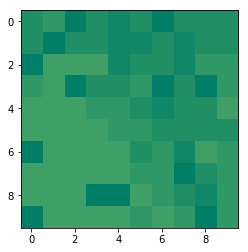

Step: 321
Updated position: [9 2]
Updated direction: [ 0 -1]


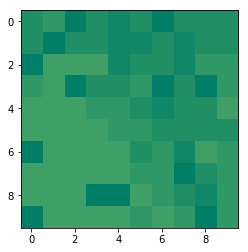

Step: 322
Updated position: [9 1]
Updated direction: [-1  0]


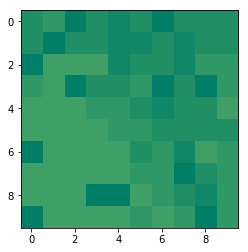

Step: 323
Updated position: [8 1]
Updated direction: [0 1]


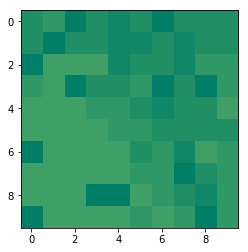

Step: 324
Updated position: [8 2]
Updated direction: [1 0]


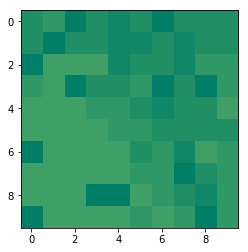

Step: 325
Updated position: [9 2]
Updated direction: [ 0 -1]


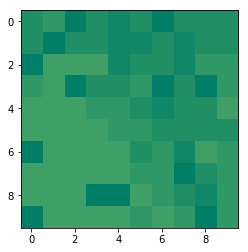

Step: 326
Updated position: [9 1]
Updated direction: [0 1]


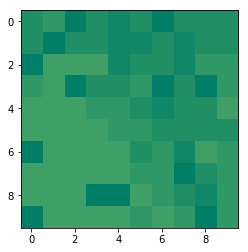

Step: 327
Updated position: [9 2]
Updated direction: [-1  0]


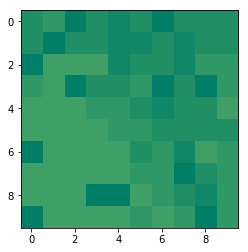

Step: 328
Updated position: [8 2]
Updated direction: [1 0]


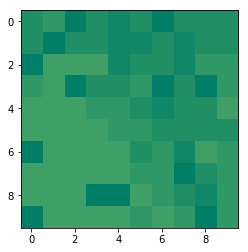

Step: 329
Updated position: [9 2]
Updated direction: [0 1]


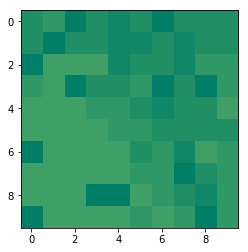

Step: 330
Updated position: [9 3]
Updated direction: [ 0 -1]


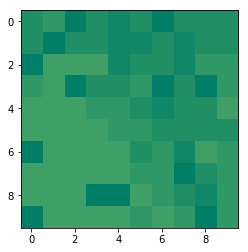

Step: 331
Updated position: [9 2]
Updated direction: [ 0 -1]


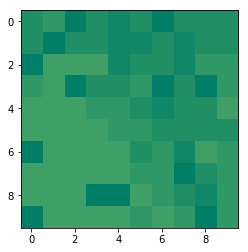

Step: 332
Updated position: [9 1]
Updated direction: [-1  0]


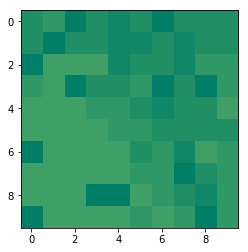

Step: 333
Updated position: [8 1]
Updated direction: [1 0]


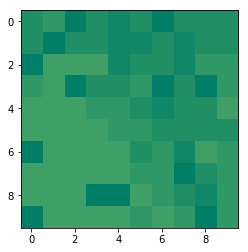

Step: 334
Updated position: [9 1]
Updated direction: [0 1]


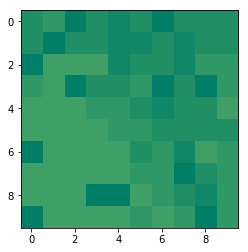

Step: 335
Updated position: [9 2]
Updated direction: [ 0 -1]


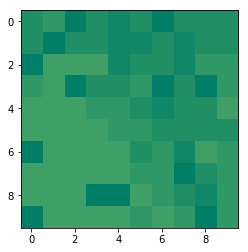

Step: 336
Updated position: [9 1]
Updated direction: [0 1]


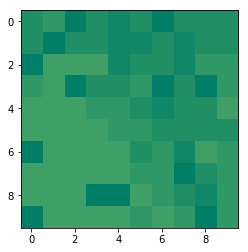

Step: 337
Updated position: [9 2]
Updated direction: [-1  0]


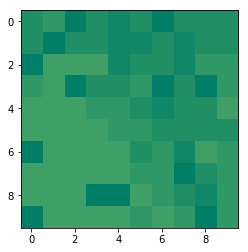

Step: 338
Updated position: [8 2]
Updated direction: [1 0]


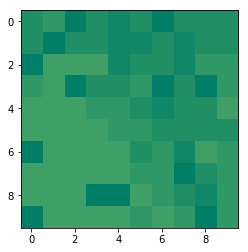

Step: 339
Updated position: [9 2]
Updated direction: [ 0 -1]


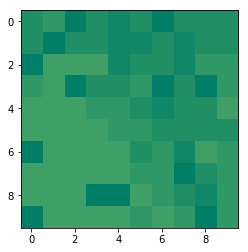

Step: 340
Updated position: [9 1]
Updated direction: [0 1]


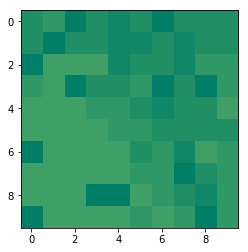

Step: 341
Updated position: [9 2]
Updated direction: [ 0 -1]


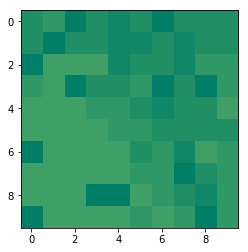

Step: 342
Updated position: [9 1]
Updated direction: [0 1]


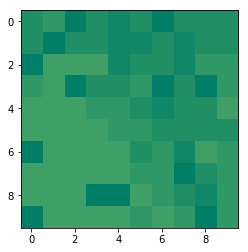

Step: 343
Updated position: [9 2]
Updated direction: [ 0 -1]


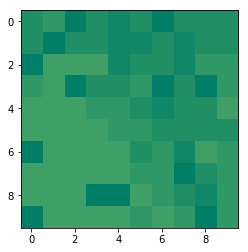

Step: 344
Updated position: [9 1]
Updated direction: [-1  0]


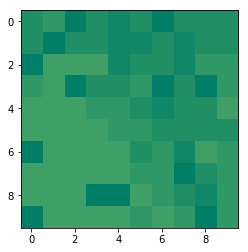

Step: 345
Updated position: [8 1]
Updated direction: [1 0]


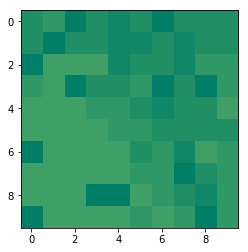

Step: 346
Updated position: [9 1]
Updated direction: [0 1]


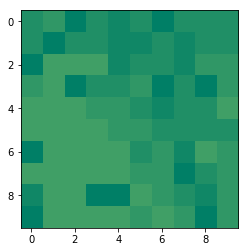

Step: 347
Updated position: [9 2]
Updated direction: [ 0 -1]


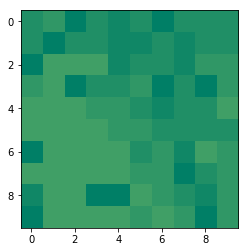

Step: 348
Updated position: [9 1]
Updated direction: [-1  0]


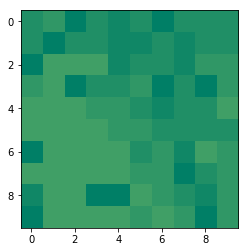

Step: 349
Updated position: [8 1]
Updated direction: [0 1]


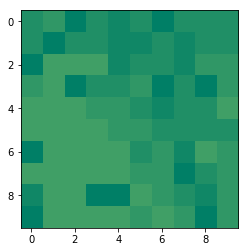

Step: 350
Updated position: [8 2]
Updated direction: [1 0]


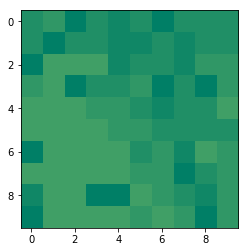

Step: 351
Updated position: [9 2]
Updated direction: [ 0 -1]


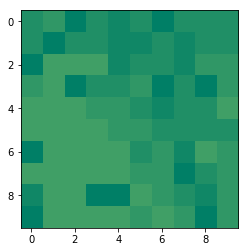

Step: 352
Updated position: [9 1]
Updated direction: [0 1]


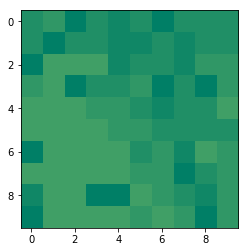

Step: 353
Updated position: [9 2]
Updated direction: [ 0 -1]


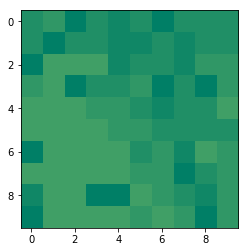

Step: 354
Updated position: [9 1]
Updated direction: [0 1]


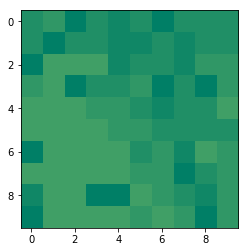

Step: 355
Updated position: [9 2]
Updated direction: [ 0 -1]


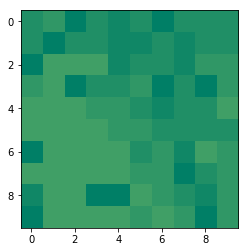

Step: 356
Updated position: [9 1]
Updated direction: [0 1]


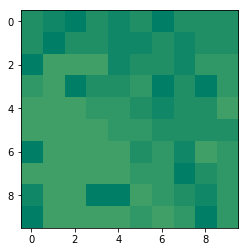

Step: 357
Updated position: [9 2]
Updated direction: [-1  0]


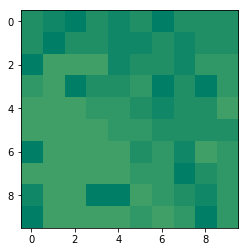

Step: 358
Updated position: [8 2]
Updated direction: [ 0 -1]


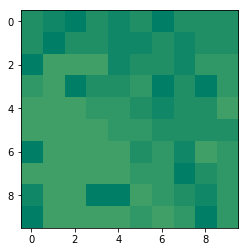

Step: 359
Updated position: [8 1]
Updated direction: [ 0 -1]


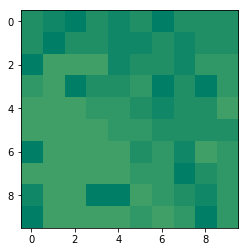

Step: 360
Updated position: [8 0]
Updated direction: [-1  0]


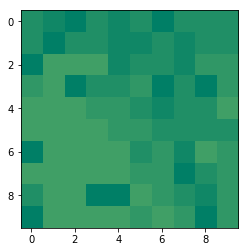

Step: 361
Updated position: [7 0]
Updated direction: [1 0]


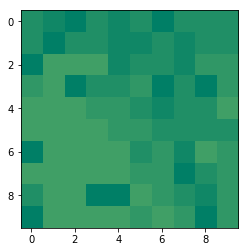

Step: 362
Updated position: [8 0]
Updated direction: [-1  0]


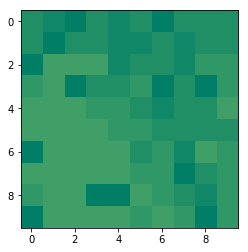

Step: 363
Updated position: [7 0]
Updated direction: [1 0]


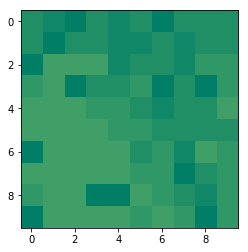

Step: 364
Updated position: [8 0]
Updated direction: [0 1]


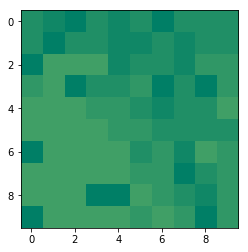

Step: 365
Updated position: [8 1]
Updated direction: [ 0 -1]


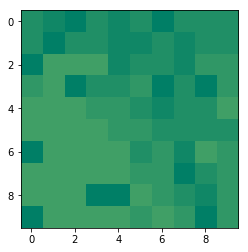

Step: 366
Updated position: [8 0]
Updated direction: [0 1]


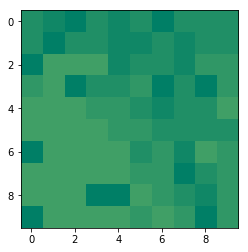

Step: 367
Updated position: [8 1]
Updated direction: [-1  0]


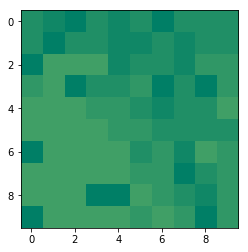

Step: 368
Updated position: [7 1]
Updated direction: [1 0]


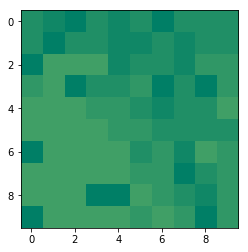

Step: 369
Updated position: [8 1]
Updated direction: [1 0]


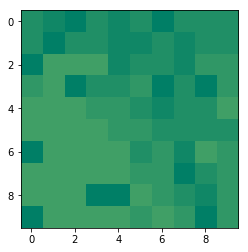

Step: 370
Updated position: [9 1]
Updated direction: [-1  0]


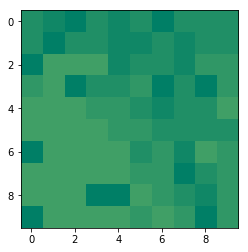

Step: 371
Updated position: [8 1]
Updated direction: [0 1]


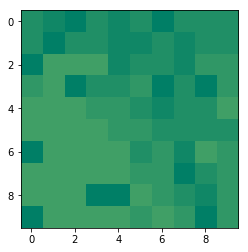

Step: 372
Updated position: [8 2]
Updated direction: [-1  0]


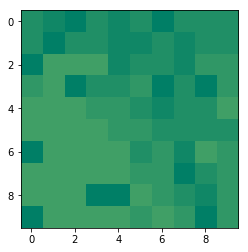

Step: 373
Updated position: [7 2]
Updated direction: [1 0]


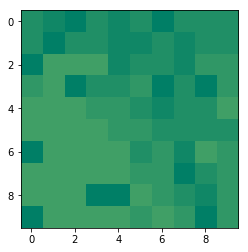

Step: 374
Updated position: [8 2]
Updated direction: [1 0]


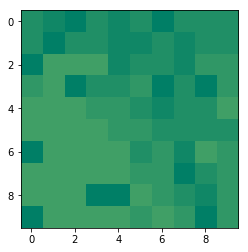

Step: 375
Updated position: [9 2]
Updated direction: [ 0 -1]


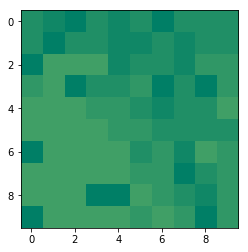

Step: 376
Updated position: [9 1]
Updated direction: [-1  0]


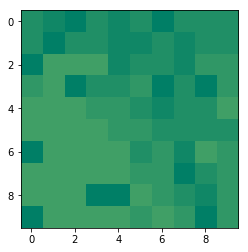

Step: 377
Updated position: [8 1]
Updated direction: [-1  0]


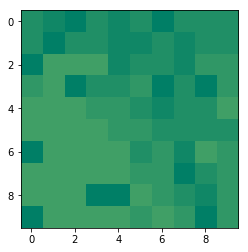

Step: 378
Updated position: [7 1]
Updated direction: [-1  0]


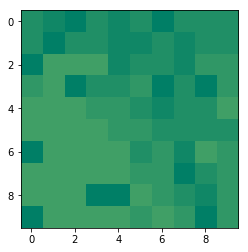

Step: 379
Updated position: [6 1]
Updated direction: [0 1]


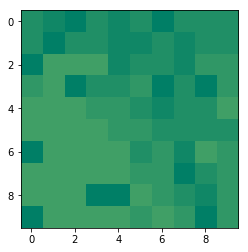

Step: 380
Updated position: [6 2]
Updated direction: [1 0]


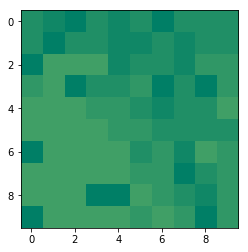

Step: 381
Updated position: [7 2]
Updated direction: [0 1]


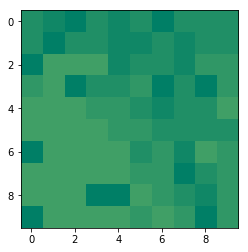

Step: 382
Updated position: [7 3]
Updated direction: [ 0 -1]


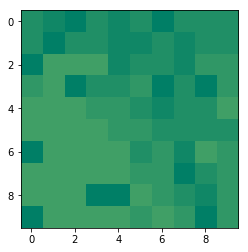

Step: 383
Updated position: [7 2]
Updated direction: [1 0]


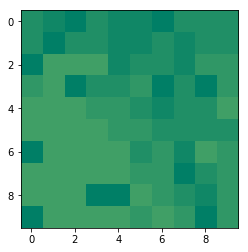

Step: 384
Updated position: [8 2]
Updated direction: [1 0]


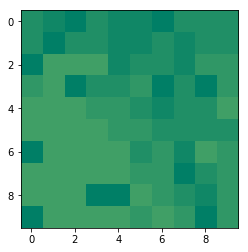

Step: 385
Updated position: [9 2]
Updated direction: [ 0 -1]


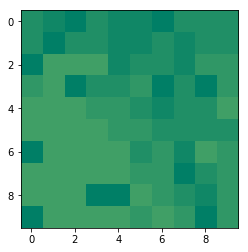

Step: 386
Updated position: [9 1]
Updated direction: [-1  0]


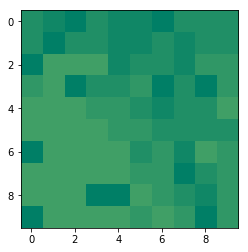

Step: 387
Updated position: [8 1]
Updated direction: [ 0 -1]


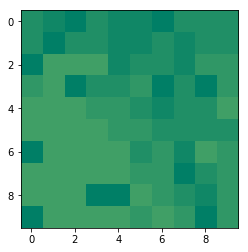

Step: 388
Updated position: [8 0]
Updated direction: [-1  0]


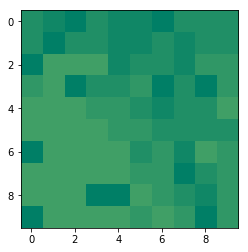

Step: 389
Updated position: [7 0]
Updated direction: [1 0]


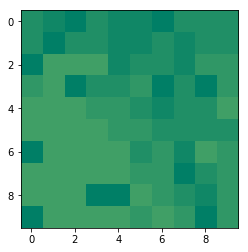

Step: 390
Updated position: [8 0]
Updated direction: [0 1]


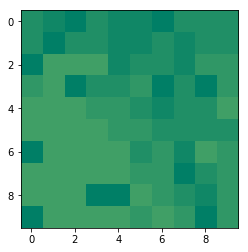

Step: 391
Updated position: [8 1]
Updated direction: [1 0]


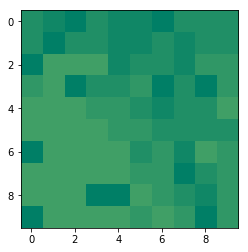

Step: 392
Updated position: [9 1]
Updated direction: [0 1]


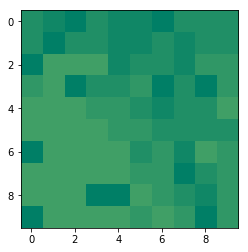

Step: 393
Updated position: [9 2]
Updated direction: [0 1]


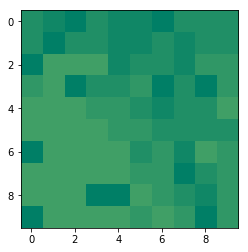

Step: 394
Updated position: [9 3]
Updated direction: [ 0 -1]


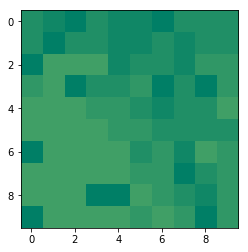

Step: 395
Updated position: [9 2]
Updated direction: [0 1]


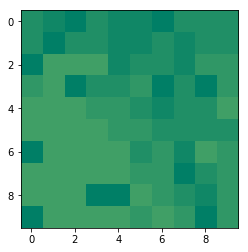

Step: 396
Updated position: [9 3]
Updated direction: [ 0 -1]


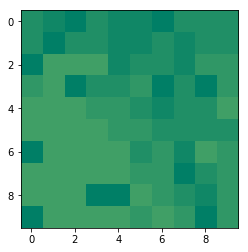

Step: 397
Updated position: [9 2]
Updated direction: [-1  0]


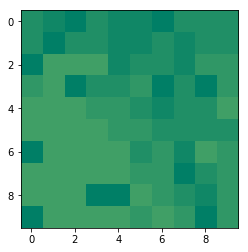

Step: 398
Updated position: [8 2]
Updated direction: [-1  0]


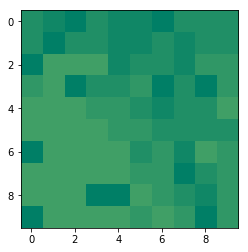

Step: 399
Updated position: [7 2]
Updated direction: [1 0]


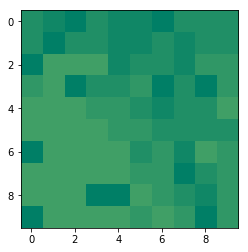

Step: 400
Updated position: [8 2]
Updated direction: [1 0]


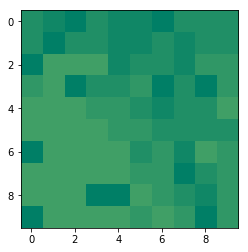

Step: 401
Updated position: [9 2]
Updated direction: [-1  0]


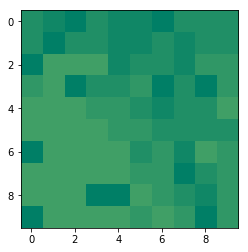

Step: 402
Updated position: [8 2]
Updated direction: [1 0]


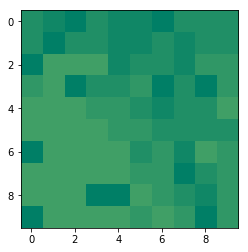

Step: 403
Updated position: [9 2]
Updated direction: [ 0 -1]


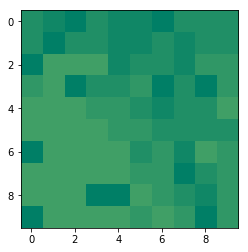

Step: 404
Updated position: [9 1]
Updated direction: [-1  0]


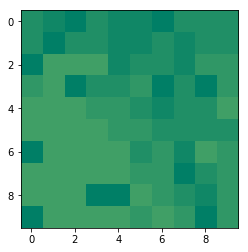

Step: 405
Updated position: [8 1]
Updated direction: [1 0]


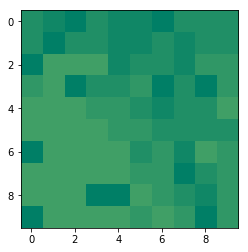

Step: 406
Updated position: [9 1]
Updated direction: [0 1]


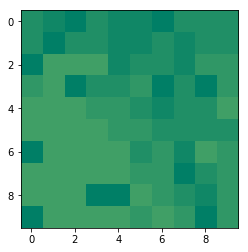

Step: 407
Updated position: [9 2]
Updated direction: [0 1]


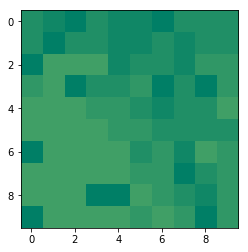

Step: 408
Updated position: [9 3]
Updated direction: [0 1]


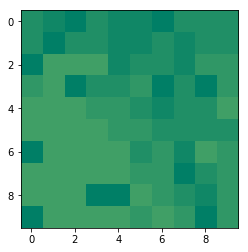

Step: 409
Updated position: [9 4]
Updated direction: [0 1]


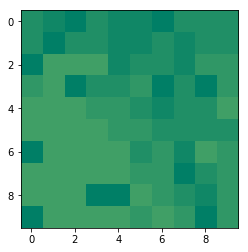

Step: 410
Updated position: [9 5]
Updated direction: [ 0 -1]


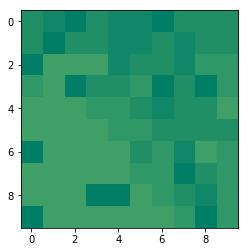

Step: 411
Updated position: [9 4]
Updated direction: [0 1]


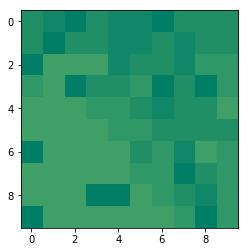

Step: 412
Updated position: [9 5]
Updated direction: [ 0 -1]


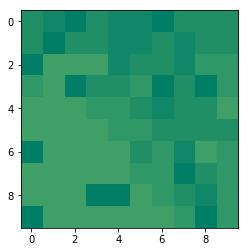

Step: 413
Updated position: [9 4]
Updated direction: [0 1]


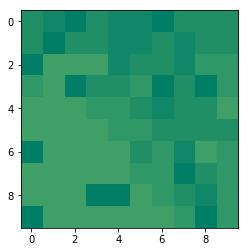

Step: 414
Updated position: [9 5]
Updated direction: [ 0 -1]


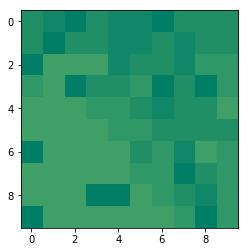

Step: 415
Updated position: [9 4]
Updated direction: [0 1]


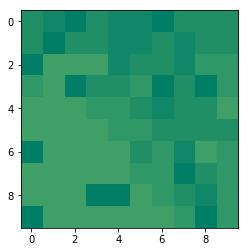

Step: 416
Updated position: [9 5]
Updated direction: [0 1]


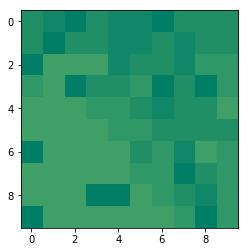

Step: 417
Updated position: [9 6]
Updated direction: [0 1]


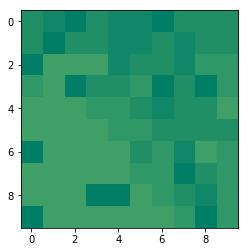

Step: 418
Updated position: [9 7]
Updated direction: [-1  0]


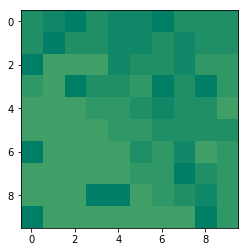

Step: 419
Updated position: [8 7]
Updated direction: [0 1]


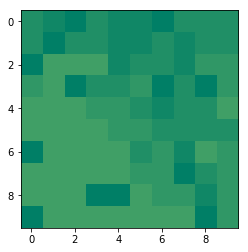

Step: 420
Updated position: [8 8]
Updated direction: [ 0 -1]


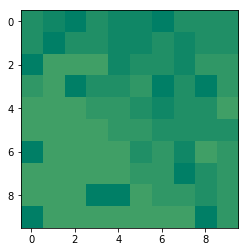

Step: 421
Updated position: [8 7]
Updated direction: [ 0 -1]


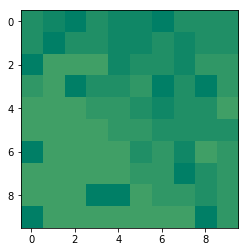

Step: 422
Updated position: [8 6]
Updated direction: [-1  0]


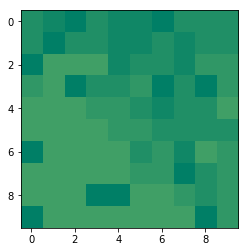

Step: 423
Updated position: [7 6]
Updated direction: [-1  0]


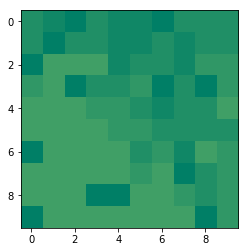

Step: 424
Updated position: [6 6]
Updated direction: [1 0]


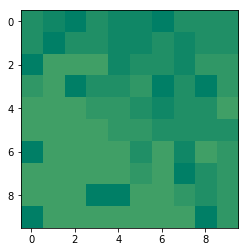

Step: 425
Updated position: [7 6]
Updated direction: [-1  0]


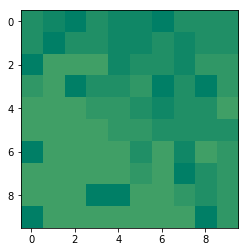

Step: 426
Updated position: [6 6]
Updated direction: [0 1]


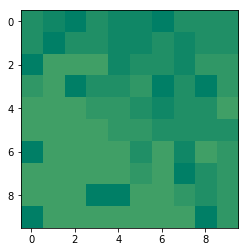

Step: 427
Updated position: [6 7]
Updated direction: [0 1]


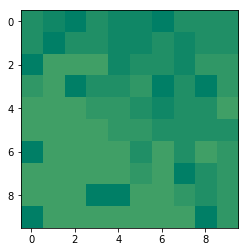

Step: 428
Updated position: [6 8]
Updated direction: [1 0]


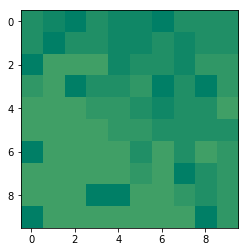

Step: 429
Updated position: [7 8]
Updated direction: [1 0]


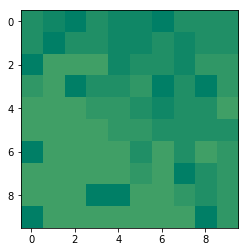

Step: 430
Updated position: [8 8]
Updated direction: [0 1]


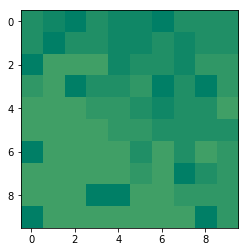

Step: 431
Updated position: [8 9]
Updated direction: [-1  0]


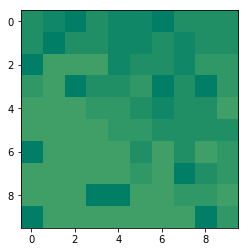

Step: 432
Updated position: [7 9]
Updated direction: [ 0 -1]


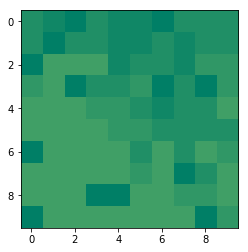

Step: 433
Updated position: [7 8]
Updated direction: [-1  0]


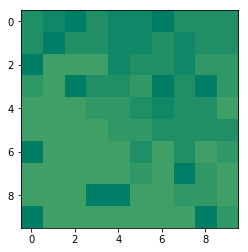

Step: 434
Updated position: [6 8]
Updated direction: [-1  0]


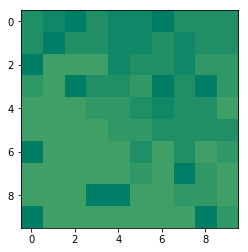

Step: 435
Updated position: [5 8]
Updated direction: [-1  0]


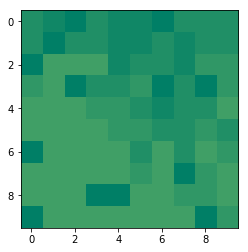

Step: 436
Updated position: [4 8]
Updated direction: [ 0 -1]


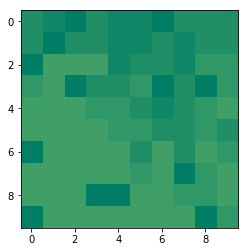

Step: 437
Updated position: [4 7]
Updated direction: [ 0 -1]


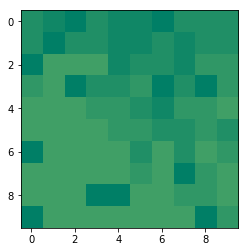

Step: 438
Updated position: [4 6]
Updated direction: [0 1]


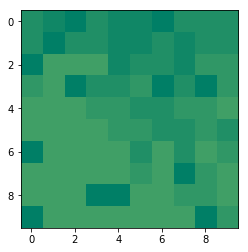

Step: 439
Updated position: [4 7]
Updated direction: [0 1]


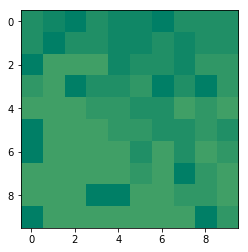

Step: 440
Updated position: [4 8]
Updated direction: [1 0]


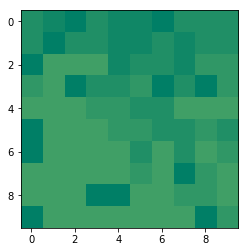

Step: 441
Updated position: [5 8]
Updated direction: [ 0 -1]


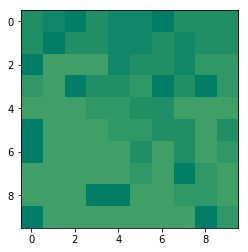

Step: 442
Updated position: [5 7]
Updated direction: [1 0]


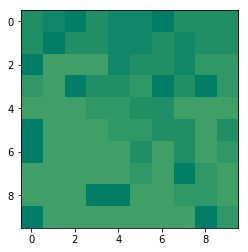

Step: 443
Updated position: [6 7]
Updated direction: [-1  0]


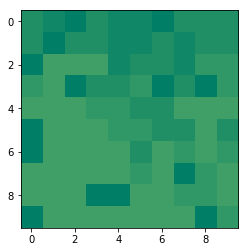

Step: 444
Updated position: [5 7]
Updated direction: [0 1]


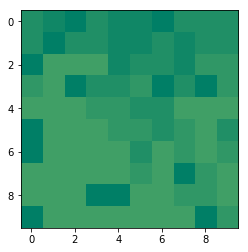

Step: 445
Updated position: [5 8]
Updated direction: [0 1]


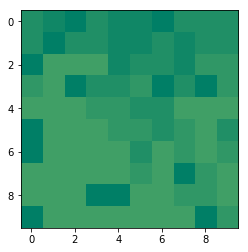

Step: 446
Updated position: [5 9]
Updated direction: [1 0]


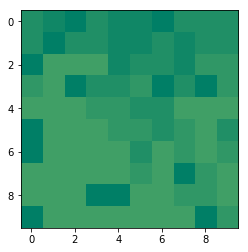

Step: 447
Updated position: [6 9]
Updated direction: [1 0]


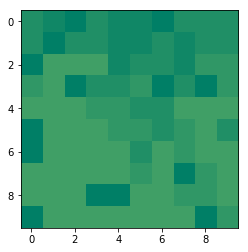

Step: 448
Updated position: [7 9]
Updated direction: [ 0 -1]


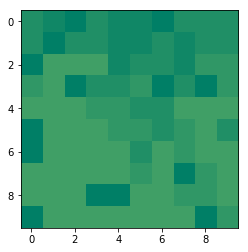

Step: 449
Updated position: [7 8]
Updated direction: [1 0]


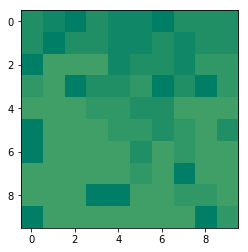

Step: 450
Updated position: [8 8]
Updated direction: [ 0 -1]


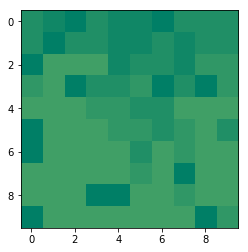

Step: 451
Updated position: [8 7]
Updated direction: [1 0]


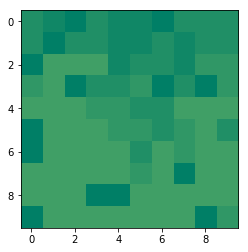

Step: 452
Updated position: [9 7]
Updated direction: [ 0 -1]


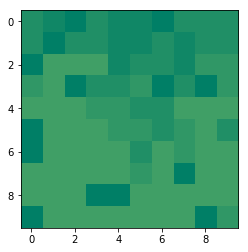

Step: 453
Updated position: [9 6]
Updated direction: [ 0 -1]


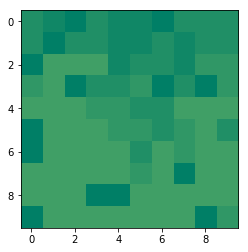

Step: 454
Updated position: [9 5]
Updated direction: [ 0 -1]


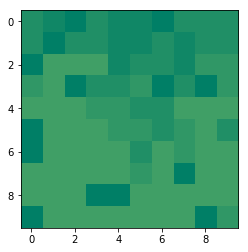

Step: 455
Updated position: [9 4]
Updated direction: [ 0 -1]


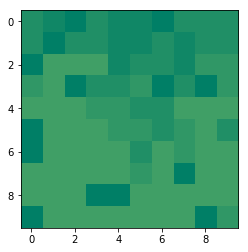

Step: 456
Updated position: [9 3]
Updated direction: [0 1]


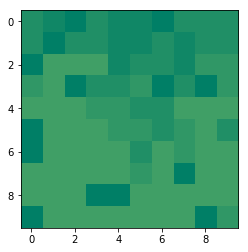

Step: 457
Updated position: [9 4]
Updated direction: [ 0 -1]


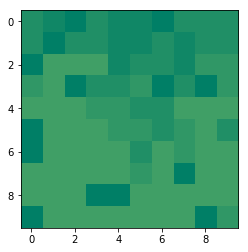

Step: 458
Updated position: [9 3]
Updated direction: [ 0 -1]


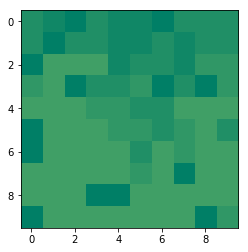

Step: 459
Updated position: [9 2]
Updated direction: [ 0 -1]


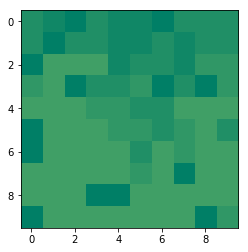

Step: 460
Updated position: [9 1]
Updated direction: [0 1]


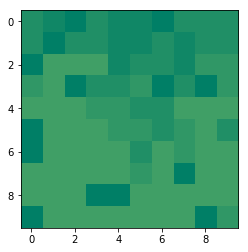

Step: 461
Updated position: [9 2]
Updated direction: [ 0 -1]


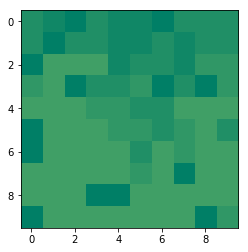

Step: 462
Updated position: [9 1]
Updated direction: [0 1]


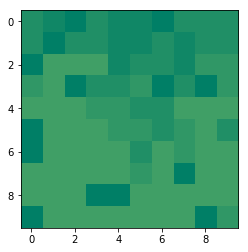

Step: 463
Updated position: [9 2]
Updated direction: [0 1]


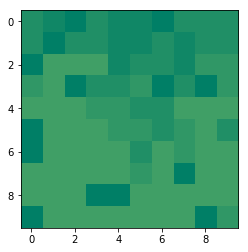

Step: 464
Updated position: [9 3]
Updated direction: [ 0 -1]


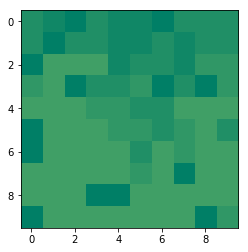

Step: 465
Updated position: [9 2]
Updated direction: [ 0 -1]


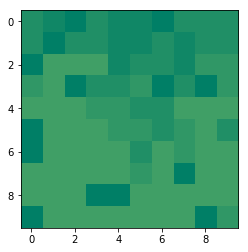

Step: 466
Updated position: [9 1]
Updated direction: [-1  0]


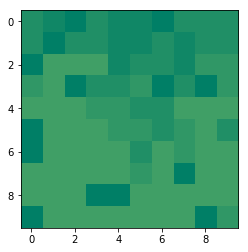

Step: 467
Updated position: [8 1]
Updated direction: [1 0]


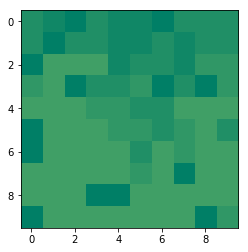

Step: 468
Updated position: [9 1]
Updated direction: [0 1]


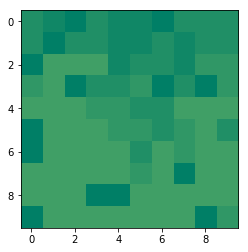

Step: 469
Updated position: [9 2]
Updated direction: [ 0 -1]


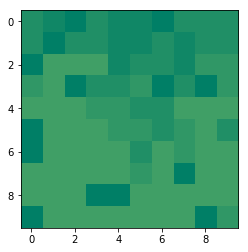

Step: 470
Updated position: [9 1]
Updated direction: [0 1]


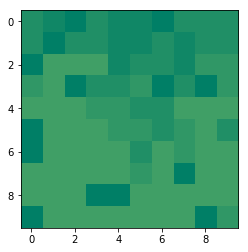

Step: 471
Updated position: [9 2]
Updated direction: [ 0 -1]


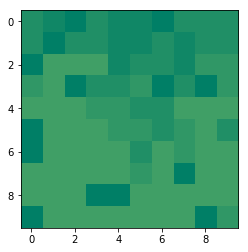

Step: 472
Updated position: [9 1]
Updated direction: [0 1]


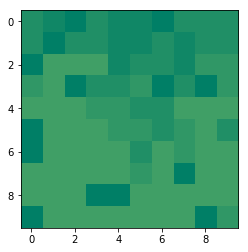

Step: 473
Updated position: [9 2]
Updated direction: [0 1]


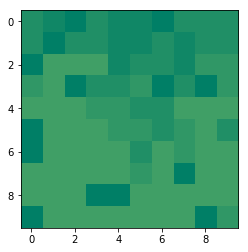

Step: 474
Updated position: [9 3]
Updated direction: [ 0 -1]


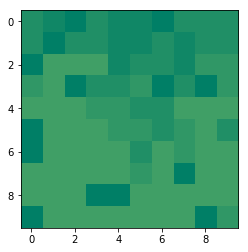

Step: 475
Updated position: [9 2]
Updated direction: [ 0 -1]


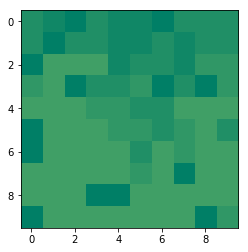

Step: 476
Updated position: [9 1]
Updated direction: [-1  0]


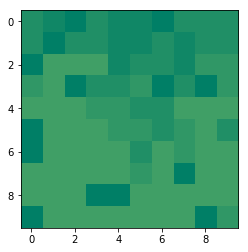

Step: 477
Updated position: [8 1]
Updated direction: [-1  0]


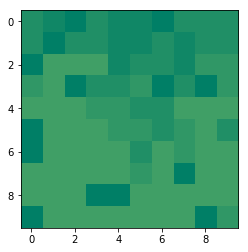

Step: 478
Updated position: [7 1]
Updated direction: [1 0]


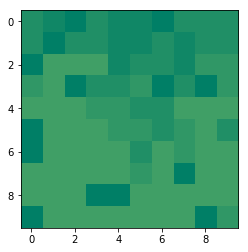

Step: 479
Updated position: [8 1]
Updated direction: [1 0]


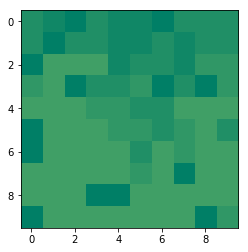

Step: 480
Updated position: [9 1]
Updated direction: [-1  0]


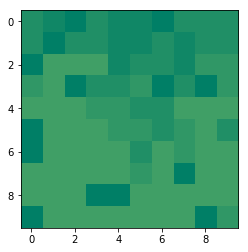

Step: 481
Updated position: [8 1]
Updated direction: [ 0 -1]


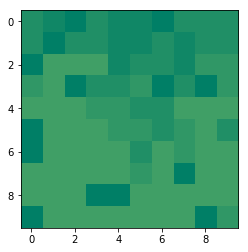

Step: 482
Updated position: [8 0]
Updated direction: [-1  0]


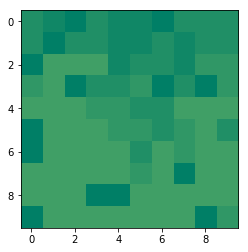

Step: 483
Updated position: [7 0]
Updated direction: [1 0]


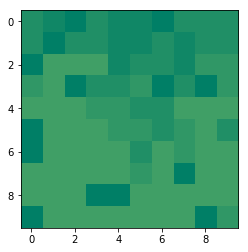

Step: 484
Updated position: [8 0]
Updated direction: [-1  0]


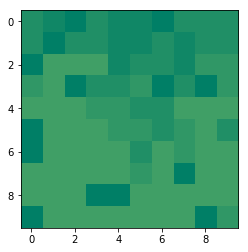

Step: 485
Updated position: [7 0]
Updated direction: [0 1]


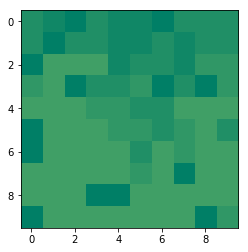

Step: 486
Updated position: [7 1]
Updated direction: [ 0 -1]


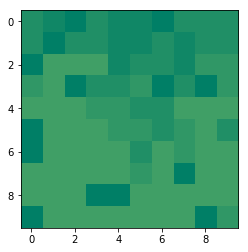

Step: 487
Updated position: [7 0]
Updated direction: [0 1]


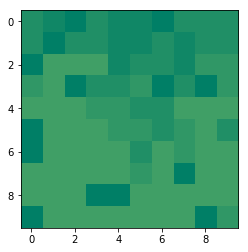

Step: 488
Updated position: [7 1]
Updated direction: [-1  0]


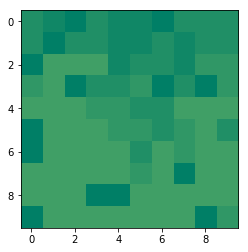

Step: 489
Updated position: [6 1]
Updated direction: [1 0]


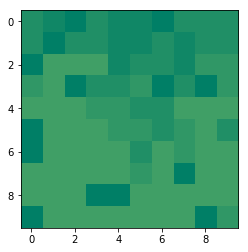

Step: 490
Updated position: [7 1]
Updated direction: [1 0]


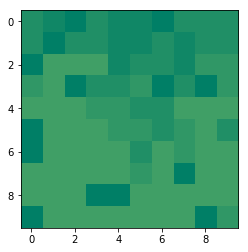

Step: 491
Updated position: [8 1]
Updated direction: [1 0]


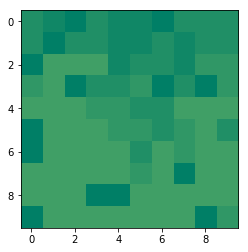

Step: 492
Updated position: [9 1]
Updated direction: [0 1]


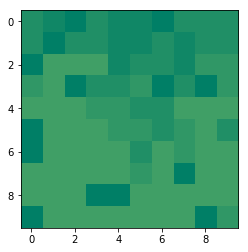

Step: 493
Updated position: [9 2]
Updated direction: [ 0 -1]


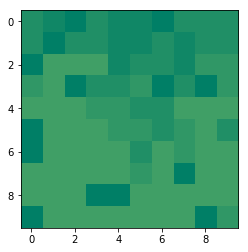

Step: 494
Updated position: [9 1]
Updated direction: [0 1]


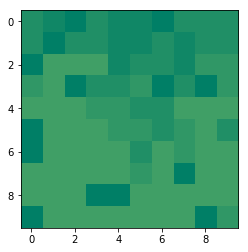

Step: 495
Updated position: [9 2]
Updated direction: [0 1]


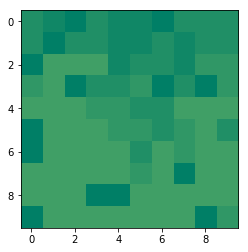

Step: 496
Updated position: [9 3]
Updated direction: [0 1]


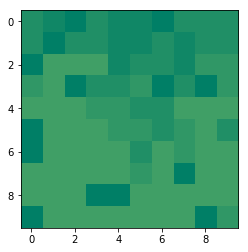

Step: 497
Updated position: [9 4]
Updated direction: [ 0 -1]


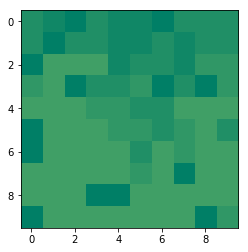

Step: 498
Updated position: [9 3]
Updated direction: [ 0 -1]


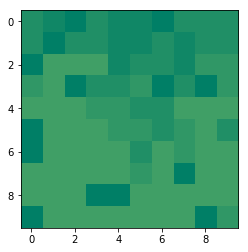

Step: 499
Updated position: [9 2]
Updated direction: [ 0 -1]


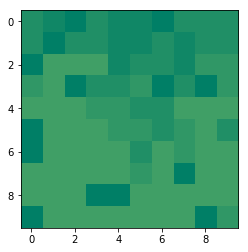

Step: 500
Updated position: [9 1]
Updated direction: [0 1]


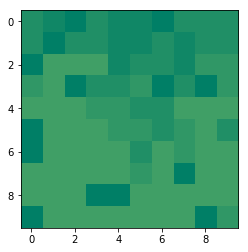

Step: 501
Updated position: [9 2]
Updated direction: [ 0 -1]


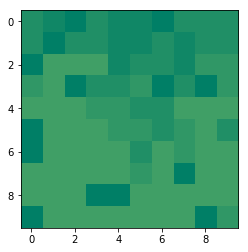

Step: 502
Updated position: [9 1]
Updated direction: [0 1]


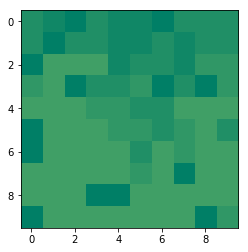

Step: 503
Updated position: [9 2]
Updated direction: [ 0 -1]


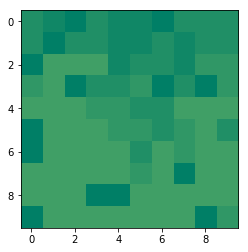

Step: 504
Updated position: [9 1]
Updated direction: [-1  0]


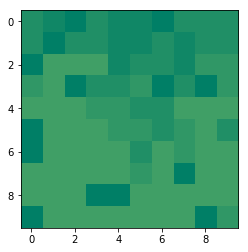

Step: 505
Updated position: [8 1]
Updated direction: [1 0]


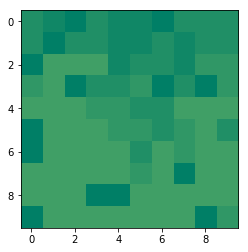

Step: 506
Updated position: [9 1]
Updated direction: [-1  0]


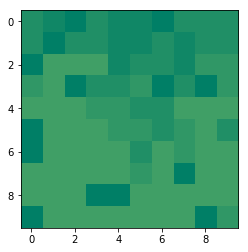

Step: 507
Updated position: [8 1]
Updated direction: [0 1]


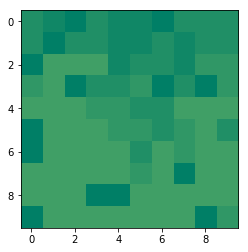

Step: 508
Updated position: [8 2]
Updated direction: [1 0]


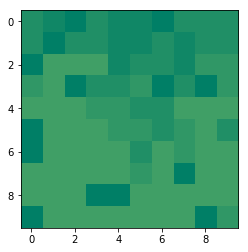

Step: 509
Updated position: [9 2]
Updated direction: [ 0 -1]


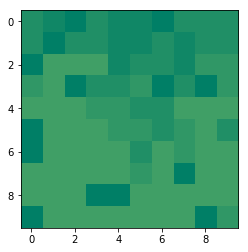

Step: 510
Updated position: [9 1]
Updated direction: [0 1]


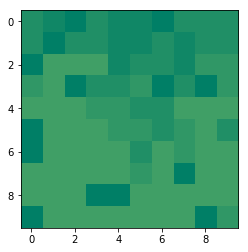

Step: 511
Updated position: [9 2]
Updated direction: [ 0 -1]


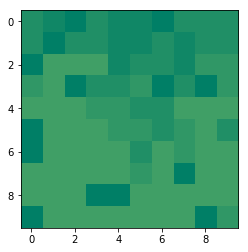

Step: 512
Updated position: [9 1]
Updated direction: [0 1]


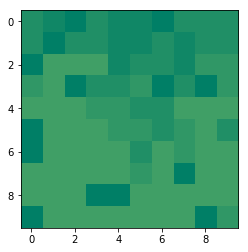

Step: 513
Updated position: [9 2]
Updated direction: [ 0 -1]


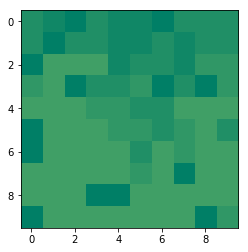

Step: 514
Updated position: [9 1]
Updated direction: [0 1]


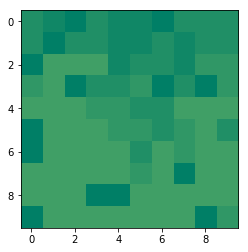

Step: 515
Updated position: [9 2]
Updated direction: [-1  0]


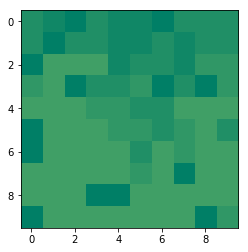

Step: 516
Updated position: [8 2]
Updated direction: [1 0]


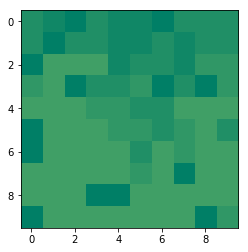

Step: 517
Updated position: [9 2]
Updated direction: [ 0 -1]


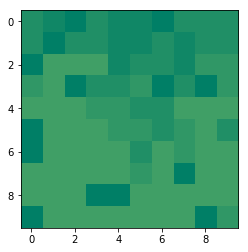

Step: 518
Updated position: [9 1]
Updated direction: [-1  0]


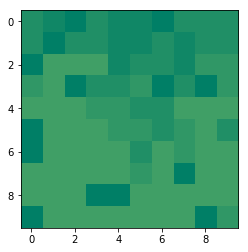

Step: 519
Updated position: [8 1]
Updated direction: [-1  0]


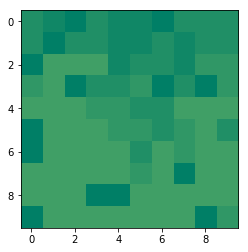

Step: 520
Updated position: [7 1]
Updated direction: [ 0 -1]


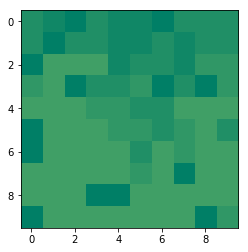

Step: 521
Updated position: [7 0]
Updated direction: [1 0]


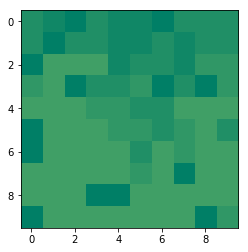

Step: 522
Updated position: [8 0]
Updated direction: [0 1]


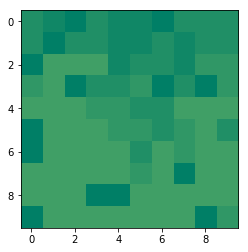

Step: 523
Updated position: [8 1]
Updated direction: [1 0]


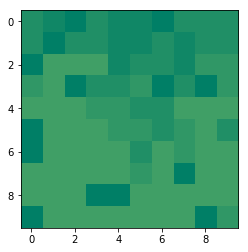

Step: 524
Updated position: [9 1]
Updated direction: [0 1]


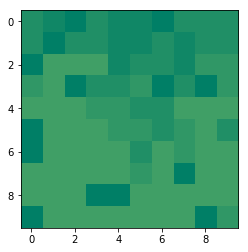

Step: 525
Updated position: [9 2]
Updated direction: [ 0 -1]


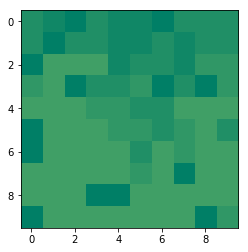

Step: 526
Updated position: [9 1]
Updated direction: [0 1]


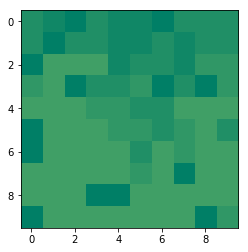

Step: 527
Updated position: [9 2]
Updated direction: [0 1]


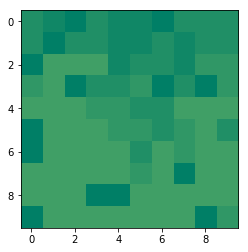

Step: 528
Updated position: [9 3]
Updated direction: [0 1]


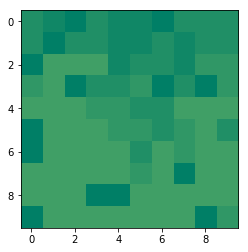

Step: 529
Updated position: [9 4]
Updated direction: [ 0 -1]


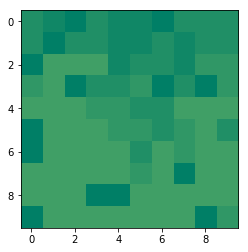

Step: 530
Updated position: [9 3]
Updated direction: [ 0 -1]


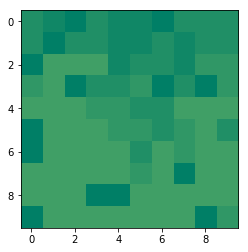

Step: 531
Updated position: [9 2]
Updated direction: [ 0 -1]


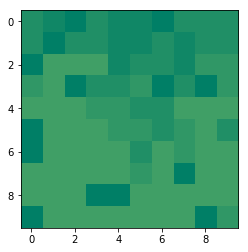

Step: 532
Updated position: [9 1]
Updated direction: [0 1]


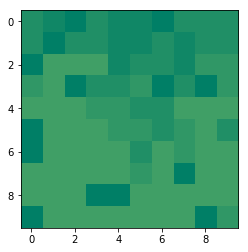

Step: 533
Updated position: [9 2]
Updated direction: [ 0 -1]


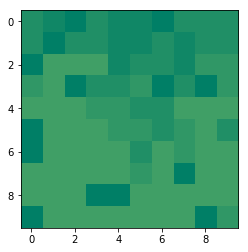

Step: 534
Updated position: [9 1]
Updated direction: [-1  0]


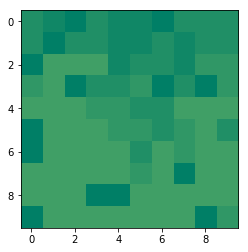

Step: 535
Updated position: [8 1]
Updated direction: [1 0]


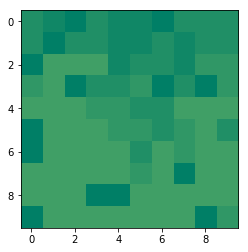

Step: 536
Updated position: [9 1]
Updated direction: [0 1]


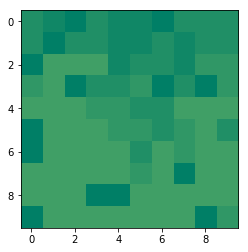

Step: 537
Updated position: [9 2]
Updated direction: [ 0 -1]


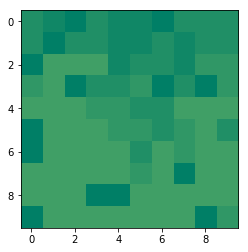

Step: 538
Updated position: [9 1]
Updated direction: [-1  0]


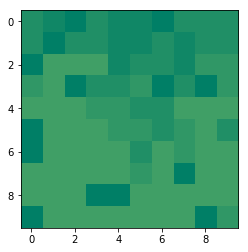

Step: 539
Updated position: [8 1]
Updated direction: [0 1]


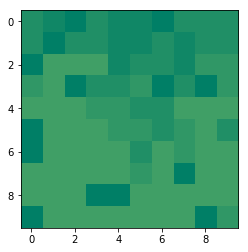

Step: 540
Updated position: [8 2]
Updated direction: [1 0]


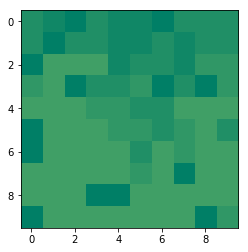

Step: 541
Updated position: [9 2]
Updated direction: [ 0 -1]


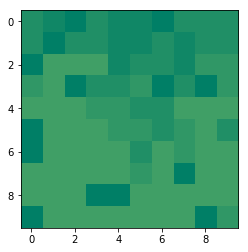

Step: 542
Updated position: [9 1]
Updated direction: [-1  0]


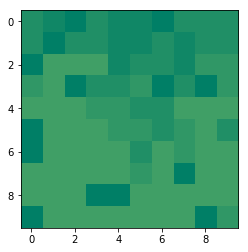

Step: 543
Updated position: [8 1]
Updated direction: [1 0]


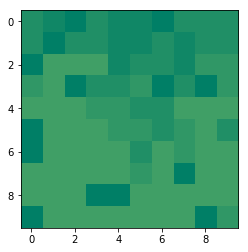

Step: 544
Updated position: [9 1]
Updated direction: [-1  0]


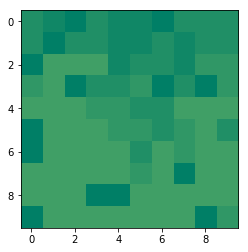

Step: 545
Updated position: [8 1]
Updated direction: [0 1]


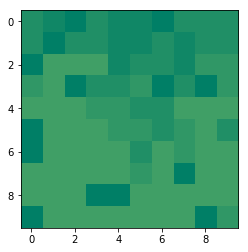

Step: 546
Updated position: [8 2]
Updated direction: [1 0]


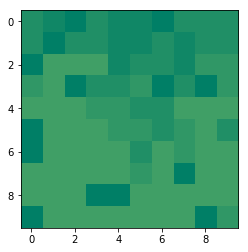

Step: 547
Updated position: [9 2]
Updated direction: [ 0 -1]


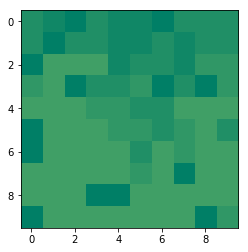

Step: 548
Updated position: [9 1]
Updated direction: [0 1]


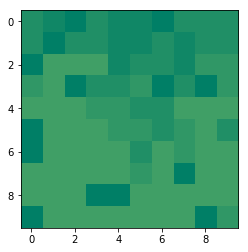

Step: 549
Updated position: [9 2]
Updated direction: [ 0 -1]


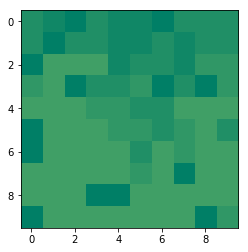

Step: 550
Updated position: [9 1]
Updated direction: [0 1]


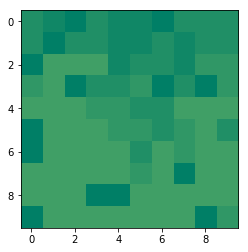

Step: 551
Updated position: [9 2]
Updated direction: [0 1]


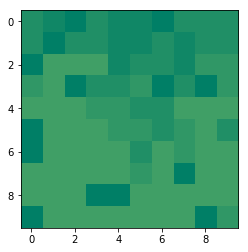

Step: 552
Updated position: [9 3]
Updated direction: [ 0 -1]


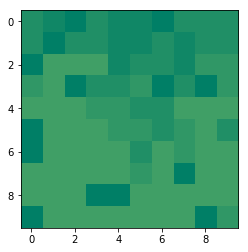

Step: 553
Updated position: [9 2]
Updated direction: [ 0 -1]


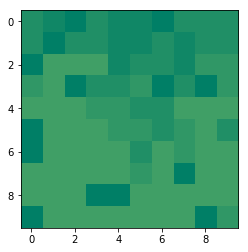

Step: 554
Updated position: [9 1]
Updated direction: [-1  0]


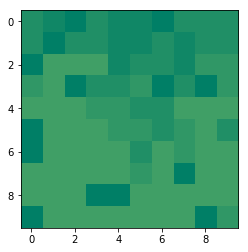

Step: 555
Updated position: [8 1]
Updated direction: [1 0]


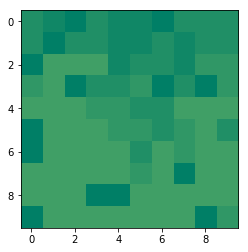

Step: 556
Updated position: [9 1]
Updated direction: [0 1]


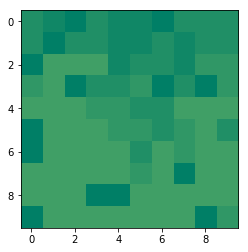

Step: 557
Updated position: [9 2]
Updated direction: [ 0 -1]


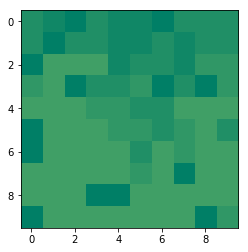

Step: 558
Updated position: [9 1]
Updated direction: [0 1]


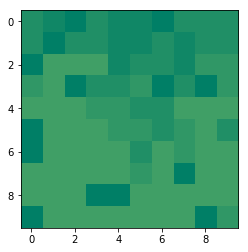

Step: 559
Updated position: [9 2]
Updated direction: [0 1]


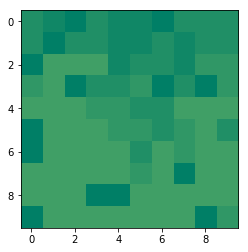

Step: 560
Updated position: [9 3]
Updated direction: [ 0 -1]


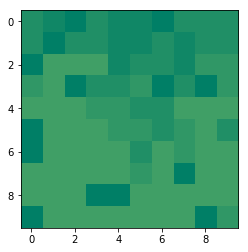

Step: 561
Updated position: [9 2]
Updated direction: [0 1]


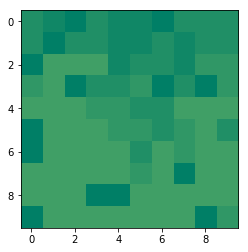

Step: 562
Updated position: [9 3]
Updated direction: [ 0 -1]


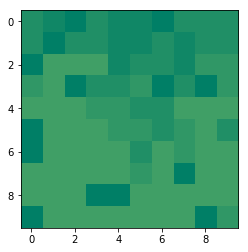

Step: 563
Updated position: [9 2]
Updated direction: [ 0 -1]


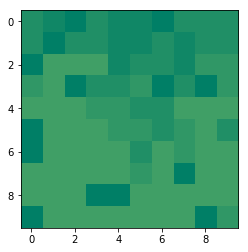

Step: 564
Updated position: [9 1]
Updated direction: [0 1]


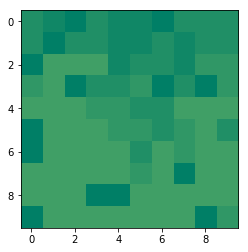

Step: 565
Updated position: [9 2]
Updated direction: [ 0 -1]


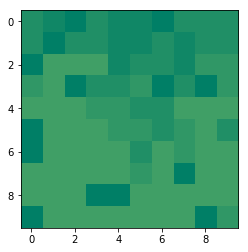

Step: 566
Updated position: [9 1]
Updated direction: [0 1]


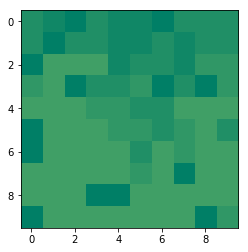

Step: 567
Updated position: [9 2]
Updated direction: [0 1]


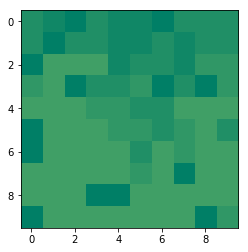

Step: 568
Updated position: [9 3]
Updated direction: [ 0 -1]


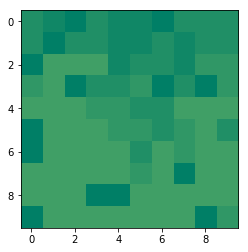

Step: 569
Updated position: [9 2]
Updated direction: [ 0 -1]


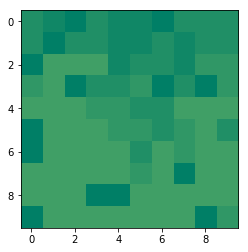

Step: 570
Updated position: [9 1]
Updated direction: [0 1]


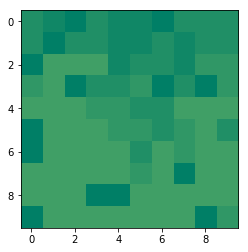

Step: 571
Updated position: [9 2]
Updated direction: [ 0 -1]


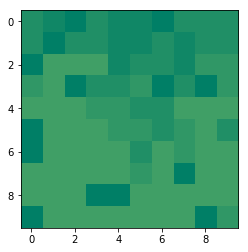

Step: 572
Updated position: [9 1]
Updated direction: [0 1]


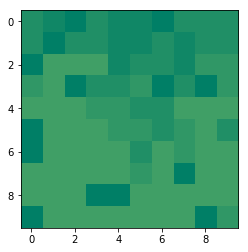

Step: 573
Updated position: [9 2]
Updated direction: [ 0 -1]


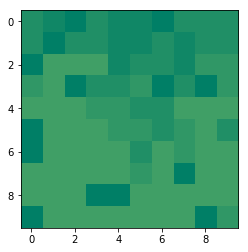

Step: 574
Updated position: [9 1]
Updated direction: [0 1]


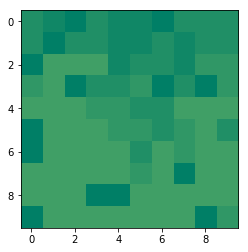

Step: 575
Updated position: [9 2]
Updated direction: [ 0 -1]


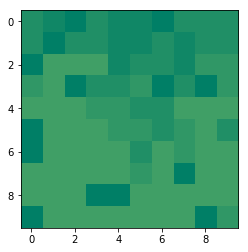

Step: 576
Updated position: [9 1]
Updated direction: [0 1]


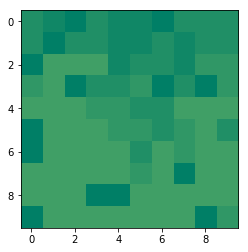

Step: 577
Updated position: [9 2]
Updated direction: [ 0 -1]


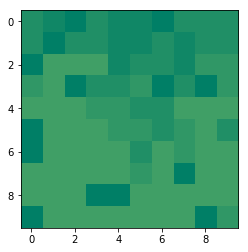

Step: 578
Updated position: [9 1]
Updated direction: [0 1]


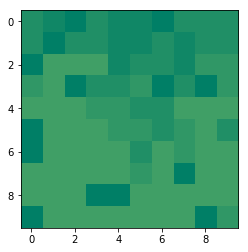

Step: 579
Updated position: [9 2]
Updated direction: [ 0 -1]


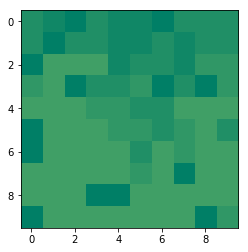

Step: 580
Updated position: [9 1]
Updated direction: [0 1]


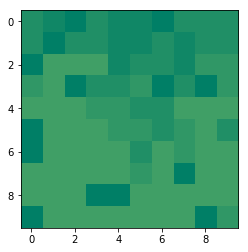

Step: 581
Updated position: [9 2]
Updated direction: [ 0 -1]


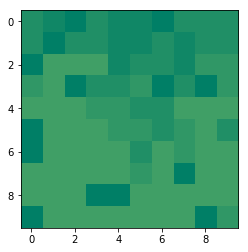

Step: 582
Updated position: [9 1]
Updated direction: [0 1]


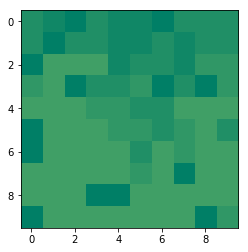

Step: 583
Updated position: [9 2]
Updated direction: [ 0 -1]


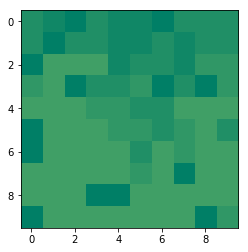

Step: 584
Updated position: [9 1]
Updated direction: [-1  0]


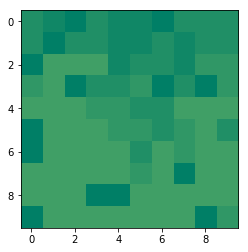

Step: 585
Updated position: [8 1]
Updated direction: [1 0]


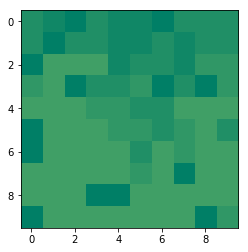

Step: 586
Updated position: [9 1]
Updated direction: [-1  0]


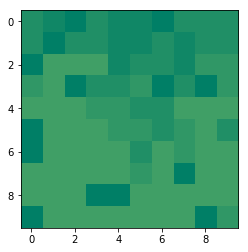

Step: 587
Updated position: [8 1]
Updated direction: [ 0 -1]


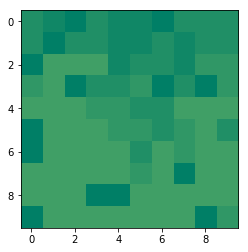

Step: 588
Updated position: [8 0]
Updated direction: [-1  0]


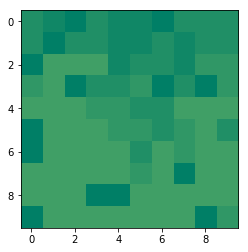

Step: 589
Updated position: [7 0]
Updated direction: [1 0]


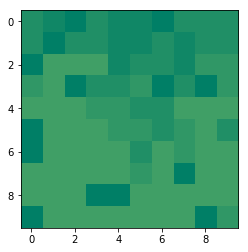

Step: 590
Updated position: [8 0]
Updated direction: [-1  0]


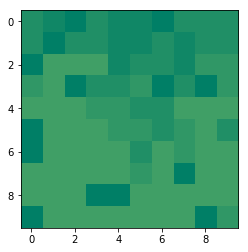

Step: 591
Updated position: [7 0]
Updated direction: [1 0]


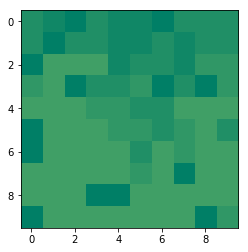

Step: 592
Updated position: [8 0]
Updated direction: [0 1]


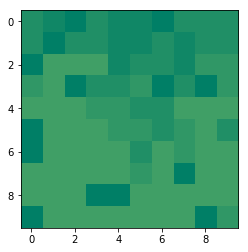

Step: 593
Updated position: [8 1]
Updated direction: [1 0]


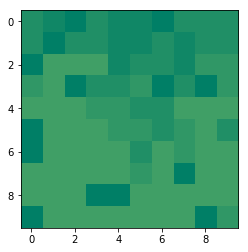

Step: 594
Updated position: [9 1]
Updated direction: [0 1]


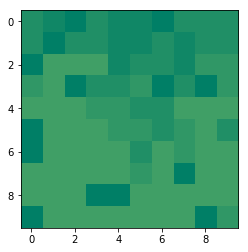

Step: 595
Updated position: [9 2]
Updated direction: [ 0 -1]


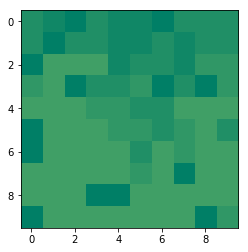

Step: 596
Updated position: [9 1]
Updated direction: [0 1]


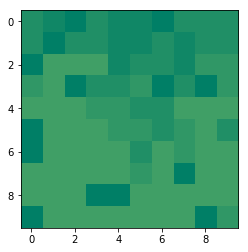

Step: 597
Updated position: [9 2]
Updated direction: [ 0 -1]


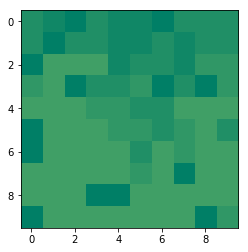

Step: 598
Updated position: [9 1]
Updated direction: [-1  0]


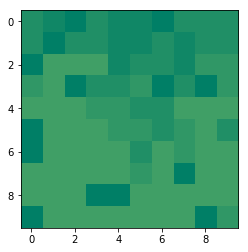

Step: 599
Updated position: [8 1]
Updated direction: [-1  0]


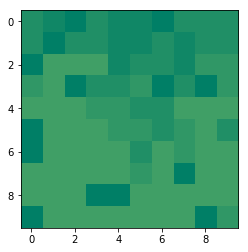

Step: 600
Updated position: [7 1]
Updated direction: [1 0]


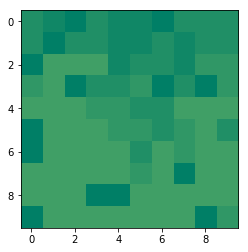

Step: 601
Updated position: [8 1]
Updated direction: [1 0]


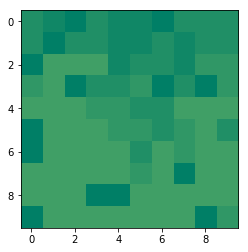

Step: 602
Updated position: [9 1]
Updated direction: [-1  0]


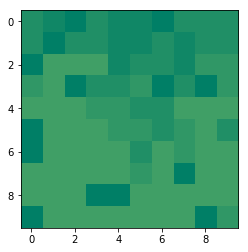

Step: 603
Updated position: [8 1]
Updated direction: [1 0]


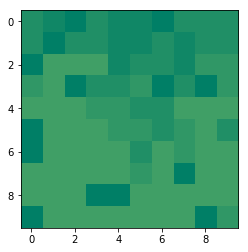

Step: 604
Updated position: [9 1]
Updated direction: [0 1]


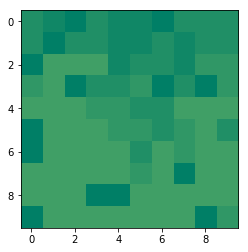

Step: 605
Updated position: [9 2]
Updated direction: [ 0 -1]


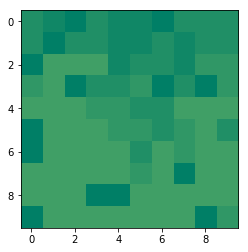

Step: 606
Updated position: [9 1]
Updated direction: [0 1]


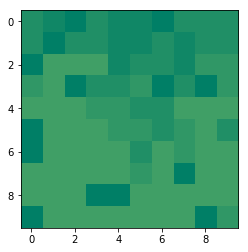

Step: 607
Updated position: [9 2]
Updated direction: [ 0 -1]


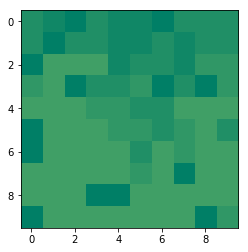

Step: 608
Updated position: [9 1]
Updated direction: [-1  0]


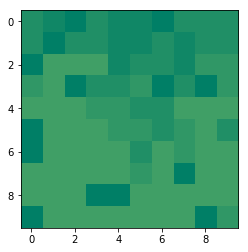

Step: 609
Updated position: [8 1]
Updated direction: [-1  0]


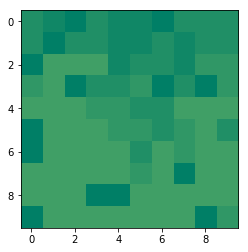

Step: 610
Updated position: [7 1]
Updated direction: [1 0]


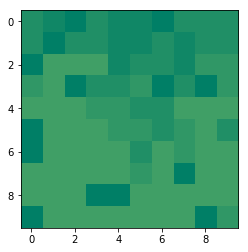

Step: 611
Updated position: [8 1]
Updated direction: [1 0]


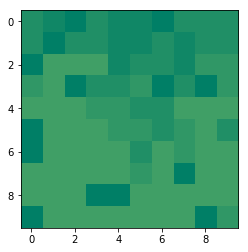

Step: 612
Updated position: [9 1]
Updated direction: [-1  0]


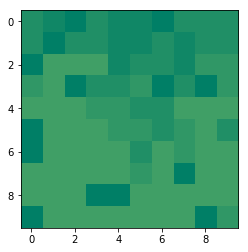

Step: 613
Updated position: [8 1]
Updated direction: [1 0]


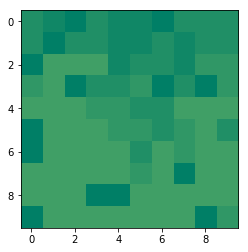

Step: 614
Updated position: [9 1]
Updated direction: [0 1]


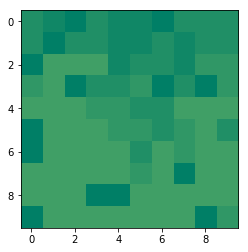

Step: 615
Updated position: [9 2]
Updated direction: [ 0 -1]


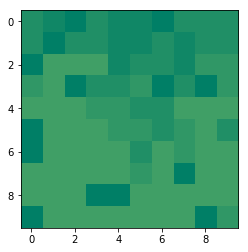

Step: 616
Updated position: [9 1]
Updated direction: [0 1]


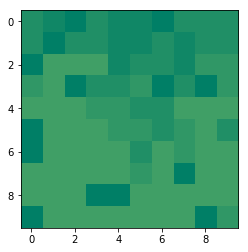

Step: 617
Updated position: [9 2]
Updated direction: [ 0 -1]


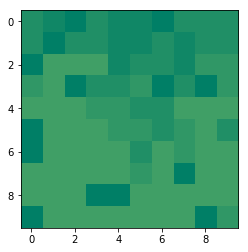

Step: 618
Updated position: [9 1]
Updated direction: [-1  0]


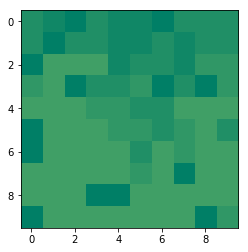

Step: 619
Updated position: [8 1]
Updated direction: [0 1]


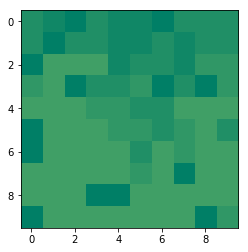

Step: 620
Updated position: [8 2]
Updated direction: [1 0]


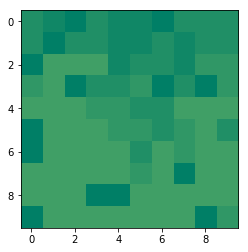

Step: 621
Updated position: [9 2]
Updated direction: [ 0 -1]


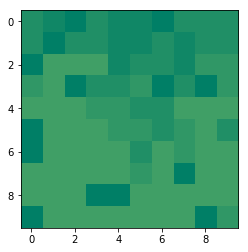

Step: 622
Updated position: [9 1]
Updated direction: [0 1]


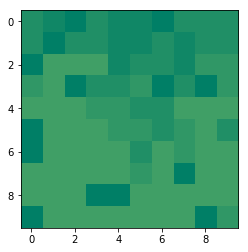

Step: 623
Updated position: [9 2]
Updated direction: [ 0 -1]


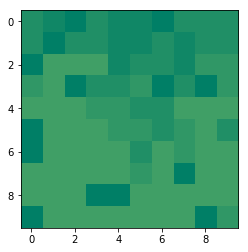

Step: 624
Updated position: [9 1]
Updated direction: [-1  0]


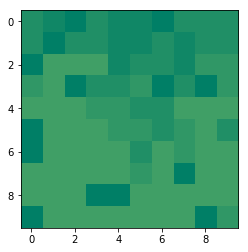

Step: 625
Updated position: [8 1]
Updated direction: [0 1]


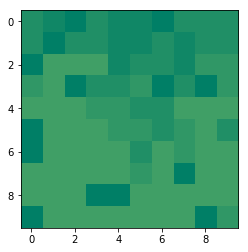

Step: 626
Updated position: [8 2]
Updated direction: [1 0]


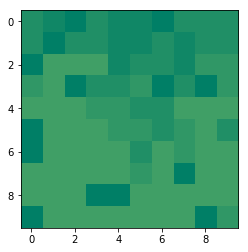

Step: 627
Updated position: [9 2]
Updated direction: [-1  0]


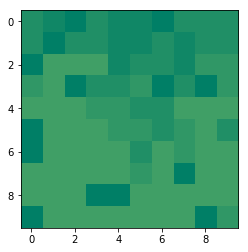

Step: 628
Updated position: [8 2]
Updated direction: [1 0]


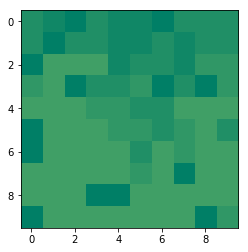

Step: 629
Updated position: [9 2]
Updated direction: [ 0 -1]


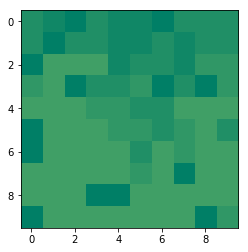

Step: 630
Updated position: [9 1]
Updated direction: [0 1]


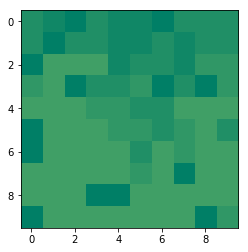

Step: 631
Updated position: [9 2]
Updated direction: [ 0 -1]


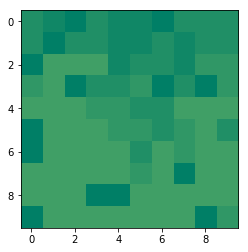

Step: 632
Updated position: [9 1]
Updated direction: [0 1]


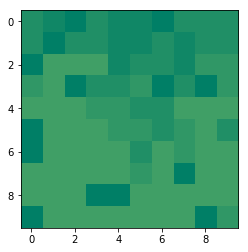

Step: 633
Updated position: [9 2]
Updated direction: [-1  0]


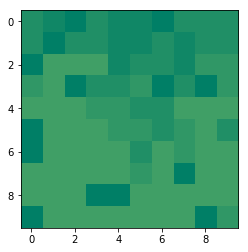

Step: 634
Updated position: [8 2]
Updated direction: [ 0 -1]


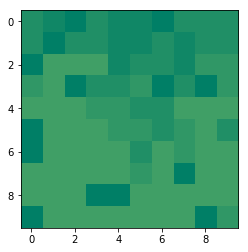

Step: 635
Updated position: [8 1]
Updated direction: [1 0]


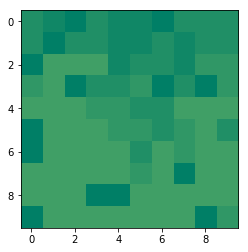

Step: 636
Updated position: [9 1]
Updated direction: [0 1]


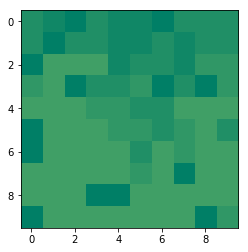

Step: 637
Updated position: [9 2]
Updated direction: [ 0 -1]


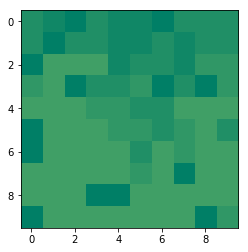

Step: 638
Updated position: [9 1]
Updated direction: [0 1]


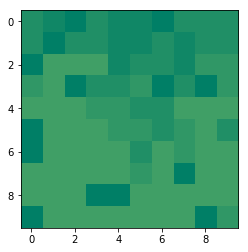

Step: 639
Updated position: [9 2]
Updated direction: [-1  0]


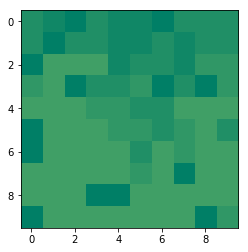

Step: 640
Updated position: [8 2]
Updated direction: [1 0]


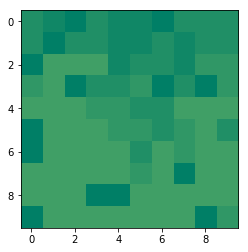

Step: 641
Updated position: [9 2]
Updated direction: [ 0 -1]


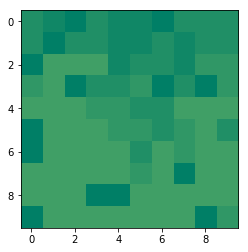

Step: 642
Updated position: [9 1]
Updated direction: [0 1]


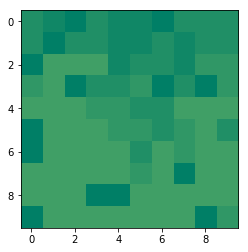

Step: 643
Updated position: [9 2]
Updated direction: [ 0 -1]


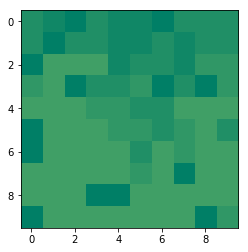

Step: 644
Updated position: [9 1]
Updated direction: [0 1]


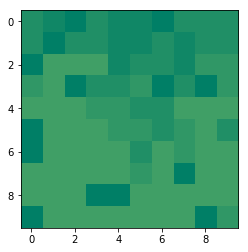

Step: 645
Updated position: [9 2]
Updated direction: [ 0 -1]


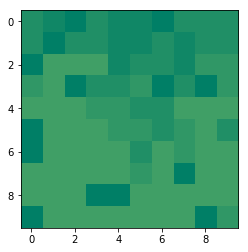

Step: 646
Updated position: [9 1]
Updated direction: [0 1]


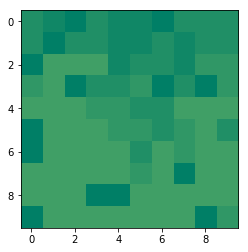

Step: 647
Updated position: [9 2]
Updated direction: [ 0 -1]


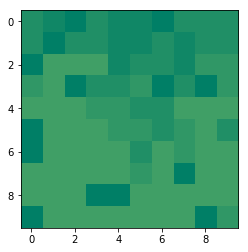

Step: 648
Updated position: [9 1]
Updated direction: [0 1]


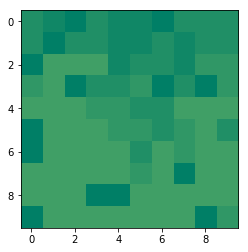

Step: 649
Updated position: [9 2]
Updated direction: [ 0 -1]


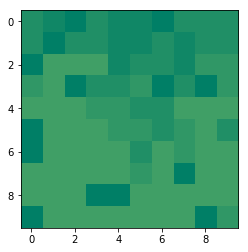

Step: 650
Updated position: [9 1]
Updated direction: [0 1]


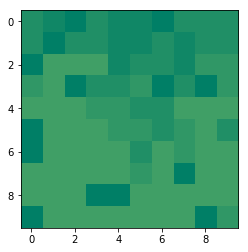

Step: 651
Updated position: [9 2]
Updated direction: [0 1]


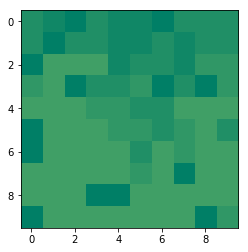

Step: 652
Updated position: [9 3]
Updated direction: [ 0 -1]


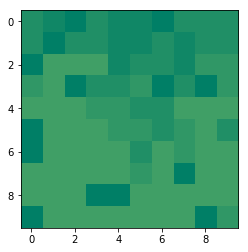

Step: 653
Updated position: [9 2]
Updated direction: [ 0 -1]


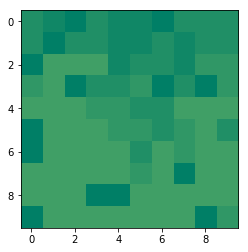

Step: 654
Updated position: [9 1]
Updated direction: [-1  0]


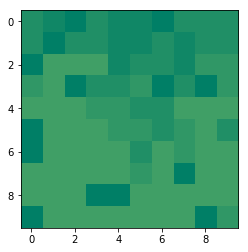

Step: 655
Updated position: [8 1]
Updated direction: [1 0]


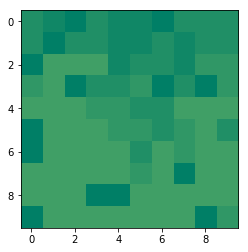

Step: 656
Updated position: [9 1]
Updated direction: [0 1]


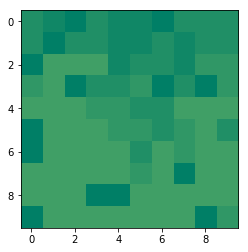

Step: 657
Updated position: [9 2]
Updated direction: [ 0 -1]


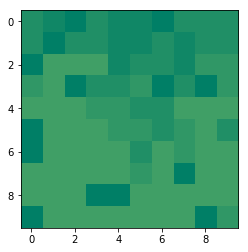

Step: 658
Updated position: [9 1]
Updated direction: [0 1]


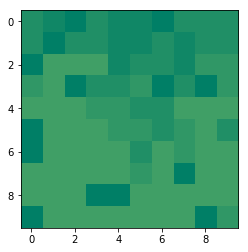

Step: 659
Updated position: [9 2]
Updated direction: [ 0 -1]


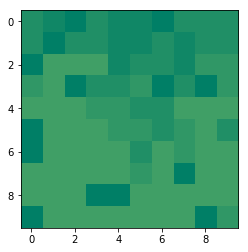

Step: 660
Updated position: [9 1]
Updated direction: [0 1]


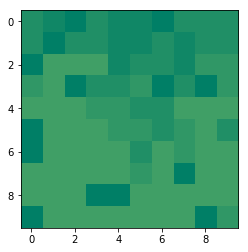

Step: 661
Updated position: [9 2]
Updated direction: [ 0 -1]


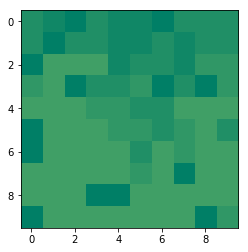

Step: 662
Updated position: [9 1]
Updated direction: [-1  0]


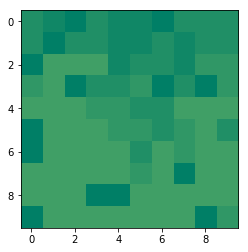

Step: 663
Updated position: [8 1]
Updated direction: [ 0 -1]


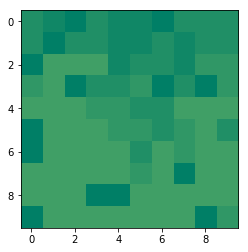

Step: 664
Updated position: [8 0]
Updated direction: [-1  0]


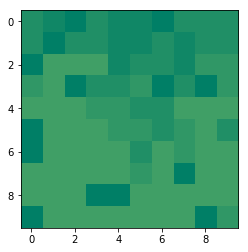

Step: 665
Updated position: [7 0]
Updated direction: [1 0]


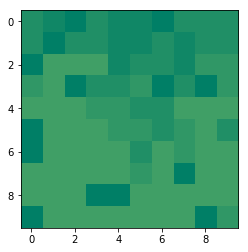

Step: 666
Updated position: [8 0]
Updated direction: [0 1]


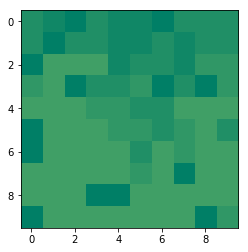

Step: 667
Updated position: [8 1]
Updated direction: [ 0 -1]


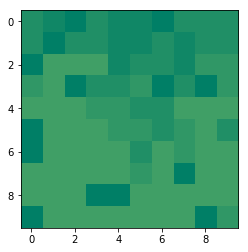

Step: 668
Updated position: [8 0]
Updated direction: [0 1]


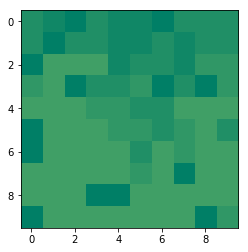

Step: 669
Updated position: [8 1]
Updated direction: [1 0]


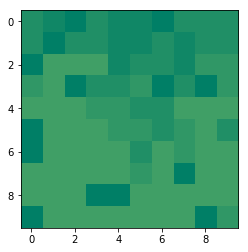

Step: 670
Updated position: [9 1]
Updated direction: [-1  0]


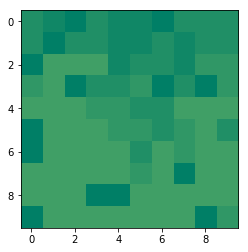

Step: 671
Updated position: [8 1]
Updated direction: [0 1]


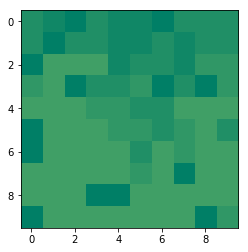

Step: 672
Updated position: [8 2]
Updated direction: [ 0 -1]


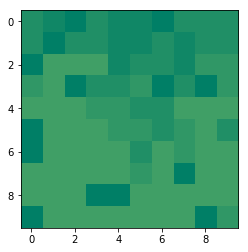

Step: 673
Updated position: [8 1]
Updated direction: [0 1]


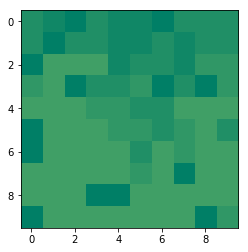

Step: 674
Updated position: [8 2]
Updated direction: [1 0]


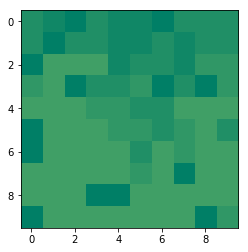

Step: 675
Updated position: [9 2]
Updated direction: [ 0 -1]


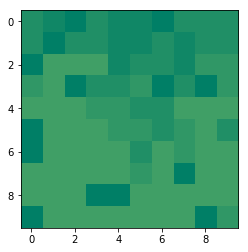

Step: 676
Updated position: [9 1]
Updated direction: [-1  0]


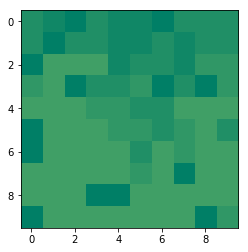

Step: 677
Updated position: [8 1]
Updated direction: [-1  0]


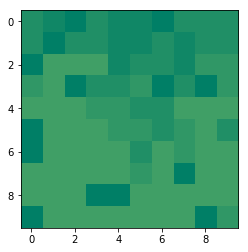

Step: 678
Updated position: [7 1]
Updated direction: [1 0]


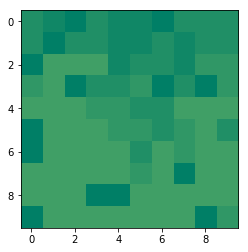

Step: 679
Updated position: [8 1]
Updated direction: [0 1]


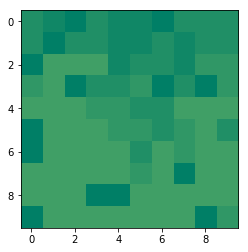

Step: 680
Updated position: [8 2]
Updated direction: [1 0]


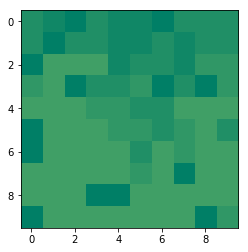

Step: 681
Updated position: [9 2]
Updated direction: [ 0 -1]


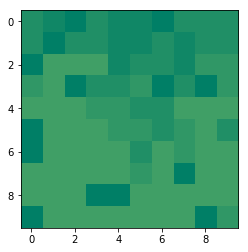

Step: 682
Updated position: [9 1]
Updated direction: [0 1]


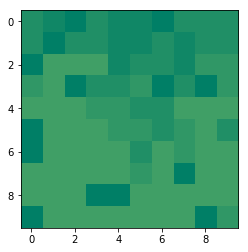

Step: 683
Updated position: [9 2]
Updated direction: [-1  0]


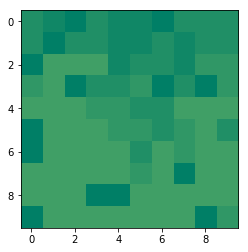

Step: 684
Updated position: [8 2]
Updated direction: [1 0]


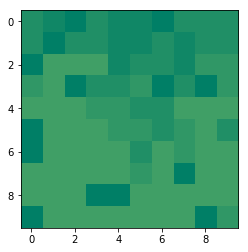

Step: 685
Updated position: [9 2]
Updated direction: [ 0 -1]


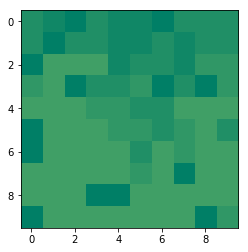

Step: 686
Updated position: [9 1]
Updated direction: [0 1]


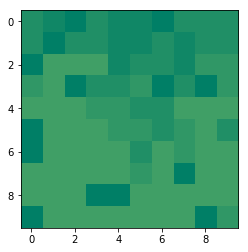

Step: 687
Updated position: [9 2]
Updated direction: [ 0 -1]


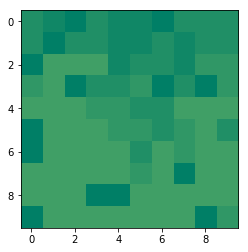

Step: 688
Updated position: [9 1]
Updated direction: [0 1]


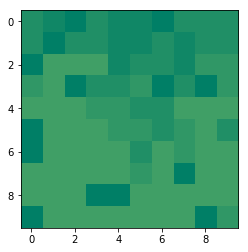

Step: 689
Updated position: [9 2]
Updated direction: [ 0 -1]


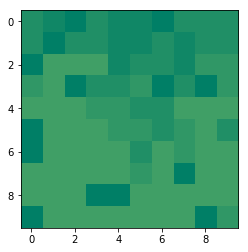

Step: 690
Updated position: [9 1]
Updated direction: [0 1]


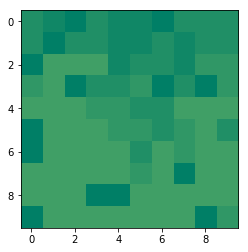

Step: 691
Updated position: [9 2]
Updated direction: [ 0 -1]


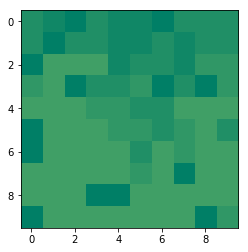

Step: 692
Updated position: [9 1]
Updated direction: [-1  0]


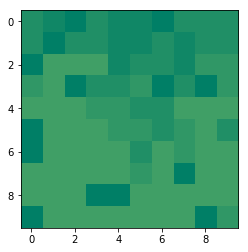

Step: 693
Updated position: [8 1]
Updated direction: [0 1]


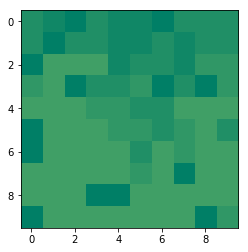

Step: 694
Updated position: [8 2]
Updated direction: [1 0]


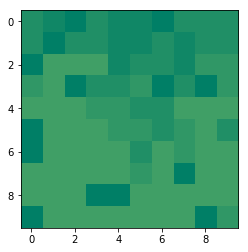

Step: 695
Updated position: [9 2]
Updated direction: [ 0 -1]


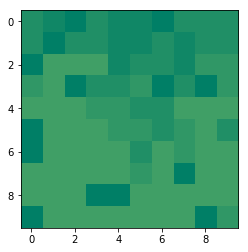

Step: 696
Updated position: [9 1]
Updated direction: [-1  0]


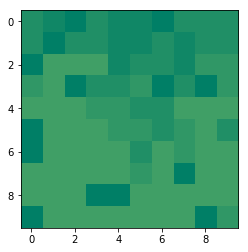

Step: 697
Updated position: [8 1]
Updated direction: [0 1]


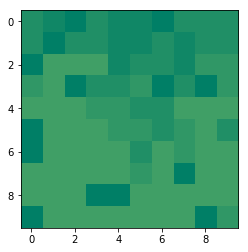

Step: 698
Updated position: [8 2]
Updated direction: [1 0]


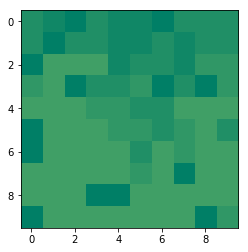

Step: 699
Updated position: [9 2]
Updated direction: [0 1]


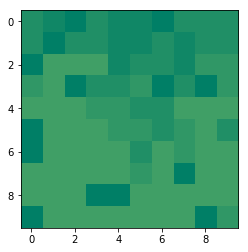

Step: 700
Updated position: [9 3]
Updated direction: [0 1]


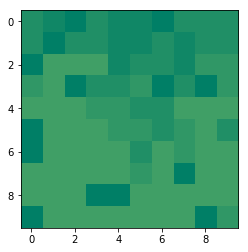

Step: 701
Updated position: [9 4]
Updated direction: [ 0 -1]


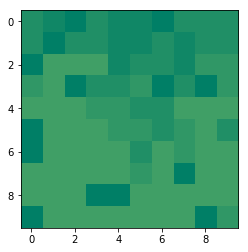

Step: 702
Updated position: [9 3]
Updated direction: [0 1]


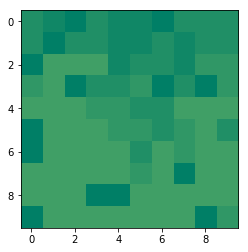

Step: 703
Updated position: [9 4]
Updated direction: [ 0 -1]


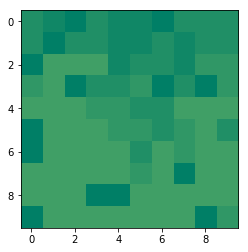

Step: 704
Updated position: [9 3]
Updated direction: [0 1]


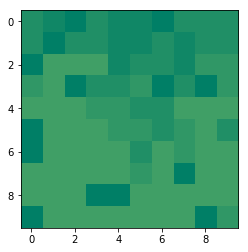

Step: 705
Updated position: [9 4]
Updated direction: [ 0 -1]


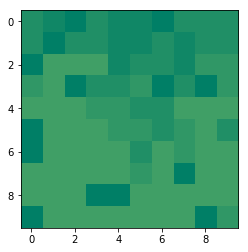

Step: 706
Updated position: [9 3]
Updated direction: [ 0 -1]


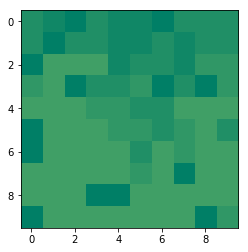

Step: 707
Updated position: [9 2]
Updated direction: [0 1]


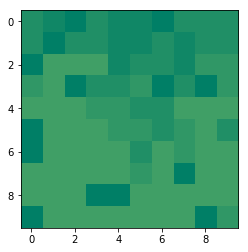

Step: 708
Updated position: [9 3]
Updated direction: [ 0 -1]


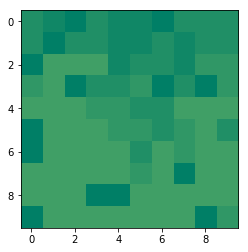

Step: 709
Updated position: [9 2]
Updated direction: [ 0 -1]


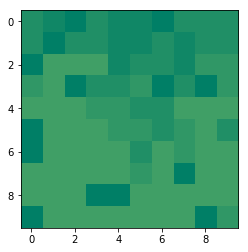

Step: 710
Updated position: [9 1]
Updated direction: [0 1]


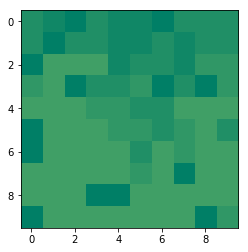

Step: 711
Updated position: [9 2]
Updated direction: [ 0 -1]


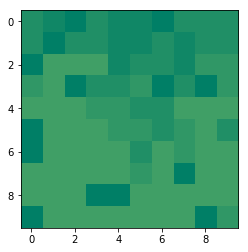

Step: 712
Updated position: [9 1]
Updated direction: [0 1]


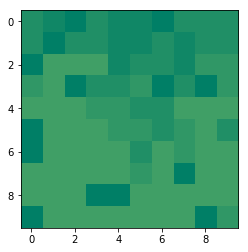

Step: 713
Updated position: [9 2]
Updated direction: [ 0 -1]


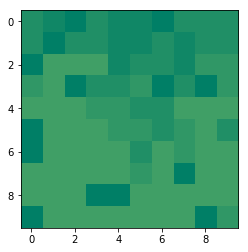

Step: 714
Updated position: [9 1]
Updated direction: [0 1]


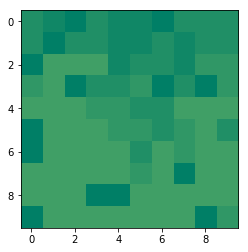

Step: 715
Updated position: [9 2]
Updated direction: [-1  0]


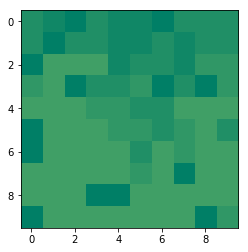

Step: 716
Updated position: [8 2]
Updated direction: [1 0]


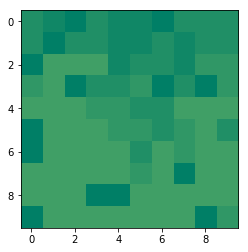

Step: 717
Updated position: [9 2]
Updated direction: [-1  0]


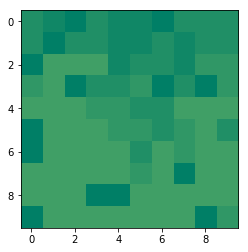

Step: 718
Updated position: [8 2]
Updated direction: [1 0]


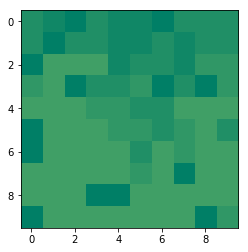

Step: 719
Updated position: [9 2]
Updated direction: [0 1]


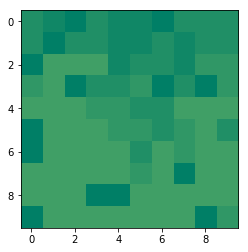

Step: 720
Updated position: [9 3]
Updated direction: [0 1]


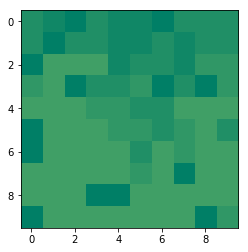

Step: 721
Updated position: [9 4]
Updated direction: [0 1]


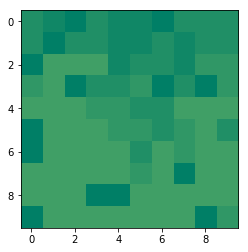

Step: 722
Updated position: [9 5]
Updated direction: [-1  0]


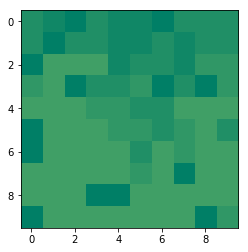

Step: 723
Updated position: [8 5]
Updated direction: [0 1]


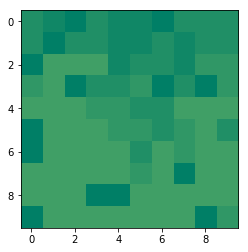

Step: 724
Updated position: [8 6]
Updated direction: [1 0]


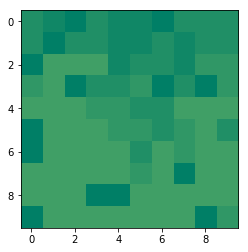

Step: 725
Updated position: [9 6]
Updated direction: [0 1]


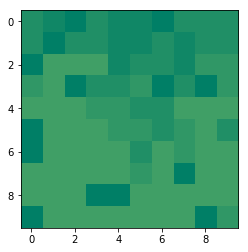

Step: 726
Updated position: [9 7]
Updated direction: [ 0 -1]


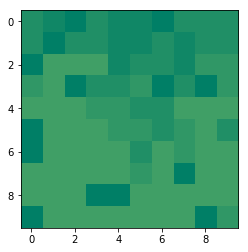

Step: 727
Updated position: [9 6]
Updated direction: [ 0 -1]


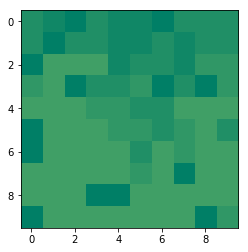

Step: 728
Updated position: [9 5]
Updated direction: [-1  0]


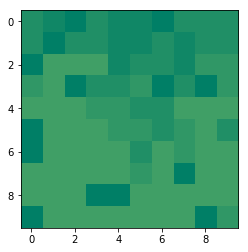

Step: 729
Updated position: [8 5]
Updated direction: [-1  0]


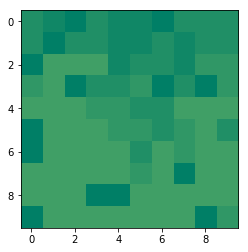

Step: 730
Updated position: [7 5]
Updated direction: [ 0 -1]


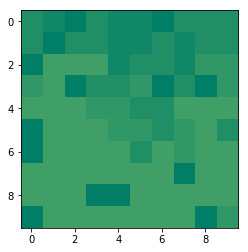

Step: 731
Updated position: [7 4]
Updated direction: [-1  0]


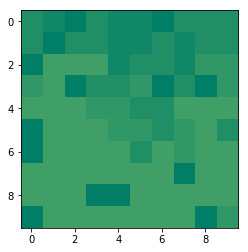

Step: 732
Updated position: [6 4]
Updated direction: [0 1]


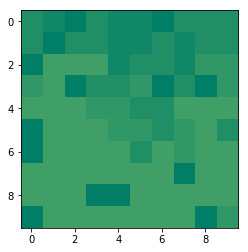

Step: 733
Updated position: [6 5]
Updated direction: [0 1]


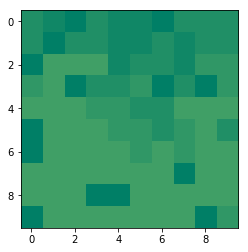

Step: 734
Updated position: [6 6]
Updated direction: [-1  0]


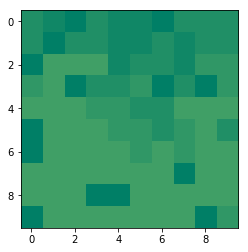

Step: 735
Updated position: [5 6]
Updated direction: [-1  0]


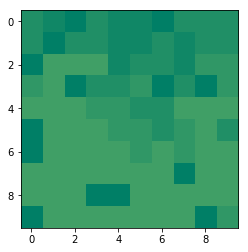

Step: 736
Updated position: [4 6]
Updated direction: [1 0]


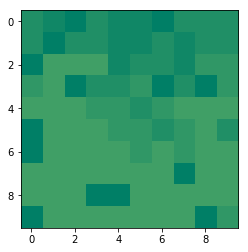

Step: 737
Updated position: [5 6]
Updated direction: [0 1]


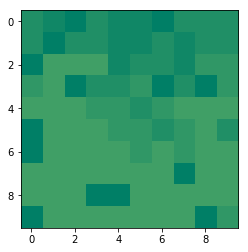

Step: 738
Updated position: [5 7]
Updated direction: [ 0 -1]


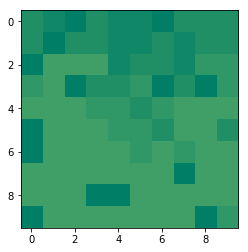

Step: 739
Updated position: [5 6]
Updated direction: [1 0]


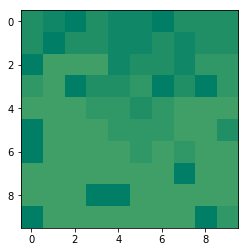

Step: 740
Updated position: [6 6]
Updated direction: [-1  0]


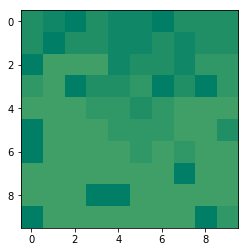

Step: 741
Updated position: [5 6]
Updated direction: [-1  0]


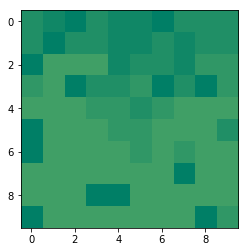

Step: 742
Updated position: [4 6]
Updated direction: [0 1]


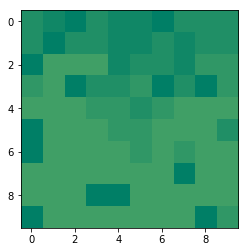

Step: 743
Updated position: [4 7]
Updated direction: [-1  0]


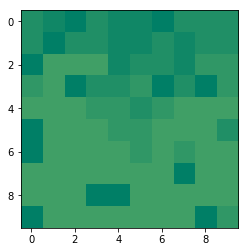

Step: 744
Updated position: [3 7]
Updated direction: [1 0]


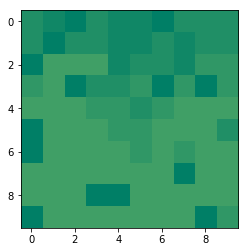

Step: 745
Updated position: [4 7]
Updated direction: [-1  0]


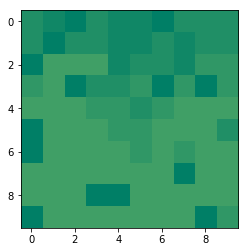

Step: 746
Updated position: [3 7]
Updated direction: [-1  0]


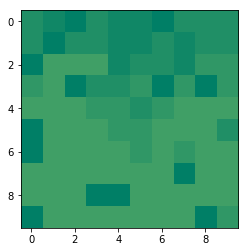

Step: 747
Updated position: [2 7]
Updated direction: [-1  0]


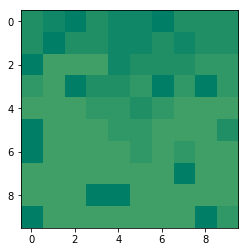

Step: 748
Updated position: [1 7]
Updated direction: [-1  0]


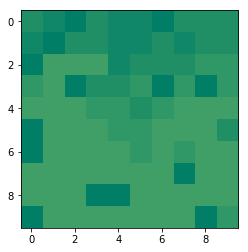

Step: 749
Updated position: [0 7]
Updated direction: [1 0]


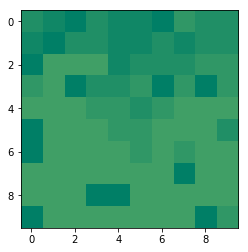

Step: 750
Updated position: [1 7]
Updated direction: [1 0]


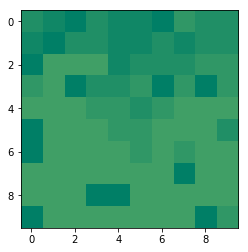

Step: 751
Updated position: [2 7]
Updated direction: [-1  0]


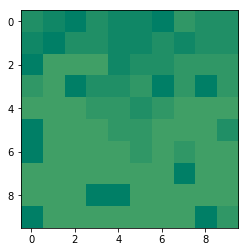

Step: 752
Updated position: [1 7]
Updated direction: [ 0 -1]


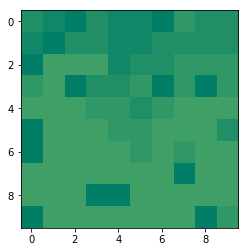

Step: 753
Updated position: [1 6]
Updated direction: [0 1]


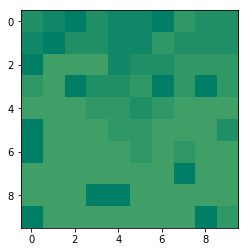

Step: 754
Updated position: [1 7]
Updated direction: [1 0]


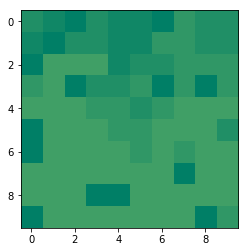

Step: 755
Updated position: [2 7]
Updated direction: [ 0 -1]


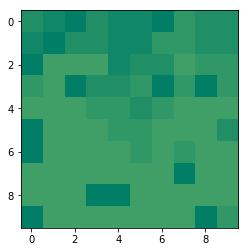

Step: 756
Updated position: [2 6]
Updated direction: [ 0 -1]


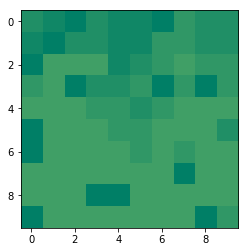

Step: 757
Updated position: [2 5]
Updated direction: [-1  0]


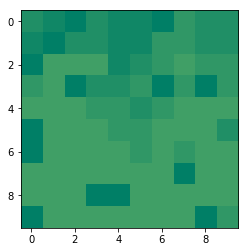

Step: 758
Updated position: [1 5]
Updated direction: [-1  0]


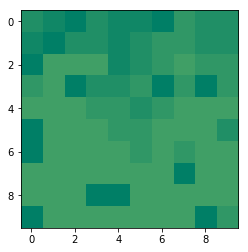

Step: 759
Updated position: [0 5]
Updated direction: [1 0]


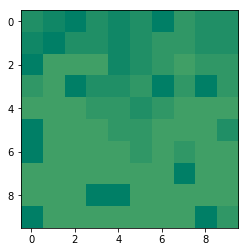

Step: 760
Updated position: [1 5]
Updated direction: [ 0 -1]


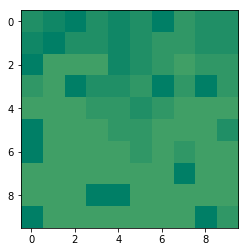

Step: 761
Updated position: [1 4]
Updated direction: [1 0]


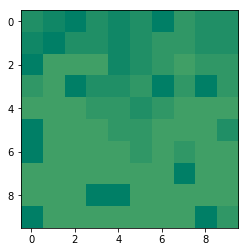

Step: 762
Updated position: [2 4]
Updated direction: [-1  0]


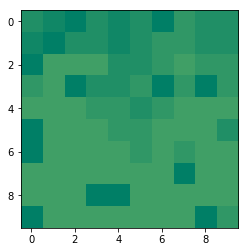

Step: 763
Updated position: [1 4]
Updated direction: [1 0]


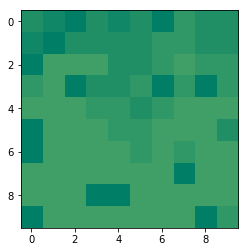

Step: 764
Updated position: [2 4]
Updated direction: [1 0]


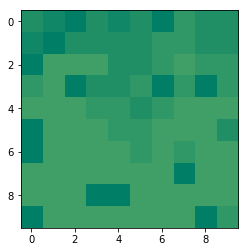

Step: 765
Updated position: [3 4]
Updated direction: [-1  0]


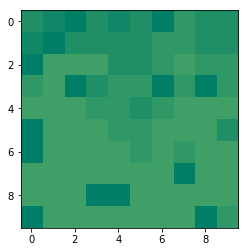

Step: 766
Updated position: [2 4]
Updated direction: [-1  0]


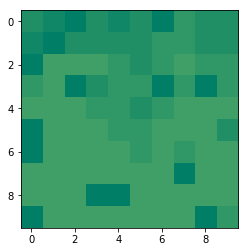

Step: 767
Updated position: [1 4]
Updated direction: [-1  0]


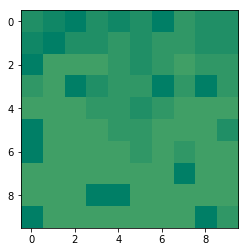

Step: 768
Updated position: [0 4]
Updated direction: [0 1]


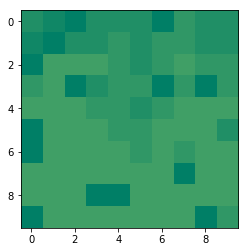

Total amount of time: 3452


In [165]:
# Visualization of the floor - Roomba 3
roomba_3 = RoombaSimulation(0.05, 0.05, 0.05, 0.05, 0.8, 10)
roomba_3.initialize()
steps_3 = 0
while len(np.where(roomba_3.config == 0)[0]) > 0.02*roomba_1.size**2 and steps_3 < 1000:
    print("Step: " + str(steps_3))
    roomba_3.cell_change()
    print("Updated position: " + str(roomba_3.pos))
    roomba_3.roomba_3()
    print("Updated direction: " + str(roomba_3.current_dir))
    steps_3 += 1
    plt.cla()
    plt.imshow(roomba_3.config, vmin = -1, vmax = 15, cmap = cm.summer)
    plt.show()
print("Total amount of time: " + str(roomba_3.T))

In [168]:
# 95% confidence interval
# amount of time
print("95% CI for time, roomba 1: " + str([np.percentile(np.array(time_list1), 2.5),
                                          np.percentile(np.array(time_list1), 97.5)]))
print("95% CI for time, roomba 2: " + str([np.percentile(np.array(time_list2), 2.5),
                                          np.percentile(np.array(time_list2), 97.5)]))
print("95% CI for time, roomba 3: " + str([np.percentile(np.array(time_list3), 2.5),
                                          np.percentile(np.array(time_list3), 97.5)]))

95% CI for time, roomba 1: [1661.325, 4341.9]
95% CI for time, roomba 2: [1443.875, 3313.7000000000003]
95% CI for time, roomba 3: [1660.9750000000001, 4315.0]


In [169]:
# 95% confidence interval
# number of steps
print("95% CI for time, roomba 1: " + str([np.percentile(np.array(steps_list1), 2.5),
                                          np.percentile(np.array(steps_list1), 97.5)]))
print("95% CI for time, roomba 2: " + str([np.percentile(np.array(steps_list2), 2.5),
                                          np.percentile(np.array(steps_list2), 97.5)]))
print("95% CI for time, roomba 3: " + str([np.percentile(np.array(steps_list3), 2.5),
                                          np.percentile(np.array(steps_list3), 97.5)]))

95% CI for time, roomba 1: [233.9, 617.3000000000001]
95% CI for time, roomba 2: [203.0, 471.4000000000001]
95% CI for time, roomba 3: [241.875, 1000.0]


In [171]:
# 95% confidence interval
# averaged cleanliness
print("95% CI for time, roomba 1: " + str([np.percentile(np.array(ave_cleaned_list1), 2.5),
                                          np.percentile(np.array(ave_cleaned_list1), 97.5)]))
print("95% CI for time, roomba 2: " + str([np.percentile(np.array(ave_cleaned_list2), 2.5),
                                          np.percentile(np.array(ave_cleaned_list2), 97.5)]))
print("95% CI for time, roomba 3: " + str([np.percentile(np.array(ave_cleaned_list3), 2.5),
                                          np.percentile(np.array(ave_cleaned_list3), 97.5)]))

95% CI for time, roomba 1: [1.79925, 4.43125]
95% CI for time, roomba 2: [1.489, 3.4617500000000003]
95% CI for time, roomba 3: [0.99, 2.241]


In [172]:
# 95% confidence interval
# cleanliness distribution
print("95% CI for time, roomba 1: " + str([np.percentile(np.array(cleanliness_1), 2.5),
                                          np.percentile(np.array(cleanliness_1), 97.5)]))
print("95% CI for time, roomba 2: " + str([np.percentile(np.array(cleanliness_2), 2.5),
                                          np.percentile(np.array(cleanliness_2), 97.5)]))
print("95% CI for time, roomba 3: " + str([np.percentile(np.array(cleanliness_3), 2.5),
                                          np.percentile(np.array(cleanliness_3), 97.5)]))

95% CI for time, roomba 1: [-1.0, 7.0]
95% CI for time, roomba 2: [-1.0, 6.0]
95% CI for time, roomba 3: [-1.0, 3.0]
